In [9]:
### 第一部分：数据预处理

import ijson
import json
import os
import pandas as pd
from datetime import datetime

## 数据精简与提取

# --- 读入文件路径 ---
DEPRESSED_FILE_PATH = '/Users/post/Downloads/WU3D/depressed.json'
NORMAL_FILE_PATH = '/Users/post/Downloads/WU3D/normal.json'
OUTPUT_CSV_FILE_PATH = '/Users/post/Downloads/WU3D/processed_user_data_shuffled.csv'

# --- 保留部分字段 ---
USER_FIELDS_TO_KEEP = [
    "nickname", "gender", "profile",
    "num_of_follower", "num_of_following", "all_tweet_count",
    "original_tweet_count", "repost_tweet_count"
]
TWEET_CONTENT_FIELD = "tweet_content"
MAX_TWEETS_PER_USER = 10 # 每个用户最多保留前10条推文的文本内容

# --- 数据处理函数（处理进程可视化版） ---
def process_user_data(file_path, label_value):
    processed_records = []

    print(f"\n--- 正在处理文件：{file_path} (标签: {label_value}) ---")
    print(f"文件大小：{os.path.getsize(file_path) / (1024 * 1024):.2f} MB")

    try:
        with open(file_path, 'rb') as f:
            user_count = 0
            for user_data in ijson.items(f, 'item'):
                simplified_user_data = {'label': label_value}

                for field in USER_FIELDS_TO_KEEP:
                    simplified_user_data[field] = user_data.get(field)

                # 提取并整合前MAX_TWEETS_PER_USER条推文内容
                limited_tweets_content = []
                if 'tweets' in user_data and isinstance(user_data['tweets'], list):
                    for i, tweet in enumerate(user_data['tweets']):
                        if i >= MAX_TWEETS_PER_USER:
                            break
                        if TWEET_CONTENT_FIELD in tweet:
                            limited_tweets_content.append(tweet[TWEET_CONTENT_FIELD])

                    simplified_user_data['all_tweets_content'] = " ||| ".join(limited_tweets_content)
                else:
                    simplified_user_data['all_tweets_content'] = ""

                processed_records.append(simplified_user_data)
                user_count += 1

                if user_count % 10000 == 0:
                    print(f"  已处理 {user_count} 个用户...")

        print(f"文件 {file_path} 处理完成。总共处理了 {user_count} 个用户。")
        return processed_records

    except FileNotFoundError:
        print(f"错误：文件未找到，请检查路径: {file_path}")
        return []
    except Exception as e:
        print(f"处理文件 {file_path} 时发生错误: {e}")
        return []

# --- 整合depressed和normal数据、打上标签并打乱 ---
if __name__ == "__main__":
    all_processed_data = []

    depressed_data = process_user_data(DEPRESSED_FILE_PATH, 1)
    all_processed_data.extend(depressed_data)

    normal_data = process_user_data(NORMAL_FILE_PATH, 0)
    all_processed_data.extend(normal_data)

    if not all_processed_data:
        print("没有处理到任何数据，可能是文件路径错误或文件内容异常。")
    else:
        df = pd.DataFrame(all_processed_data)

        # frac=1 表示保留所有行， random_state 用于确保每次运行结果一致 (可复现性)
        df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)

        print("\n--- 最终数据集 (Pandas DataFrame) 头部 (已打乱) ---")
        print(df_shuffled.head())
        print("\n--- 最终数据集信息 ---")
        print(df_shuffled.info())
        print(f"\n数据集总行数：{len(df_shuffled)}")


--- 正在处理文件：/Users/post/Downloads/WU3D/depressed.json (标签: 1) ---
文件大小：287.47 MB
  已处理 10000 个用户...
文件 /Users/post/Downloads/WU3D/depressed.json 处理完成。总共处理了 10325 个用户。

--- 正在处理文件：/Users/post/Downloads/WU3D/normal.json (标签: 0) ---
文件大小：825.11 MB
  已处理 10000 个用户...
  已处理 20000 个用户...
文件 /Users/post/Downloads/WU3D/normal.json 处理完成。总共处理了 22245 个用户。

--- 最终数据集 (Pandas DataFrame) 头部 (已打乱) ---
   label       nickname gender  \
0      0         江苏白云蓝天      女   
1      1       和冯同学的小确幸      女   
2      1        DStyles      女   
3      0  我本是一颗包治百病的板蓝根      女   
4      1        霁尚尚尚尚尚尚      女   

                                             profile num_of_follower  \
0        股市人生，人生股市，无明一破当下明心见性，永脱轮回之苦，觉悟自在快乐共享一切，感恩一切             326   
1                                       负能量居多  不要关注我              46   
2  不会穿搭的吃货不是一个好狗奴！ 坐标LA. Instagram: _dstyles B站/Y...            2504   
3                                       要发光🌞🌟🔅☀️💫⭐️✨             313   
4                                            


这一部分的几点说明：

1. 原数据集推文部分的字段比较复杂，还包括每条推文的点赞数、评论数等。考虑到本研究的目的以及可操作性，只保留了每个博主推文的文本部分；且为了建模时更快地运行出结果，设置MAX_TWEETS_PER_USER = 10，即每个用户最多保留前10条推文的文本内容。
2. 原数据集是分开的，抑郁症患者的微博信息存储在depressed文件中，正常人的微博信息存储在normal文件中。所以本部分对每个数据集进行信息提取之后对其打上标签、整合并打乱，用于下一步的分析处理。
3. 对推文部分的截断可能导致信息量运用不充分。但从整个建模结果来看，对于分类任务已经绰绰有余。后续如果想要提高模型效果，可以尝试使用全部文本进行建模。


In [11]:
## 数据读入、清洗与转换

import numpy as np 
from sklearn.preprocessing import OneHotEncoder # 用于独热编码

OUTPUT_CSV_FILE_PATH = '/Users/post/Downloads/WU3D/processed_user_data_shuffled.csv'

# 1. 在Jupyter中读入数据

data = pd.read_csv(OUTPUT_CSV_FILE_PATH)
print("数据已成功读入。")
print("\n原始数据信息:")
data.info()
print("\n原始数据头部:")
print(data.head())

# --- 数据清洗和类型转换 ---

# 2. 删除 nickname（昵称） 列
print("\n--- 删除 'nickname' 列 ---")
data = data.drop(columns=['nickname'])
print("'nickname' 列已删除。")

# 3. 处理数值型特征的数据类型问题
# 这些应该是数值型的列现在是 object 类型，直接转换为数值，将NaN填充为0后转为整数
numerical_cols = [
    'num_of_follower', 'num_of_following', 'all_tweet_count',
    'original_tweet_count', 'repost_tweet_count'
]

print("\n--- 开始清洗并转换数值型特征 ---")
for col in numerical_cols:
    # 转换为数值类型，errors='coerce' 会将无法转换的值变为 NaN
    data[col] = pd.to_numeric(data[col], errors='coerce')
    # 填充 NaN 为 0，并转换为整数类型
    data[col] = data[col].fillna(0).astype(int)

print("数值型特征清洗完成。")
print("\n清洗后数据信息 (初步):")
data.info()
print("\n清洗后数据头部 (初步):")
print(data.head())


# 4. 处理 'gender' 字段并进行独热编码
print("\n--- 处理 'gender' 字段并进行独热编码 ---")
print(f"原始 'gender' 唯一值: {data['gender'].unique()}")

data['gender'] = data['gender'].astype(str).str.strip()
data['gender'] = data['gender'].replace({'无': '未知', '': '未知'}) 

# 创建 OneHotEncoder 实例
# handle_unknown='ignore' 可以避免在遇到训练集中未出现过的性别时报错
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False) 

# 对 'gender' 列进行独热编码
gender_encoded = encoder.fit_transform(data[['gender']])

# 获取编码后的列名
gender_feature_names = encoder.get_feature_names_out(['gender'])

# 将编码后的结果添加到 DataFrame 中
data = pd.concat([data.drop(columns=['gender']), 
                  pd.DataFrame(gender_encoded, columns=gender_feature_names, index=data.index)], 
                 axis=1)

print(f"处理后 'gender' 相关列: {gender_feature_names}")
print("'gender' 字段独热编码完成。")


# 5. 处理 'profile' 和 'all_tweets_content' 字段的“无”或空字符串
print("\n--- 处理文本字段 'profile' 和 'all_tweets_content' ---")
text_cols = ['profile', 'all_tweets_content']
PAD_TOKEN = '[PAD]' # 定义填充的特殊标记

for col in text_cols:
    # 将 NaN 转换为空字符串，去除首尾空白
    data[col] = data[col].fillna('').astype(str).str.strip()
    # 将“无”或空字符串替换为 [PAD]
    data.loc[(data[col] == '无') | (data[col] == ''), col] = PAD_TOKEN
    print(f"列 '{col}' 中替换为 '[PAD]' 的数量: {(data[col] == PAD_TOKEN).sum()}")

print("文本字段清洗完成。")


# --- 最终检查数据状态 ---
print("\n--- 最终清洗后数据信息 ---")
data.info()
print("\n最终清洗后数据头部:")
print(data.head())

数据已成功读入。

原始数据信息:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32570 entries, 0 to 32569
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   label                 32570 non-null  int64 
 1   nickname              32570 non-null  object
 2   gender                32570 non-null  object
 3   profile               32568 non-null  object
 4   num_of_follower       32570 non-null  int64 
 5   num_of_following      32570 non-null  int64 
 6   all_tweet_count       32570 non-null  int64 
 7   original_tweet_count  32570 non-null  int64 
 8   repost_tweet_count    32570 non-null  int64 
 9   all_tweets_content    32569 non-null  object
dtypes: int64(6), object(4)
memory usage: 2.5+ MB

原始数据头部:
   label       nickname gender  \
0      0         江苏白云蓝天      女   
1      1       和冯同学的小确幸      女   
2      1        DStyles      女   
3      0  我本是一颗包治百病的板蓝根      女   
4      1        霁尚尚尚尚尚尚      女   

         


--- 可视化数值型变量的分布 ---


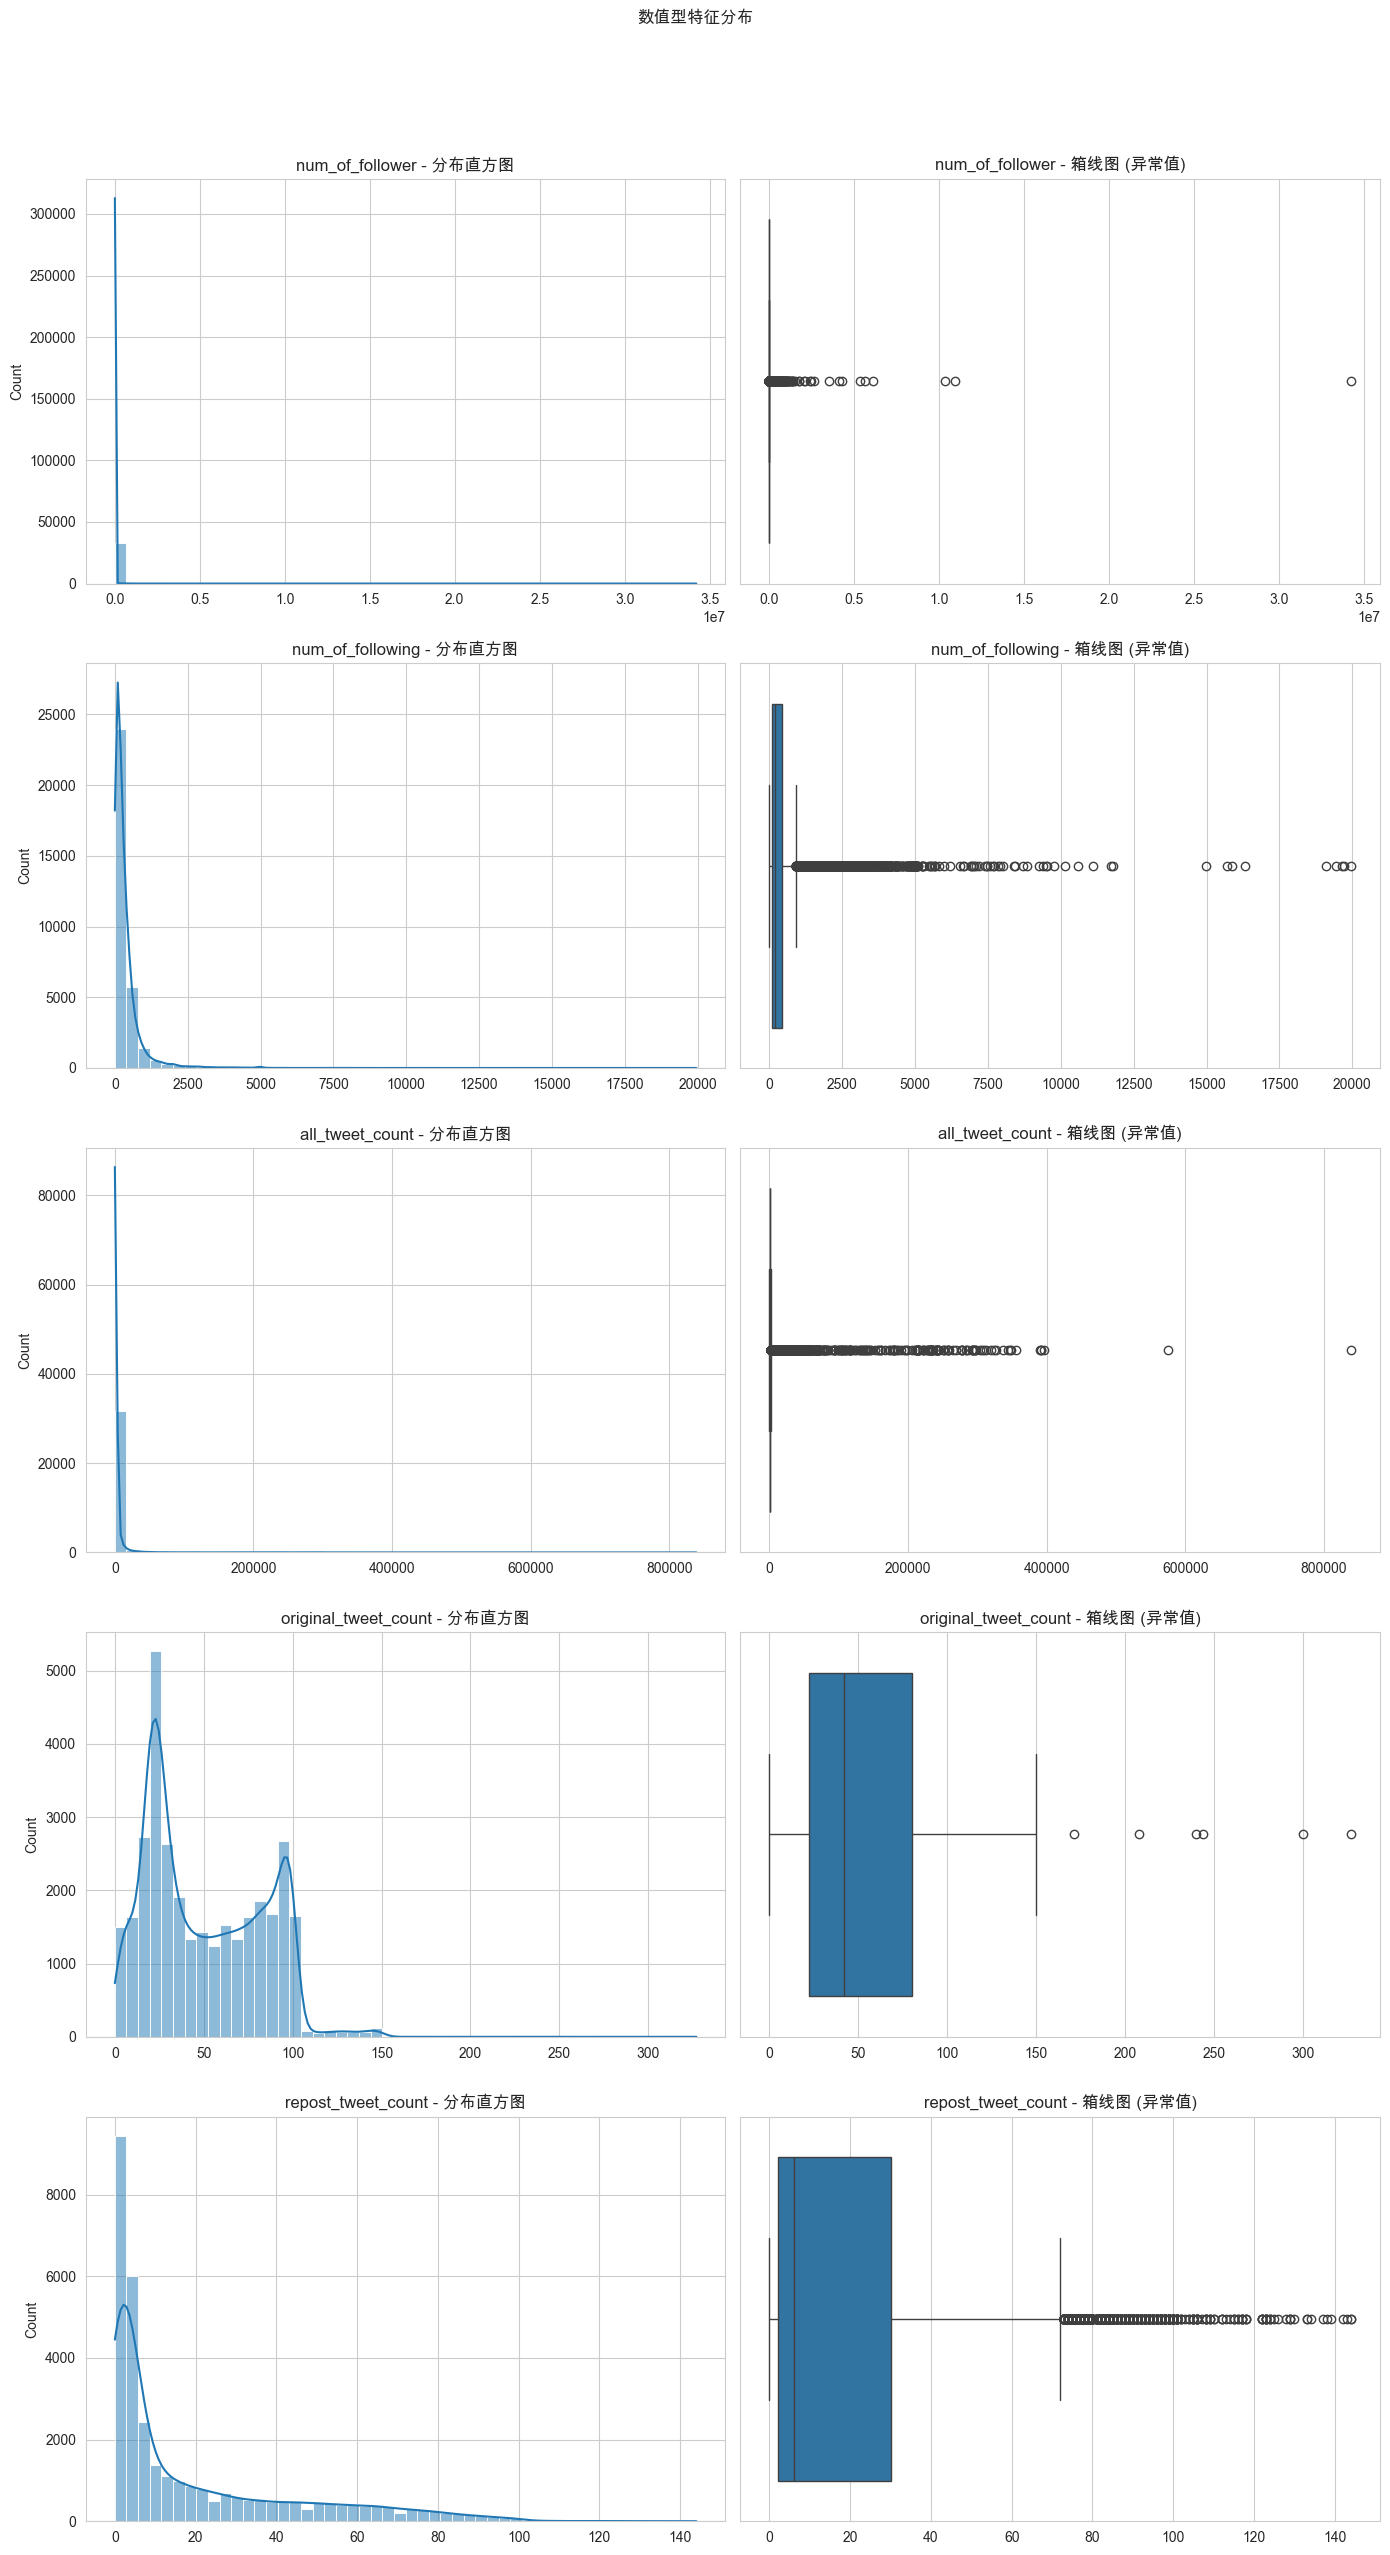


数值型变量可视化完成。
通过直方图观察分布形态（如偏态），通过箱线图观察异常值。


In [13]:
## 数值型变量：分布可视化与对数变换

import matplotlib.pyplot as plt
import seaborn as sns 

# 定义要处理的数值型列
numerical_features = [
    'num_of_follower',
    'num_of_following',
    'all_tweet_count',
    'original_tweet_count',
    'repost_tweet_count'
]

print("\n--- 可视化数值型变量的分布 ---")

# 设置图表风格
sns.set_style("whitegrid")
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS'] # 用于显示中文标签
plt.rcParams['axes.unicode_minus'] = False # 解决负号显示问题

# 创建子图，用于显示每个数值特征的直方图和箱线图
fig, axes = plt.subplots(len(numerical_features), 2, figsize=(14, 5 * len(numerical_features)))
fig.suptitle('数值型特征分布', y=1.02) 

for i, col in enumerate(numerical_features):
    # 直方图
    sns.histplot(data[col], kde=True, ax=axes[i, 0], bins=50)
    axes[i, 0].set_title(f'{col} - 分布直方图')
    axes[i, 0].set_xlabel('') 

    # 箱线图
    sns.boxplot(x=data[col], ax=axes[i, 1])
    axes[i, 1].set_title(f'{col} - 箱线图 (异常值)')
    axes[i, 1].set_xlabel('')

plt.tight_layout(rect=[0, 0, 1, 0.98]) 
plt.show()

print("\n数值型变量可视化完成。")
print("通过直方图观察分布形态（如偏态），通过箱线图观察异常值。")


可视化结果显示所有数值型变量分布都有严重的右偏形态，这和社交媒体中不同人群的特征是符合的————有的明星博主粉丝多推文多，但是部分普通人可能几乎没有什么粉丝。因此，必须对数值型变量进行对数变换，方便后续建模。



--- 对数转换和标准化数值型变量 ---
列 'num_of_follower' 已进行 log1p 转换，新列为 'num_of_follower_log'。
列 'num_of_following' 已进行 log1p 转换，新列为 'num_of_following_log'。
列 'all_tweet_count' 已进行 log1p 转换，新列为 'all_tweet_count_log'。
列 'original_tweet_count' 已进行 log1p 转换，新列为 'original_tweet_count_log'。
列 'repost_tweet_count' 已进行 log1p 转换，新列为 'repost_tweet_count_log'。


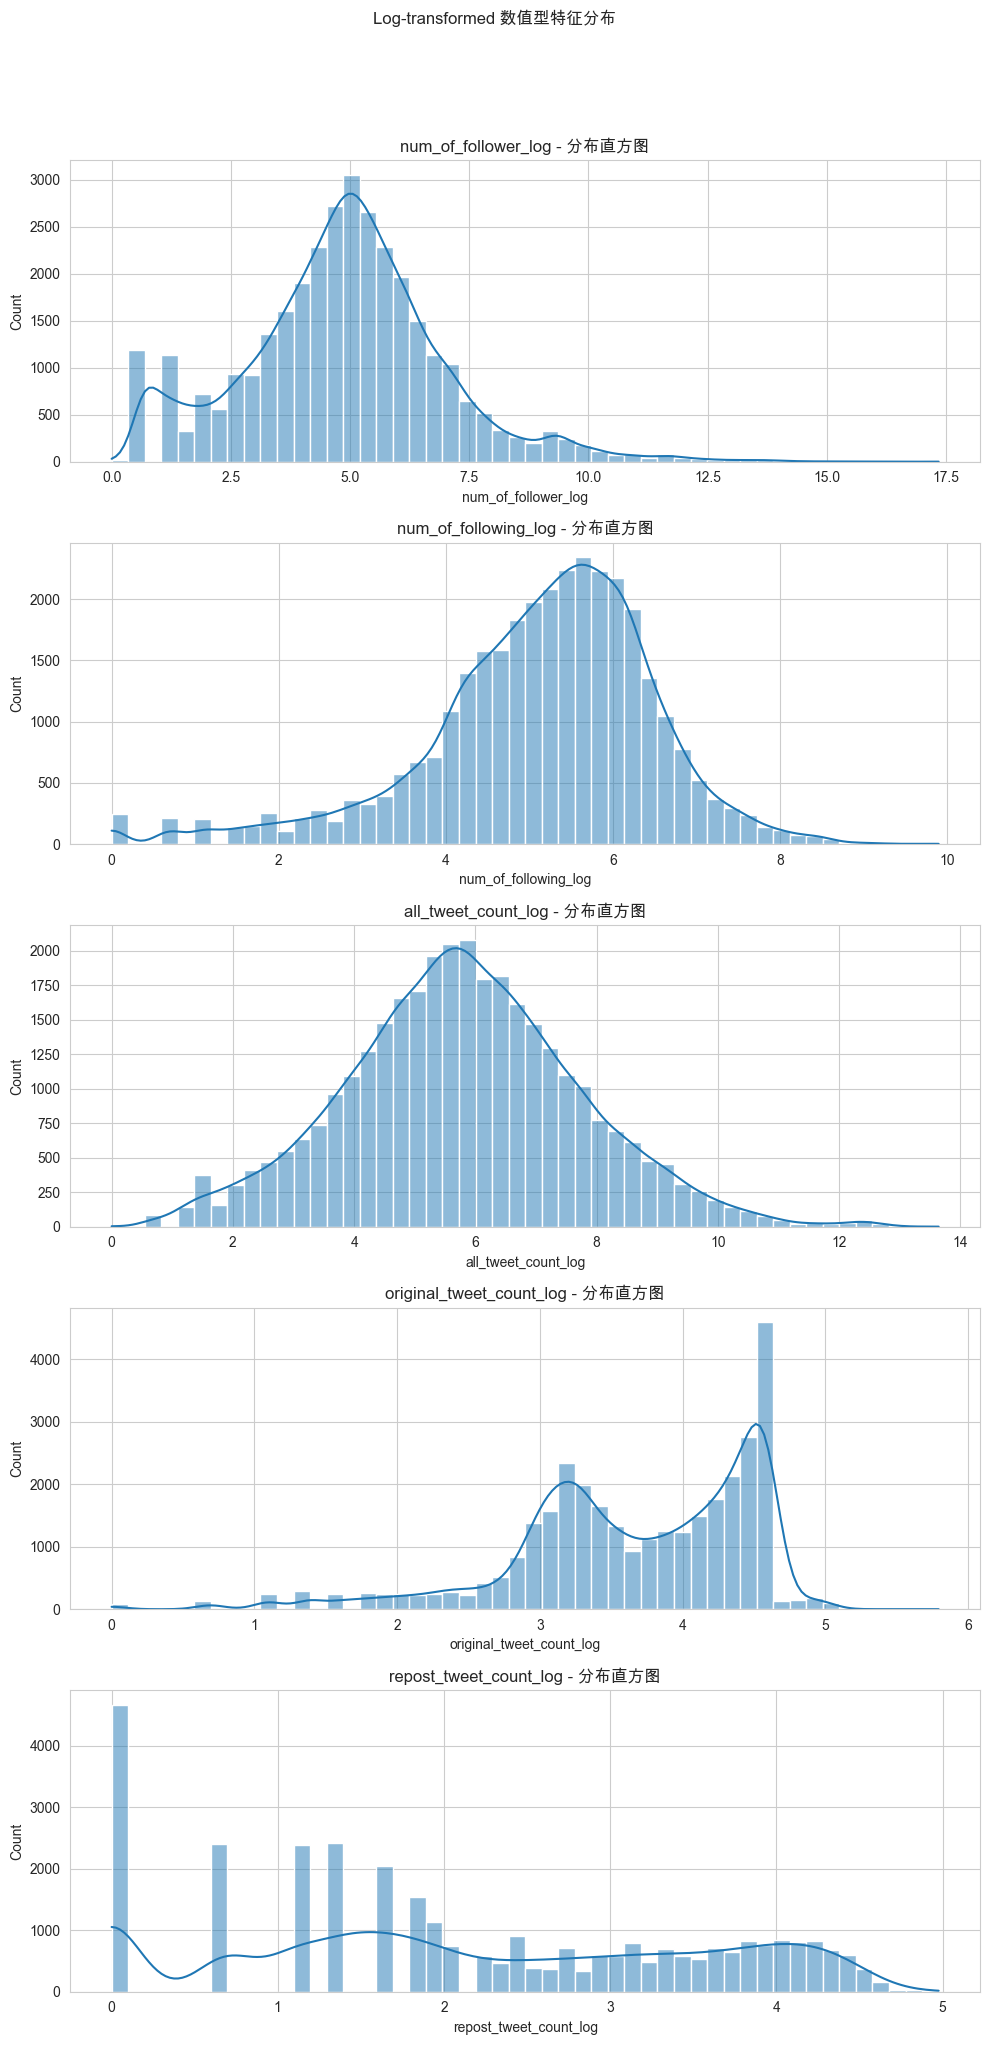

数值型特征已进行标准化。

标准化后数据信息:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32570 entries, 0 to 32569
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   label                     32570 non-null  int64  
 1   profile                   32570 non-null  object 
 2   num_of_follower           32570 non-null  int64  
 3   num_of_following          32570 non-null  int64  
 4   all_tweet_count           32570 non-null  int64  
 5   original_tweet_count      32570 non-null  int64  
 6   repost_tweet_count        32570 non-null  int64  
 7   all_tweets_content        32570 non-null  object 
 8   gender_女                  32570 non-null  float64
 9   gender_男                  32570 non-null  float64
 10  num_of_follower_log       32570 non-null  float64
 11  num_of_following_log      32570 non-null  float64
 12  all_tweet_count_log       32570 non-null  float64
 13  original_tweet_count_log  32570 non-n

In [15]:
from sklearn.preprocessing import StandardScaler

print("\n--- 对数转换和标准化数值型变量 ---")

# 对数转换 (log1p 适用于包含0的计数数据，log(x+1))
# 基于数据分布的可视化结果，上述数值特征都需要对数转换
for col in numerical_features: 
    data[f'{col}_log'] = np.log1p(data[col])
    print(f"列 '{col}' 已进行 log1p 转换，新列为 '{col}_log'。")

# 可视化对数转换后的分布
fig, axes = plt.subplots(len(numerical_features), 1, figsize=(10, 4 * len(numerical_features)))
fig.suptitle('Log-transformed 数值型特征分布', y=1.02)
for i, col in enumerate(numerical_features):
    sns.histplot(data[f'{col}_log'], kde=True, ax=axes[i], bins=50)
    axes[i].set_title(f'{col}_log - 分布直方图')
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

# 对转换后的数值特征进行标准化
numerical_features_transformed = [f'{col}_log' for col in numerical_features]

scaler = StandardScaler()
data[numerical_features_transformed] = scaler.fit_transform(data[numerical_features_transformed])

print("数值型特征已进行标准化。")

print("\n标准化后数据信息:")
data.info()
print("\n标准化后数据头部 (新的数值特征列):")
print(data[numerical_features_transformed].head())

print("\n数值型变量处理完成。")


对数变换之后数据分布形态整体令人满意，虽然有的特征呈现双峰分布，但这本来就是可能的信息来源，可以用于正式建模。


In [17]:
## 文本变量：分词与正则化、去停用词、填充空白

import jieba # 引入jieba分词库
import re    # 引入正则表达式库
import os    # 引入os模块

# --- 1. 加载停用词列表 ---
stopwords_file_path = '/Users/post/Downloads/文本分析/stopwords.dat' 

with open(stopwords_file_path, 'r', encoding='utf-8') as f:
    chinese_stopwords = set([line.strip() for line in f])
print(f"已加载停用词列表：{stopwords_file_path}")

# --- 2. 定义文本预处理函数 ---
PAD_TOKEN = '[PAD]' # 填充空文本的特殊标记

def preprocess_text(text):
    if pd.isna(text) or str(text).strip() == '' or str(text).strip() == '无':
        return PAD_TOKEN

    text = str(text).strip()

    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\u4e00-\u9fa5\s]', '', text) 
    text = re.sub(r'\s+', ' ', text).strip()
    
    if not text: 
        return PAD_TOKEN

    words = jieba.cut(text)
    filtered_words = [word for word in words if word not in chinese_stopwords and word.strip() != '']
    
    return " ".join(filtered_words)

# --- 3. 对文本列应用预处理 ---
text_cols = ['profile', 'all_tweets_content']

print("\n--- 开始文本预处理 ---")
for col in text_cols:
    data[col] = data[col].apply(preprocess_text)
    print(f"列 '{col}' 文本预处理完成。")

print("\n文本预处理完成。")

# --- 4. 最终检查清洗后的数据 ---
print("\n--- 最终清洗后数据信息 ---")
data.info()
print("\n最终清洗后数据头部 (文本列示例):")
print(data[text_cols].head())

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/t4/_y2wc33j1g188h2tcjbjh18m0000gn/T/jieba.cache


已加载停用词列表：/Users/post/Downloads/文本分析/stopwords.dat

--- 开始文本预处理 ---


Loading model cost 0.363 seconds.
Prefix dict has been built successfully.


列 'profile' 文本预处理完成。
列 'all_tweets_content' 文本预处理完成。

文本预处理完成。

--- 最终清洗后数据信息 ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32570 entries, 0 to 32569
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   label                     32570 non-null  int64  
 1   profile                   32570 non-null  object 
 2   num_of_follower           32570 non-null  int64  
 3   num_of_following          32570 non-null  int64  
 4   all_tweet_count           32570 non-null  int64  
 5   original_tweet_count      32570 non-null  int64  
 6   repost_tweet_count        32570 non-null  int64  
 7   all_tweets_content        32570 non-null  object 
 8   gender_女                  32570 non-null  float64
 9   gender_男                  32570 non-null  float64
 10  num_of_follower_log       32570 non-null  float64
 11  num_of_following_log      32570 non-null  float64
 12  all_tweet_count_log       32570 no

In [19]:
##文本向量化方法：word embedding

from gensim.models import KeyedVectors

# --- 1. 加载预训练词向量模型 ---
WORD_EMBEDDING_MODEL_PATH = '/Users/post/Downloads/wiki.zh/wiki.zh.vec' 

word_vectors_model = KeyedVectors.load_word2vec_format(WORD_EMBEDDING_MODEL_PATH, binary=False)
EMBEDDING_DIM = word_vectors_model.vector_size # 获取词向量的维度
print(f"\n已成功加载词向量模型，维度为：{EMBEDDING_DIM}")

# --- 2. 定义文本到向量的转换函数 ---
def get_text_embedding(text, model, embedding_dim, pad_token=PAD_TOKEN):
    if text == pad_token: # 如果是PAD_TOKEN，返回全零向量
        return np.zeros(embedding_dim)
    
    words = text.split() # 文本已分词并用空格连接
    
    # 收集所有词的词向量
    word_vectors = []
    for word in words:
        if word in model:
            word_vectors.append(model[word])
    
    # 如果文本中没有词在词汇表中，也返回全零向量
    if not word_vectors:
        return np.zeros(embedding_dim)
    
    # 平均词向量
    return np.mean(word_vectors, axis=0)

# --- 3. 对文本列应用 Embedding（进程可视化） ---
text_cols_to_embed = ['profile', 'all_tweets_content']

print("\n--- 开始对文本列进行 Embedding ---")
for col in text_cols_to_embed:
    # 应用函数获取每个文本的 embedding 向量
    data[f'{col}_embedding'] = data[col].apply(
        lambda x: get_text_embedding(x, word_vectors_model, EMBEDDING_DIM, PAD_TOKEN)
    )
    print(f"列 '{col}' Embedding 完成。")

# --- 4. 将 Embedding 向量展开为单独的列 ---
# 这一步是为了便于后续的早期融合和传统机器学习模型输入
print("\n--- 展开 Embedding 向量为单独的列 ---")
for col in text_cols_to_embed:
    embedding_col_name = f'{col}_embedding'
    
    # 检查 embedding 是否是 NumPy 数组
    if isinstance(data[embedding_col_name].iloc[0], np.ndarray):
        # 将 NumPy 数组列表转换为一个新的 DataFrame，每一维度一列
        expanded_embeddings = pd.DataFrame(
            data[embedding_col_name].tolist(), 
            index=data.index,
            columns=[f'{col}_emb_{i}' for i in range(EMBEDDING_DIM)]
        )
        # 将展开后的列添加到主 DataFrame 中
        data = pd.concat([data, expanded_embeddings], axis=1)
        print(f"列 '{embedding_col_name}' 已展开为 {EMBEDDING_DIM} 个新列。")
    else:
        print(f"警告：列 '{embedding_col_name}' 中的数据不是 NumPy 数组，跳过展开。")

    # 删除原始的包含向量的列
    data = data.drop(columns=[embedding_col_name])

print("\n文本 Embedding 处理完成。")

# --- 5. 最终检查数据状态 ---
print("\n--- 最终清洗和特征工程后数据信息 ---")
data.info()
print("\n最终清洗和特征工程后数据头部 (新的 Embedding 列示例):")
# 打印部分原始列和部分新的embedding列
print(data[['label', 'gender_男', 'num_of_follower', 'profile_emb_0', 'profile_emb_1', 'all_tweets_content_emb_0', 'all_tweets_content_emb_1']].head())

/opt/anaconda3/envs/my_ml_env/lib/python3.9/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(



已成功加载词向量模型，维度为：300

--- 开始对文本列进行 Embedding ---
列 'profile' Embedding 完成。
列 'all_tweets_content' Embedding 完成。

--- 展开 Embedding 向量为单独的列 ---
列 'profile_embedding' 已展开为 300 个新列。
列 'all_tweets_content_embedding' 已展开为 300 个新列。

文本 Embedding 处理完成。

--- 最终清洗和特征工程后数据信息 ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32570 entries, 0 to 32569
Columns: 615 entries, label to all_tweets_content_emb_299
dtypes: float64(607), int64(6), object(2)
memory usage: 152.8+ MB

最终清洗和特征工程后数据头部 (新的 Embedding 列示例):
   label  gender_男  num_of_follower  profile_emb_0  profile_emb_1  \
0      0       0.0              326      -0.006375       0.692989   
1      1       0.0               46      -0.060630       0.854970   
2      1       0.0             2504      -0.078910       1.006227   
3      0       0.0              313      -0.209590       0.507980   
4      1       0.0                1       0.000000       0.000000   

   all_tweets_content_emb_0  all_tweets_content_emb_1  
0                 -0.0690


说明：这里对文本的向量化处理选择了词嵌入而非TF-IDF。因为即使对推文数量进行了截断，分词之后仍有很多小单元，使用TF-IDF不仅会导致维度灾难，还没有词嵌入方法能捕捉语义关系的优势。词嵌入模型选择的是维基百科中的官方嵌入模型，设定为300维度。


In [21]:
### 第二部分：多模型的分类效果评估——传统机器学习模型

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, accuracy_score

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline # 用于更规范地处理采样和建模流程

plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False 

## 提取用于建模的列，划分数据集

# --- 1. 定义特征 (X) 和目标变量 (y) ---
# 明确排除原始文本列、目标列以及未经过对数转换的原始数值列
columns_to_exclude = [
    'label',
    'profile',             # 原始文本列
    'all_tweets_content',  # 原始文本列
    'num_of_follower',     # 原始数值列
    'num_of_following',    # 原始数值列
    'all_tweet_count',     # 原始数值列
    'original_tweet_count',# 原始数值列
    'repost_tweet_count'   # 原始数值列
]

# 筛选出所有要作为特征的列（即除了排除列之外的所有列）
features = [col for col in data.columns if col not in columns_to_exclude]
X = data[features]
y = data['label']

print(f"用于训练的特征数量: {X.shape[1]}")
print(f"用于训练的样本数量: {X.shape[0]}")


# --- 2. 划分训练集和测试集 ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"训练集样本数: {X_train.shape[0]}, 测试集样本数: {X_test.shape[0]}")

用于训练的特征数量: 607
用于训练的样本数量: 32570
训练集样本数: 26056, 测试集样本数: 6514


In [23]:
## 定义评估和可视化函数 

def evaluate_and_plot(model_name, y_true, y_pred, y_pred_proba):
    """评估模型并绘制混淆矩阵和ROC曲线。"""
    print(f"\n--- {model_name} 模型评估报告 ---")
    print(f"准确率 (Accuracy): {accuracy_score(y_true, y_pred):.4f}")
    print("\n分类报告 (Classification Report):")
    print(classification_report(y_true, y_pred))

    cm = confusion_matrix(y_true, y_pred)
    print("\n混淆矩阵 (Confusion Matrix):\n", cm)

    roc_auc = roc_auc_score(y_true, y_pred_proba)
    print(f"\nROC AUC 分数: {roc_auc:.4f}")

    # 混淆矩阵可视化
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['预测为非抑郁 (0)', '预测为抑郁 (1)'],
                yticklabels=['实际为非抑郁 (0)', '实际为抑郁 (1)'])
    plt.title(f'{model_name} - 混淆矩阵')
    plt.xlabel('预测标签')
    plt.ylabel('真实标签')
    plt.show()

    # ROC 曲线可视化
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    plt.figure(figsize=(7, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC 曲线 (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('假正例率 (False Positive Rate)')
    plt.ylabel('真正例率 (True Positive Rate)')
    plt.title(f'{model_name} - 受试者工作特征曲线 (ROC Curve)')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

In [47]:
def evaluate_and_plot_svm(model_name, y_true, y_pred, y_scores): 
    """评估模型并绘制混淆矩阵和ROC曲线。"""
    print(f"\n--- {model_name} 模型评估报告 ---")
    print(f"准确率 (Accuracy): {accuracy_score(y_true, y_pred):.4f}")
    print("\n分类报告 (Classification Report):")
    print(classification_report(y_true, y_pred))

    cm = confusion_matrix(y_true, y_pred)
    print("\n混淆矩阵 (Confusion Matrix):\n", cm)

    # 对于 LinearSVC，使用 decision_function 的分数来计算 ROC AUC
    roc_auc = roc_auc_score(y_true, y_scores) 
    print(f"\nROC AUC 分数: {roc_auc:.4f}")

    # 混淆矩阵可视化
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['预测为非抑郁 (0)', '预测为抑郁 (1)'],
                yticklabels=['实际为非抑郁 (0)', '实际为抑郁 (1)'])
    plt.title(f'{model_name} - 混淆矩阵')
    plt.xlabel('预测标签')
    plt.ylabel('真实标签')
    plt.show()

    # ROC 曲线可视化
    fpr, tpr, thresholds = roc_curve(y_true, y_scores) # 使用 scores
    plt.figure(figsize=(7, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC 曲线 (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('假正例率 (False Positive Rate)')
    plt.ylabel('真正例率 (True Positive Rate)')
    plt.title(f'{model_name} - 受试者工作特征曲线 (ROC Curve)')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()


关于该部分的说明：后续建模时发现普通支持向量机运行速度很慢，所以采用了LinearSVC。
该分类器采用坐标下降法进行优化，在处理大规模数据集时比 SVC(kernel='linear') 更快，尤其是当样本数量远大于特征数量时。
但是LinearSVC 默认没有 predict_proba() 方法来输出类别的概率，它只提供 decision_function() 方法来输出样本到决策超平面的距离。
普通的评估与可视化函数会报错，所以对LinearSVC采用特殊的evaluate_and_plot_svm函数。



--- 1. 原始数据 Logistic 回归 ---

--- 原始数据 模型评估报告 ---
准确率 (Accuracy): 0.9054

分类报告 (Classification Report):
              precision    recall  f1-score   support

           0       0.92      0.95      0.93      4449
           1       0.88      0.81      0.85      2065

    accuracy                           0.91      6514
   macro avg       0.90      0.88      0.89      6514
weighted avg       0.90      0.91      0.90      6514


混淆矩阵 (Confusion Matrix):
 [[4218  231]
 [ 385 1680]]

ROC AUC 分数: 0.9381


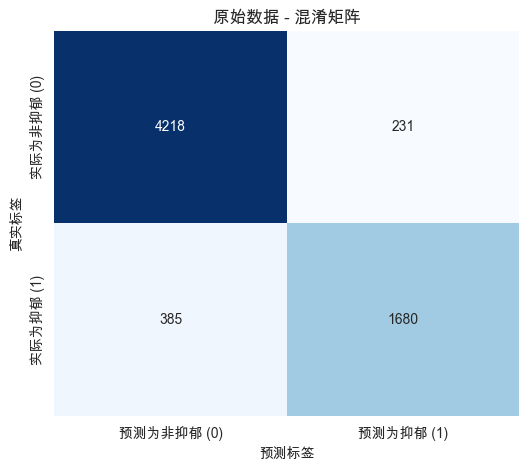

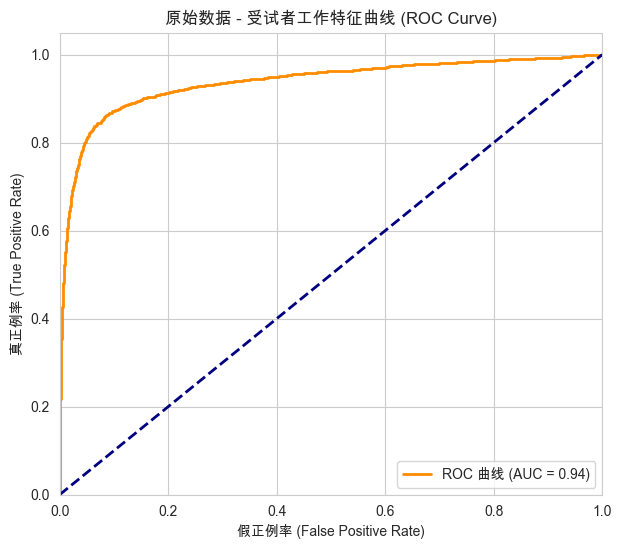


--- 2. 过采样 (RandomOverSampler) Logistic 回归 ---


/opt/anaconda3/envs/my_ml_env/lib/python3.9/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/opt/anaconda3/envs/my_ml_env/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(



--- 过采样 (RandomOverSampler) 模型评估报告 ---
准确率 (Accuracy): 0.8901

分类报告 (Classification Report):
              precision    recall  f1-score   support

           0       0.93      0.90      0.92      4449
           1       0.80      0.86      0.83      2065

    accuracy                           0.89      6514
   macro avg       0.87      0.88      0.88      6514
weighted avg       0.89      0.89      0.89      6514


混淆矩阵 (Confusion Matrix):
 [[4012  437]
 [ 279 1786]]

ROC AUC 分数: 0.9382


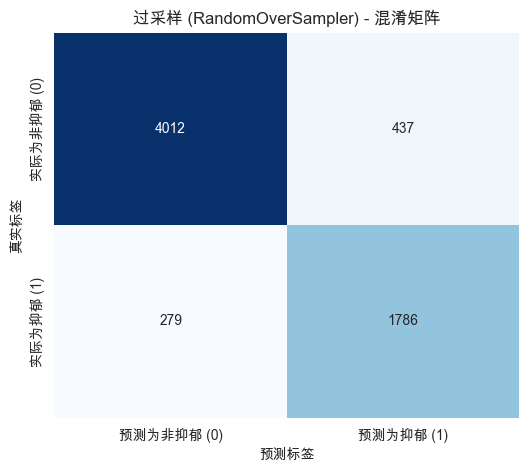

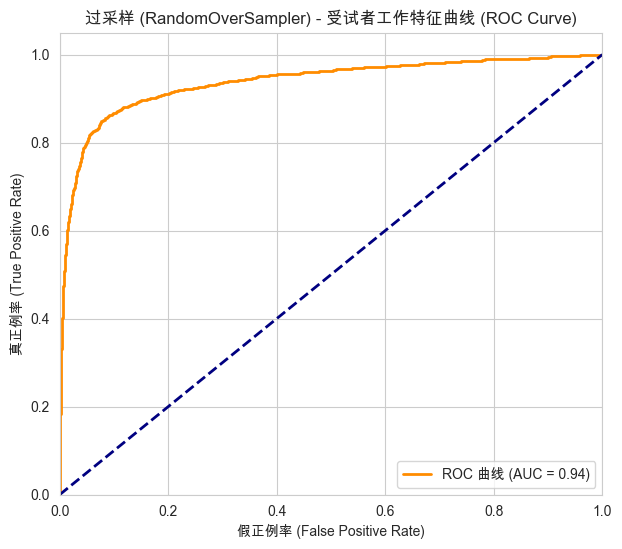


--- 3. 欠采样 (RandomUnderSampler) Logistic 回归 ---


/opt/anaconda3/envs/my_ml_env/lib/python3.9/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/opt/anaconda3/envs/my_ml_env/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(



--- 欠采样 (RandomUnderSampler) 模型评估报告 ---
准确率 (Accuracy): 0.8905

分类报告 (Classification Report):
              precision    recall  f1-score   support

           0       0.94      0.90      0.92      4449
           1       0.80      0.87      0.83      2065

    accuracy                           0.89      6514
   macro avg       0.87      0.89      0.88      6514
weighted avg       0.89      0.89      0.89      6514


混淆矩阵 (Confusion Matrix):
 [[4004  445]
 [ 268 1797]]

ROC AUC 分数: 0.9377


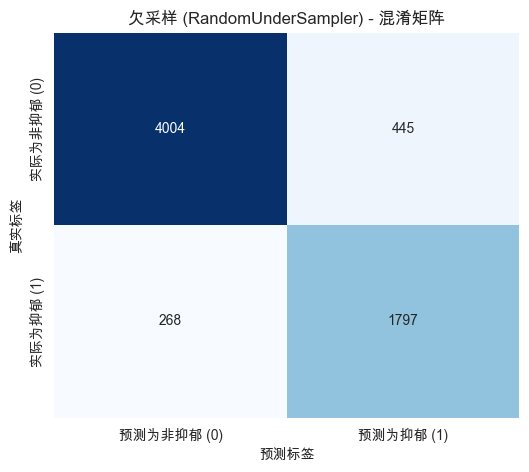

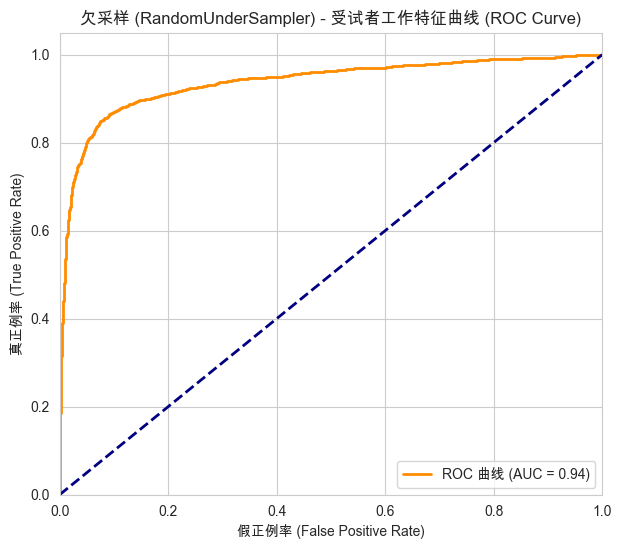


--- 4. SMOTE Logistic 回归 ---


/opt/anaconda3/envs/my_ml_env/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(



--- SMOTE 模型评估报告 ---
准确率 (Accuracy): 0.8922

分类报告 (Classification Report):
              precision    recall  f1-score   support

           0       0.93      0.91      0.92      4449
           1       0.81      0.86      0.84      2065

    accuracy                           0.89      6514
   macro avg       0.87      0.88      0.88      6514
weighted avg       0.89      0.89      0.89      6514


混淆矩阵 (Confusion Matrix):
 [[4033  416]
 [ 286 1779]]

ROC AUC 分数: 0.9394


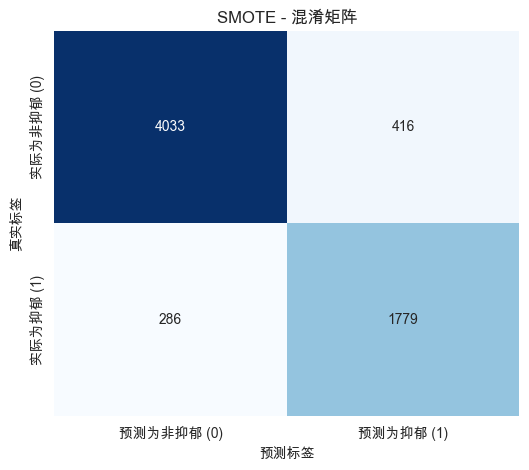

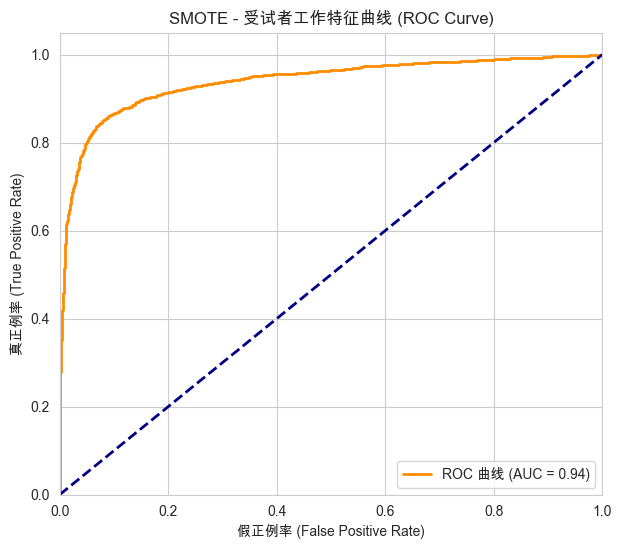


所有采样方法下的 Logistic 回归建模与评估完成。


In [55]:
## 模型一：logistic回归模型

from sklearn.linear_model import LogisticRegression

# --- 1. 原始数据 (不处理不平衡) 的 Logistic 回归 ---
print("\n--- 1. 原始数据 Logistic 回归 ---")
model_orig = LogisticRegression(penalty='l2', C=1.0, solver='liblinear', max_iter=500, random_state=42)
model_orig.fit(X_train, y_train)

y_pred_orig = model_orig.predict(X_test)
y_pred_proba_orig = model_orig.predict_proba(X_test)[:, 1]
evaluate_and_plot("原始数据", y_test, y_pred_orig, y_pred_proba_orig)


# --- 2. 过采样 (RandomOverSampler) ---
print("\n--- 2. 过采样 (RandomOverSampler) Logistic 回归 ---")
# 构建一个格式化的pipline
pipeline_oversample = Pipeline([
    ('oversampler', RandomOverSampler(random_state=42)),
    ('classifier', LogisticRegression(penalty='l2', C=1.0, solver='liblinear', max_iter=500, random_state=42))
])

pipeline_oversample.fit(X_train, y_train)

y_pred_oversample = pipeline_oversample.predict(X_test)
y_pred_proba_oversample = pipeline_oversample.predict_proba(X_test)[:, 1]
evaluate_and_plot("过采样 (RandomOverSampler)", y_test, y_pred_oversample, y_pred_proba_oversample)


# --- 3. 欠采样 (RandomUnderSampler) ---
print("\n--- 3. 欠采样 (RandomUnderSampler) Logistic 回归 ---")
pipeline_undersample = Pipeline([
    ('undersampler', RandomUnderSampler(random_state=42)),
    ('classifier', LogisticRegression(penalty='l2', C=1.0, solver='liblinear', max_iter=500, random_state=42))
])

pipeline_undersample.fit(X_train, y_train)

y_pred_undersample = pipeline_undersample.predict(X_test)
y_pred_proba_undersample = pipeline_undersample.predict_proba(X_test)[:, 1]
evaluate_and_plot("欠采样 (RandomUnderSampler)", y_test, y_pred_undersample, y_pred_proba_undersample)


# --- 4. SMOTE (Synthetic Minority Over-sampling Technique) ---
print("\n--- 4. SMOTE Logistic 回归 ---")
pipeline_smote = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(penalty='l2', C=1.0, solver='liblinear', max_iter=500, random_state=42))
])

pipeline_smote.fit(X_train, y_train)

y_pred_smote = pipeline_smote.predict(X_test)
y_pred_proba_smote = pipeline_smote.predict_proba(X_test)[:, 1]
evaluate_and_plot("SMOTE", y_test, y_pred_smote, y_pred_proba_smote)

print("\n所有采样方法下的 Logistic 回归建模与评估完成。")


模型一：logistic回归评估结果概述

原始模型在测试集上的总体表现良好，获得了 0.9054 的准确率。然而，由于数据存在类别不平衡，我们进一步分析了模型在不同类别上的表现以及其区分能力。

模型取得了令人满意的 ROC AUC 分数：0.9381，表明其在区分正负样本方面具有较强的能力。

对多数类 (0) 的表现：模型对多数类 (0) 的识别能力非常强，精确率和召回率均达到了 0.90 以上（精确率 0.92，召回率 0.95）。

对少数类 (1) 的表现：尽管类别 1 的样本较少，模型依然表现出不错的识别能力。其精确率为 0.88，意味着当模型预测为类别 1 时，有 88% 是正确的。召回率为 0.81，表示模型成功识别出了 81% 的真实类别 1 样本。F1-Score 达到 0.85，说明在精确率和召回率之间取得了较好的平衡。

为进一步探究抑郁症患者样本量增加时，模型的效果会不会有显著提升，构建了pipline（以便格式化、高效处理数据+建模+输出分析结果），分别使用过采样、欠采样、smote方法进行数据增强后建模。

但从AUC分数来看，表现最好的logistic_smote模型较原模型也只是有微弱的提升；并且从少数类 (1) 的f1分数看，三个衍生模型对于少数类的识别效果甚至不如原模型。

可能的原因有：重采样技术引入副作用，比如欠采样方法导致训练数据丢失大量关于多数类的有用信息和复杂模式，从而使得模型在识别多数类时变得不那么稳健，进而影响到对少数类的误判率；过采样导致模型过拟合到这些重复的少数类样本，降低模型的泛化能力，使其在真实的、未重复的测试数据上表现不佳；SMOTE 可能会在不具有代表性的区域生成“人造”样本，甚至引入噪声，这些合成样本可能使得模型学习到的少数类决策边界过于平滑或不精确，导致在真实数据上难以有效区分。这说明在处理类别不平衡问题时，简单的重采样技术并非万能药，也并非总能带来预期的线性提升。

Logistic 回归是一种线性模型，而原始特征空间可能较为复杂或非线性，因此，后续会引入其他非线性模型，并进行分类效果的评估。



--- 1. 原始数据 朴素贝叶斯 ---

--- 原始数据朴素贝叶斯 模型评估报告 ---
准确率 (Accuracy): 0.5967

分类报告 (Classification Report):
              precision    recall  f1-score   support

           0       0.91      0.45      0.61      4449
           1       0.43      0.90      0.59      2065

    accuracy                           0.60      6514
   macro avg       0.67      0.68      0.60      6514
weighted avg       0.76      0.60      0.60      6514


混淆矩阵 (Confusion Matrix):
 [[2024 2425]
 [ 202 1863]]

ROC AUC 分数: 0.7203


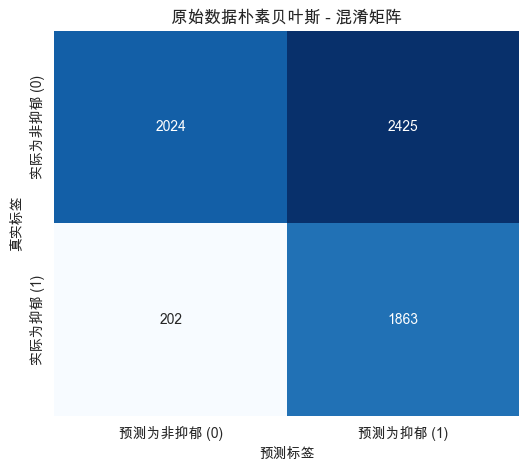

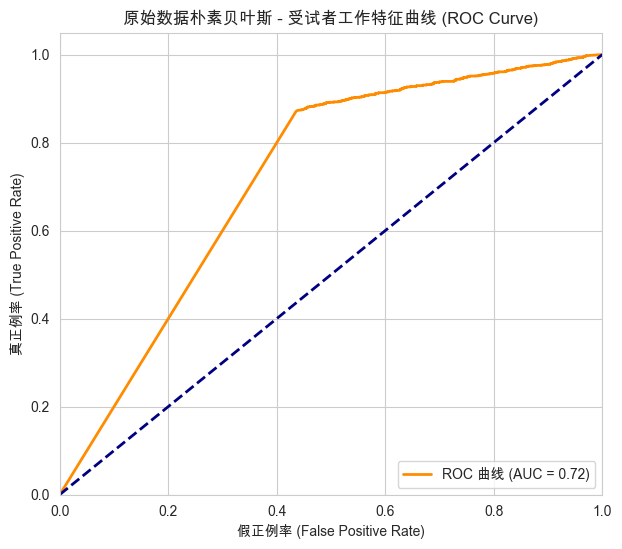


--- 2. 过采样 (RandomOverSampler) 朴素贝叶斯 ---


/opt/anaconda3/envs/my_ml_env/lib/python3.9/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/opt/anaconda3/envs/my_ml_env/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(



--- 过采样朴素贝叶斯 模型评估报告 ---
准确率 (Accuracy): 0.5952

分类报告 (Classification Report):
              precision    recall  f1-score   support

           0       0.91      0.45      0.60      4449
           1       0.43      0.90      0.59      2065

    accuracy                           0.60      6514
   macro avg       0.67      0.68      0.59      6514
weighted avg       0.76      0.60      0.60      6514


混淆矩阵 (Confusion Matrix):
 [[2013 2436]
 [ 201 1864]]

ROC AUC 分数: 0.7185


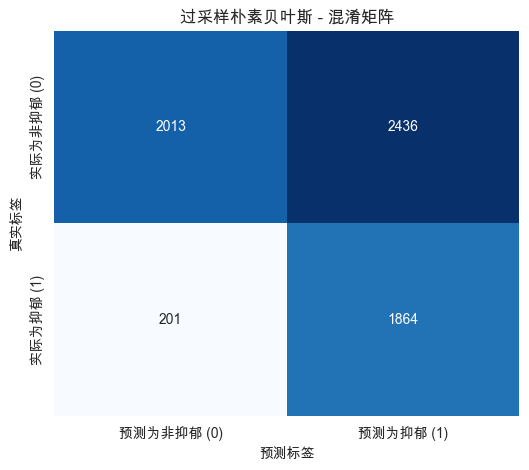

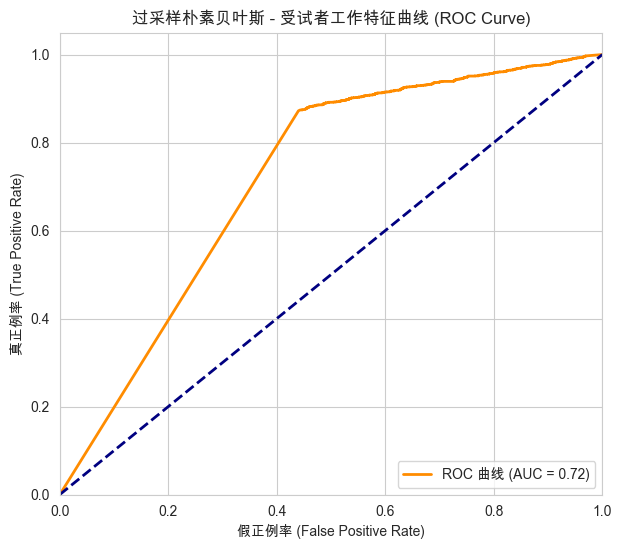


--- 3. 欠采样 (RandomUnderSampler) 朴素贝叶斯 ---


/opt/anaconda3/envs/my_ml_env/lib/python3.9/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/opt/anaconda3/envs/my_ml_env/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(



--- 欠采样朴素贝叶斯 模型评估报告 ---
准确率 (Accuracy): 0.5940

分类报告 (Classification Report):
              precision    recall  f1-score   support

           0       0.91      0.45      0.60      4449
           1       0.43      0.90      0.58      2065

    accuracy                           0.59      6514
   macro avg       0.67      0.68      0.59      6514
weighted avg       0.76      0.59      0.60      6514


混淆矩阵 (Confusion Matrix):
 [[2005 2444]
 [ 201 1864]]

ROC AUC 分数: 0.7180


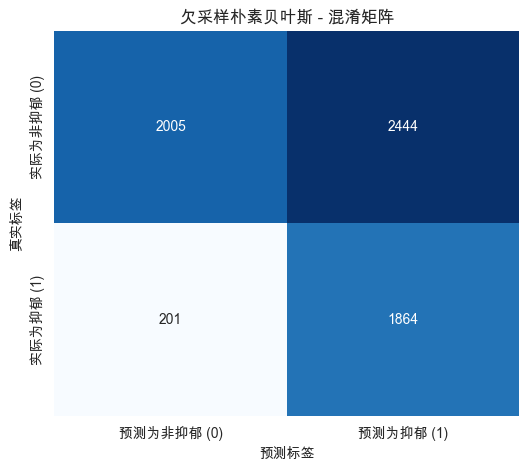

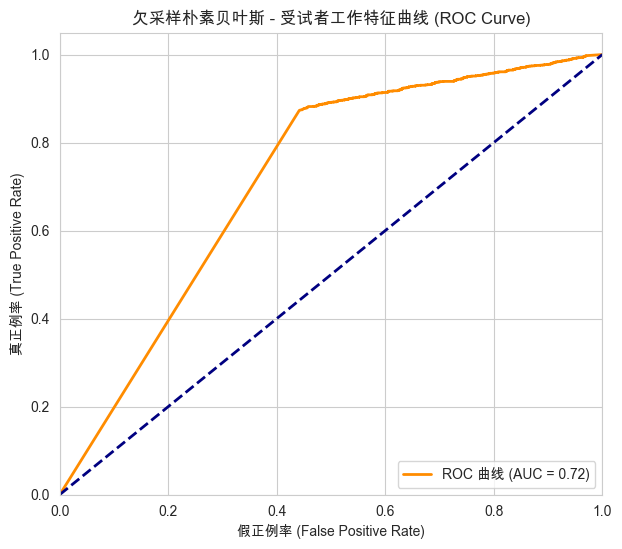


--- 4. SMOTE 朴素贝叶斯 ---


/opt/anaconda3/envs/my_ml_env/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(



--- SMOTE朴素贝叶斯 模型评估报告 ---
准确率 (Accuracy): 0.6409

分类报告 (Classification Report):
              precision    recall  f1-score   support

           0       0.90      0.53      0.67      4449
           1       0.46      0.88      0.61      2065

    accuracy                           0.64      6514
   macro avg       0.68      0.70      0.64      6514
weighted avg       0.76      0.64      0.65      6514


混淆矩阵 (Confusion Matrix):
 [[2366 2083]
 [ 256 1809]]

ROC AUC 分数: 0.7392


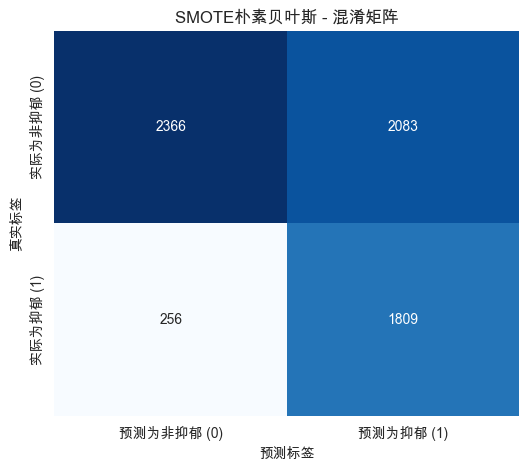

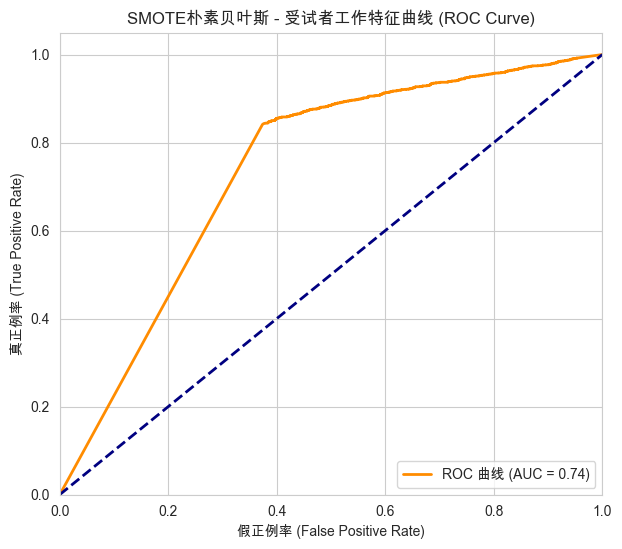


所有采样方法下的朴素贝叶斯建模与评估完成。


In [57]:
##模型二：朴素贝叶斯分类器

from sklearn.naive_bayes import GaussianNB

# --- 1. 原始数据 (不处理不平衡) 的朴素贝叶斯 ---
print("\n--- 1. 原始数据 朴素贝叶斯 ---")
model_nb_orig = GaussianNB()
model_nb_orig.fit(X_train, y_train)

y_pred_nb_orig = model_nb_orig.predict(X_test)
y_pred_proba_nb_orig = model_nb_orig.predict_proba(X_test)[:, 1]
evaluate_and_plot("原始数据朴素贝叶斯", y_test, y_pred_nb_orig, y_pred_proba_nb_orig)


# --- 2. 过采样 (RandomOverSampler) ---
print("\n--- 2. 过采样 (RandomOverSampler) 朴素贝叶斯 ---")
pipeline_nb_oversample = Pipeline([
    ('oversampler', RandomOverSampler(random_state=42)),
    ('classifier', GaussianNB())
])

pipeline_nb_oversample.fit(X_train, y_train)

y_pred_nb_oversample = pipeline_nb_oversample.predict(X_test)
y_pred_proba_nb_oversample = pipeline_nb_oversample.predict_proba(X_test)[:, 1]
evaluate_and_plot("过采样朴素贝叶斯", y_test, y_pred_nb_oversample, y_pred_proba_nb_oversample)


# --- 3. 欠采样 (RandomUnderSampler) ---
print("\n--- 3. 欠采样 (RandomUnderSampler) 朴素贝叶斯 ---")
pipeline_nb_undersample = Pipeline([
    ('undersampler', RandomUnderSampler(random_state=42)),
    ('classifier', GaussianNB())
])

pipeline_nb_undersample.fit(X_train, y_train)

y_pred_nb_undersample = pipeline_nb_undersample.predict(X_test)
y_pred_proba_nb_undersample = pipeline_nb_undersample.predict_proba(X_test)[:, 1]
evaluate_and_plot("欠采样朴素贝叶斯", y_test, y_pred_nb_undersample, y_pred_proba_nb_undersample)


# --- 4. SMOTE ---
print("\n--- 4. SMOTE 朴素贝叶斯 ---")
pipeline_nb_smote = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', GaussianNB())
])

pipeline_nb_smote.fit(X_train, y_train)

y_pred_nb_smote = pipeline_nb_smote.predict(X_test)
y_pred_proba_nb_smote = pipeline_nb_smote.predict_proba(X_test)[:, 1]
evaluate_and_plot("SMOTE朴素贝叶斯", y_test, y_pred_nb_smote, y_pred_proba_nb_smote)

print("\n所有采样方法下的朴素贝叶斯建模与评估完成。")


模型二：朴素贝叶斯分类器评估结果概述

和logistic模型相比，无论是原始朴素贝叶斯模型还是重采样策略下的衍生贝叶斯模型表现都比较差（结合后续分析，朴素贝叶斯模型在预测微博用户是否抑郁的任务上表现是最差的，所以在第四部分：特征重要性评估板块也没有对这一模型的建模结果作分析）。

最可能的原因是朴素贝叶斯模型需要的假设不成立，也就是特征之间不仅不是独立的，反而还可能是高度相关的。这种相关性应该是源于embedding之后，各维度之间的语义关系关联，例如，“抑郁”和“情绪低落”等词语在文本中常常同时出现；数值型数据之间也会存在关联，比如用户关注数和推文数之间也可能存在相关性；此外数据分布不符合正态分布可能也是导致模型表现较差的原因。

总之，朴素贝叶斯分类器可能不太适用于用户行为分析任务，尤其是带有文本（经embedding处理）的数据。



--- 1. 原始数据 (带 class_weight='balanced') 决策树 ---

--- 原始数据决策树 (Class Weight) 模型评估报告 ---
准确率 (Accuracy): 0.9220

分类报告 (Classification Report):
              precision    recall  f1-score   support

           0       0.95      0.94      0.94      4449
           1       0.87      0.89      0.88      2065

    accuracy                           0.92      6514
   macro avg       0.91      0.91      0.91      6514
weighted avg       0.92      0.92      0.92      6514


混淆矩阵 (Confusion Matrix):
 [[4169  280]
 [ 228 1837]]

ROC AUC 分数: 0.9424


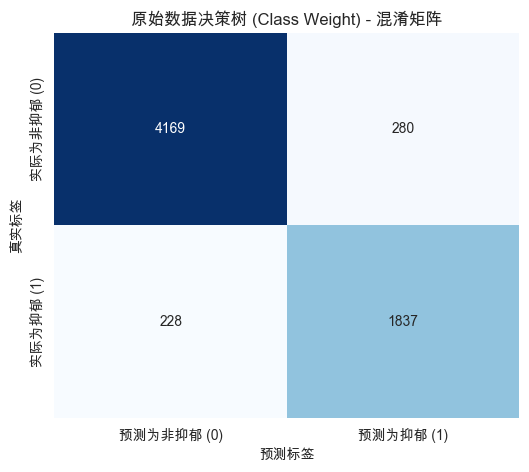

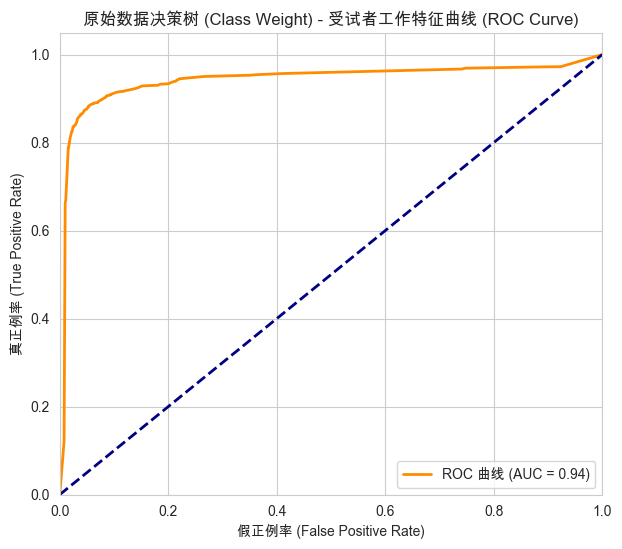


--- 2. 过采样 (RandomOverSampler) 决策树 ---


/opt/anaconda3/envs/my_ml_env/lib/python3.9/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/opt/anaconda3/envs/my_ml_env/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(



--- 过采样决策树 模型评估报告 ---
准确率 (Accuracy): 0.9180

分类报告 (Classification Report):
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      4449
           1       0.87      0.87      0.87      2065

    accuracy                           0.92      6514
   macro avg       0.90      0.91      0.91      6514
weighted avg       0.92      0.92      0.92      6514


混淆矩阵 (Confusion Matrix):
 [[4174  275]
 [ 259 1806]]

ROC AUC 分数: 0.9434


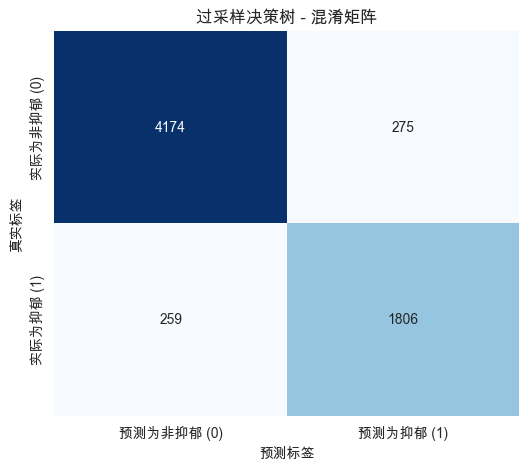

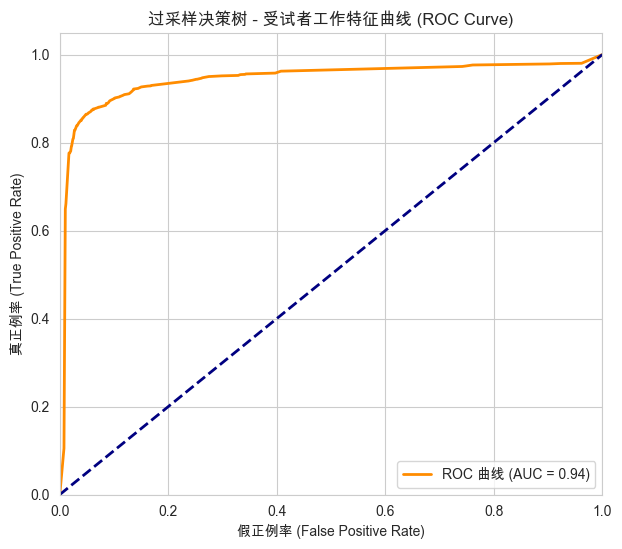


--- 3. 欠采样 (RandomUnderSampler) 决策树 ---


/opt/anaconda3/envs/my_ml_env/lib/python3.9/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/opt/anaconda3/envs/my_ml_env/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(



--- 欠采样决策树 模型评估报告 ---
准确率 (Accuracy): 0.9131

分类报告 (Classification Report):
              precision    recall  f1-score   support

           0       0.95      0.92      0.94      4449
           1       0.84      0.90      0.87      2065

    accuracy                           0.91      6514
   macro avg       0.89      0.91      0.90      6514
weighted avg       0.92      0.91      0.91      6514


混淆矩阵 (Confusion Matrix):
 [[4084  365]
 [ 201 1864]]

ROC AUC 分数: 0.9329


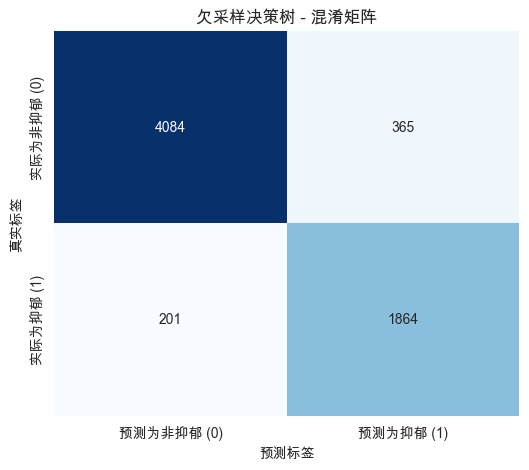

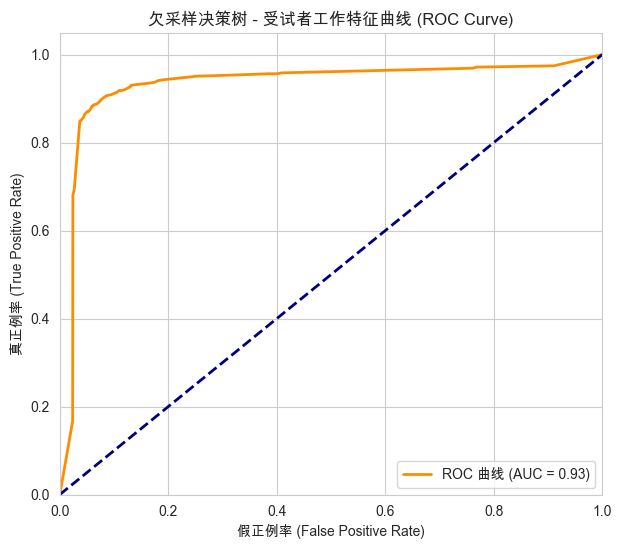


--- 4. SMOTE 决策树 ---


/opt/anaconda3/envs/my_ml_env/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(



--- SMOTE决策树 模型评估报告 ---
准确率 (Accuracy): 0.9145

分类报告 (Classification Report):
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      4449
           1       0.85      0.89      0.87      2065

    accuracy                           0.91      6514
   macro avg       0.90      0.91      0.90      6514
weighted avg       0.92      0.91      0.92      6514


混淆矩阵 (Confusion Matrix):
 [[4120  329]
 [ 228 1837]]

ROC AUC 分数: 0.9409


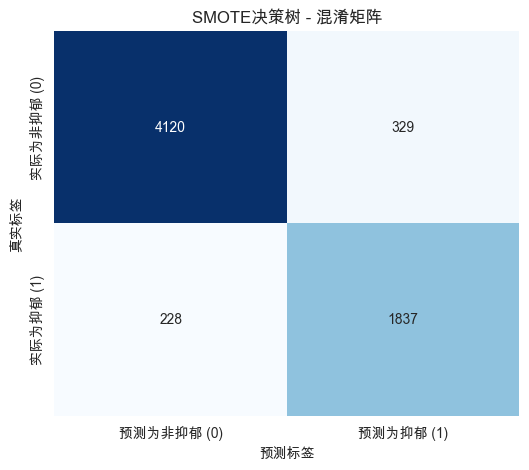

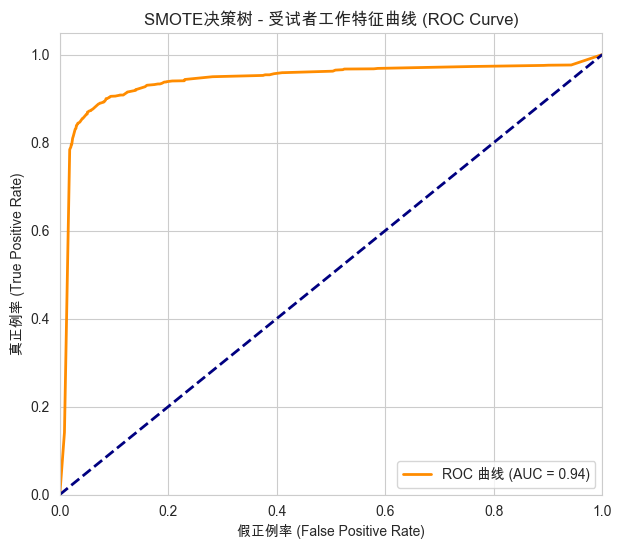


所有采样方法下的决策树建模与评估完成。


In [59]:
## 模型三：决策树

from sklearn.tree import DecisionTreeClassifier

# --- 1. 原始数据 (带 class_weight='balanced') 的决策树 ---
print("\n--- 1. 原始数据 (带 class_weight='balanced') 决策树 ---")
# 决策树参数设置：max_depth 防止过拟合，min_samples_leaf 保证叶节点样本数
model_dt_balanced = DecisionTreeClassifier(
    class_weight='balanced',
    max_depth=10,  # 限制树的深度，防止过拟合
    min_samples_leaf=5, # 叶节点所需最小样本数，防止过拟合
    random_state=42
)
model_dt_balanced.fit(X_train, y_train)

y_pred_dt_balanced = model_dt_balanced.predict(X_test)
y_pred_proba_dt_balanced = model_dt_balanced.predict_proba(X_test)[:, 1]
evaluate_and_plot("原始数据决策树 (Class Weight)", y_test, y_pred_dt_balanced, y_pred_proba_dt_balanced)


# --- 2. 过采样 (RandomOverSampler) ---
print("\n--- 2. 过采样 (RandomOverSampler) 决策树 ---")
pipeline_dt_oversample = Pipeline([
    ('oversampler', RandomOverSampler(random_state=42)),
    ('classifier', DecisionTreeClassifier(max_depth=10, min_samples_leaf=5, random_state=42))
])

pipeline_dt_oversample.fit(X_train, y_train)

y_pred_dt_oversample = pipeline_dt_oversample.predict(X_test)
y_pred_proba_dt_oversample = pipeline_dt_oversample.predict_proba(X_test)[:, 1]
evaluate_and_plot("过采样决策树", y_test, y_pred_dt_oversample, y_pred_proba_dt_oversample)


# --- 3. 欠采样 (RandomUnderSampler) ---
print("\n--- 3. 欠采样 (RandomUnderSampler) 决策树 ---")
pipeline_dt_undersample = Pipeline([
    ('undersampler', RandomUnderSampler(random_state=42)),
    ('classifier', DecisionTreeClassifier(max_depth=10, min_samples_leaf=5, random_state=42))
])

pipeline_dt_undersample.fit(X_train, y_train)

y_pred_dt_undersample = pipeline_dt_undersample.predict(X_test)
y_pred_proba_dt_undersample = pipeline_dt_undersample.predict_proba(X_test)[:, 1]
evaluate_and_plot("欠采样决策树", y_test, y_pred_dt_undersample, y_pred_proba_dt_undersample)


# --- 4. SMOTE ---
print("\n--- 4. SMOTE 决策树 ---")
pipeline_dt_smote = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', DecisionTreeClassifier(max_depth=10, min_samples_leaf=5, random_state=42))
])

pipeline_dt_smote.fit(X_train, y_train)

y_pred_dt_smote = pipeline_dt_smote.predict(X_test)
y_pred_proba_dt_smote = pipeline_dt_smote.predict_proba(X_test)[:, 1]
evaluate_and_plot("SMOTE决策树", y_test, y_pred_dt_smote, y_pred_proba_dt_smote)

print("\n所有采样方法下的决策树建模与评估完成。")


模型三：决策树评估结果概述

原始模型（带class_weight='balanced')在测试集上的总体表现良好，获得了 0.9220 的准确率。

模型取得了令人满意的 ROC AUC 分数：0.9424，表明其在区分正负样本方面具有较强的能力。

对多数类 (0) 的表现：模型对多数类 (0) 的识别能力非常强，精确率和召回率均达到了 0.90 以上（精确率 0.95，召回率 0.94）。

对少数类 (1) 的表现：经class_weight='balanced'设置的模型表现出不错的识别能力。其精确率为 0.87，意味着当模型预测为类别 1 时，有 87% 是正确的。召回率为 0.89，表示模型成功识别出了 89% 的真实类别 1 样本。F1-Score 达到 0.88，说明在精确率和召回率之间取得了较好的平衡。

与前面的分析流程一致，分别使用过采样、欠采样、smote方法进行数据增强后建模，探索重抽样策略的可行性。

但从AUC分数来看，只有过采样策略相比原模型有微弱提升；并且从少数类 (1) 的f1分数看，三个衍生模型对于少数类的识别效果不如class_weight='balanced'设置的模型。

整体而言，决策树模型（非线性模型）相比logistic模型（线性模型）各方面都有微弱的优势。因为决策树模型通过一系列基于特征值的简单“是/否”问题（即树的节点分裂）来逐步划分数据空间。这种分层、递归的划分方式使其能更好地适应数据中复杂的非线性模式和特征间的交互作用，并且可以自动发现和利用特征之间的交互。在预测微博用户是否抑郁这种可能涉及多方面非线性特征组合的任务上，决策树的这种能力使其能够略胜一筹。



--- 1. 原始数据 (带 StandardScaler) LinearSVC ---

--- 原始数据LinearSVC 模型评估报告 ---
准确率 (Accuracy): 0.9054

分类报告 (Classification Report):
              precision    recall  f1-score   support

           0       0.92      0.95      0.93      4449
           1       0.88      0.82      0.85      2065

    accuracy                           0.91      6514
   macro avg       0.90      0.88      0.89      6514
weighted avg       0.90      0.91      0.90      6514


混淆矩阵 (Confusion Matrix):
 [[4210  239]
 [ 377 1688]]

ROC AUC 分数: 0.9373


/opt/anaconda3/envs/my_ml_env/lib/python3.9/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


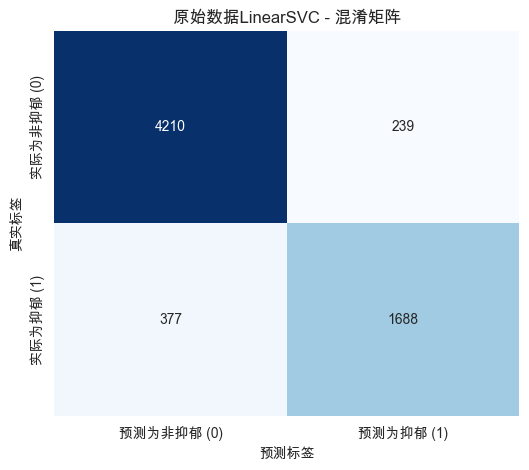

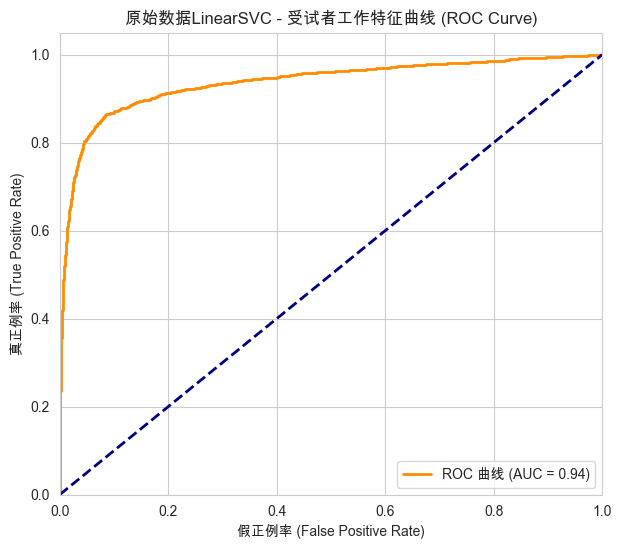

In [21]:
##模型四：支持向量机（Linear SVC）

# --- 1. 原始数据 (带缩放) 的 LinearSVC ---
print("\n--- 1. 原始数据 (带 StandardScaler) LinearSVC ---")
# LinearSVC 默认没有 predict_proba，但有 decision_function 可以用于 ROC AUC
pipeline_svm_orig = Pipeline([
    ('scaler', StandardScaler()), 
    ('classifier', LinearSVC(penalty='l2', C=0.01, dual=True, max_iter=1000, random_state=42)) # dual=True 适用于 n_samples > n_features
])

pipeline_svm_orig.fit(X_train, y_train)

y_pred_svm_orig = pipeline_svm_orig.predict(X_test)
y_scores_svm_orig = pipeline_svm_orig.decision_function(X_test) # 获取决策分数
evaluate_and_plot_svm("原始数据LinearSVC", y_test, y_pred_svm_orig, y_scores_svm_orig)


--- 2. 过采样 (RandomOverSampler) LinearSVC ---


/opt/anaconda3/envs/my_ml_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/my_ml_env/lib/python3.9/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/opt/anaconda3/envs/my_ml_env/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(



--- 过采样LinearSVC 模型评估报告 ---
准确率 (Accuracy): 0.8918

分类报告 (Classification Report):
              precision    recall  f1-score   support

           0       0.93      0.91      0.92      4449
           1       0.81      0.86      0.83      2065

    accuracy                           0.89      6514
   macro avg       0.87      0.88      0.88      6514
weighted avg       0.89      0.89      0.89      6514


混淆矩阵 (Confusion Matrix):
 [[4035  414]
 [ 291 1774]]

ROC AUC 分数: 0.9369


/opt/anaconda3/envs/my_ml_env/lib/python3.9/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


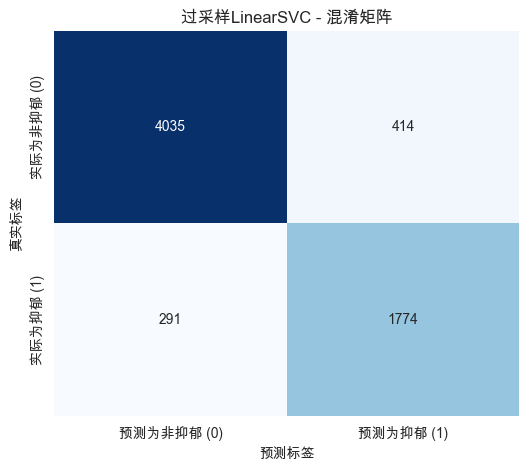

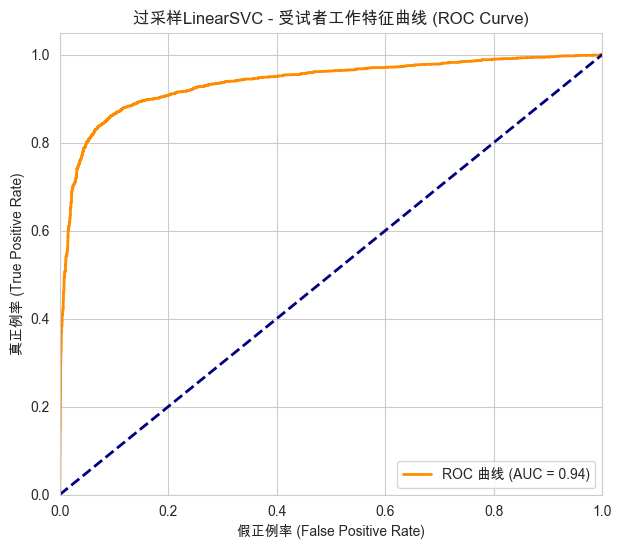


--- 3. 欠采样 (RandomUnderSampler) LinearSVC ---


/opt/anaconda3/envs/my_ml_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/my_ml_env/lib/python3.9/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/opt/anaconda3/envs/my_ml_env/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(



--- 欠采样LinearSVC 模型评估报告 ---
准确率 (Accuracy): 0.8878

分类报告 (Classification Report):
              precision    recall  f1-score   support

           0       0.94      0.90      0.92      4449
           1       0.80      0.87      0.83      2065

    accuracy                           0.89      6514
   macro avg       0.87      0.88      0.87      6514
weighted avg       0.89      0.89      0.89      6514


混淆矩阵 (Confusion Matrix):
 [[3995  454]
 [ 277 1788]]

ROC AUC 分数: 0.9376


/opt/anaconda3/envs/my_ml_env/lib/python3.9/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


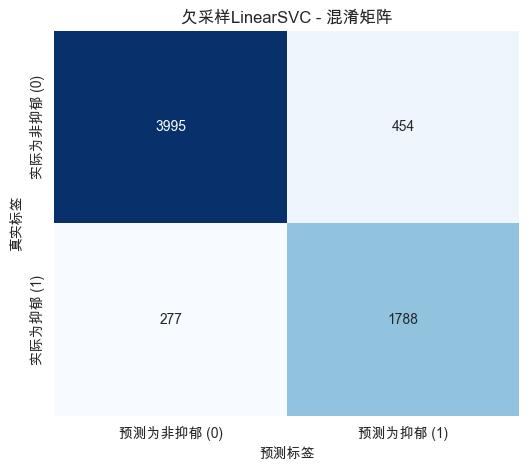

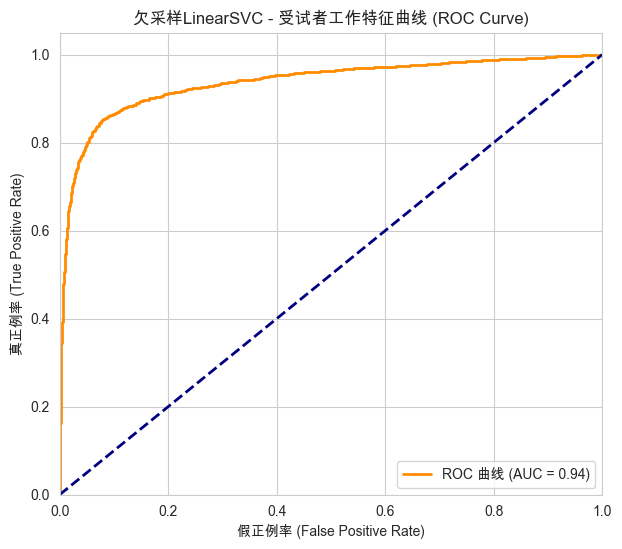


--- 4. SMOTE LinearSVC ---


/opt/anaconda3/envs/my_ml_env/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(



--- SMOTE LinearSVC 模型评估报告 ---
准确率 (Accuracy): 0.8938

分类报告 (Classification Report):
              precision    recall  f1-score   support

           0       0.93      0.91      0.92      4449
           1       0.82      0.86      0.84      2065

    accuracy                           0.89      6514
   macro avg       0.87      0.88      0.88      6514
weighted avg       0.90      0.89      0.89      6514


混淆矩阵 (Confusion Matrix):
 [[4054  395]
 [ 297 1768]]

ROC AUC 分数: 0.9369


/opt/anaconda3/envs/my_ml_env/lib/python3.9/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


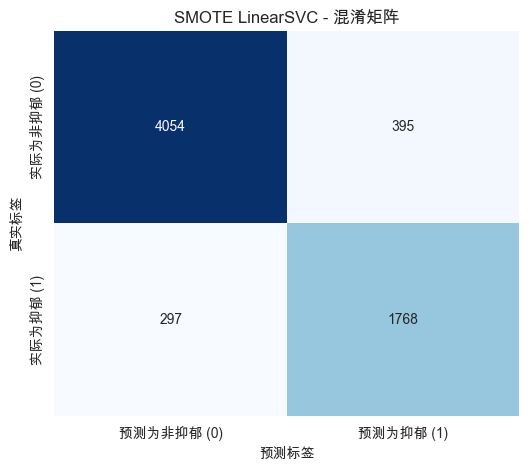

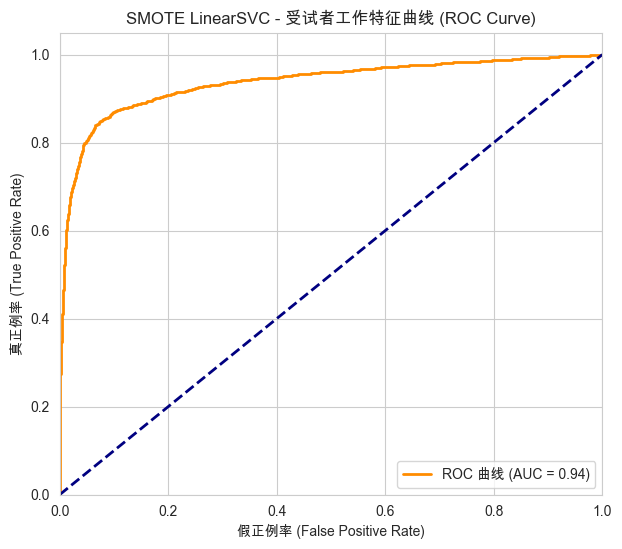


所有采样方法下的支持向量机 (LinearSVC) 建模与评估完成。


In [19]:
# --- 2. 过采样 (RandomOverSampler) ---
print("\n--- 2. 过采样 (RandomOverSampler) LinearSVC ---")
pipeline_svm_oversample = Pipeline([
    ('scaler', StandardScaler()),
    ('oversampler', RandomOverSampler(random_state=42)),
    ('classifier', LinearSVC(penalty='l2', C=0.01, dual=True, max_iter=1000, random_state=42))
])

pipeline_svm_oversample.fit(X_train, y_train)

y_pred_svm_oversample = pipeline_svm_oversample.predict(X_test)
y_scores_svm_oversample = pipeline_svm_oversample.decision_function(X_test)
evaluate_and_plot_svm("过采样LinearSVC", y_test, y_pred_svm_oversample, y_scores_svm_oversample)


# --- 3. 欠采样 (RandomUnderSampler) ---
print("\n--- 3. 欠采样 (RandomUnderSampler) LinearSVC ---")
pipeline_svm_undersample = Pipeline([
    ('scaler', StandardScaler()),
    ('undersampler', RandomUnderSampler(random_state=42)),
    ('classifier', LinearSVC(penalty='l2', C=0.01, dual=True, max_iter=1000, random_state=42))
])

pipeline_svm_undersample.fit(X_train, y_train)

y_pred_svm_undersample = pipeline_svm_undersample.predict(X_test)
y_scores_svm_undersample = pipeline_svm_undersample.decision_function(X_test)
evaluate_and_plot_svm("欠采样LinearSVC", y_test, y_pred_svm_undersample, y_scores_svm_undersample)


# --- 4. SMOTE ---
print("\n--- 4. SMOTE LinearSVC ---")
pipeline_svm_smote = Pipeline([
    ('scaler', StandardScaler()), # SMOTE是基于距离的，所以缩放应在SMOTE之前
    ('smote', SMOTE(random_state=42)),
    ('classifier', LinearSVC(penalty='l2', C=0.01, dual=True, max_iter=1000, random_state=42))
])

pipeline_svm_smote.fit(X_train, y_train)

y_pred_svm_smote = pipeline_svm_smote.predict(X_test)
y_scores_svm_smote = pipeline_svm_smote.decision_function(X_test)
evaluate_and_plot_svm("SMOTE LinearSVC", y_test, y_pred_svm_smote, y_scores_svm_smote)

print("\n所有采样方法下的支持向量机 (LinearSVC) 建模与评估完成。")


模型四：支持向量机评估结果概述

原始模型（带缩放)在测试集上的总体表现良好，获得了 0.9054 的准确率。

模型取得了令人满意的 ROC AUC 分数：0.9373，表明其在区分正负样本方面具有较强的能力。

对多数类 (0) 的表现：模型对多数类 (0) 的识别能力非常强，精确率和召回率均达到了 0.90 以上（精确率 0.92，召回率 0.95）。

对少数类 (1) 的表现：原始LinearSVC模型表现出不错的识别能力。其精确率为 0.88，意味着当模型预测为类别 1 时，有 88% 是正确的。召回率为 0.82，表示模型成功识别出了 82% 的真实类别 1 样本。F1-Score 达到 0.85，说明在精确率和召回率之间取得了较好的平衡。

与前面的分析流程一致，分别使用过采样、欠采样、smote方法进行数据增强后建模，探索重抽样策略的可行性。

但从AUC分数来看，只有欠采样策略相比原模型有微弱提升；并且从少数类 (1) 的f1分数看，三个衍生模型对于少数类的识别效果不如原模型。

整体而言，支持向量机（非线性模型）和logistic模型（线性模型）效果相近。

至此完成了所有基线模型的建模与评估，总体而言，决策树模型 > logistic回归模型 = 支持向量机模型 >> 朴素贝叶斯分类器模型。

下面使用集成学习方法进行建模：选择随机森林（集成学习中bagging方法的代表）和 XGBoost（集成学习中的boosting方法代表），并比较二者相比基线模型的优势。



--- 随机森林 (带 StandardScaler, class_weight='balanced') ---

--- 随机森林 (Class Weight) 模型评估报告 ---
准确率 (Accuracy): 0.9169

分类报告 (Classification Report):
              precision    recall  f1-score   support

           0       0.92      0.97      0.94      4449
           1       0.92      0.81      0.86      2065

    accuracy                           0.92      6514
   macro avg       0.92      0.89      0.90      6514
weighted avg       0.92      0.92      0.92      6514


混淆矩阵 (Confusion Matrix):
 [[4307  142]
 [ 399 1666]]

ROC AUC 分数: 0.9581


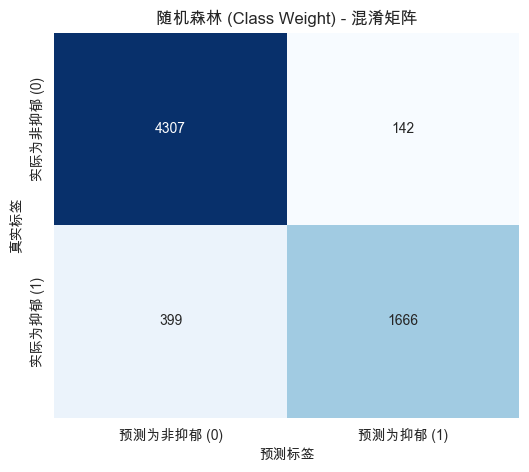

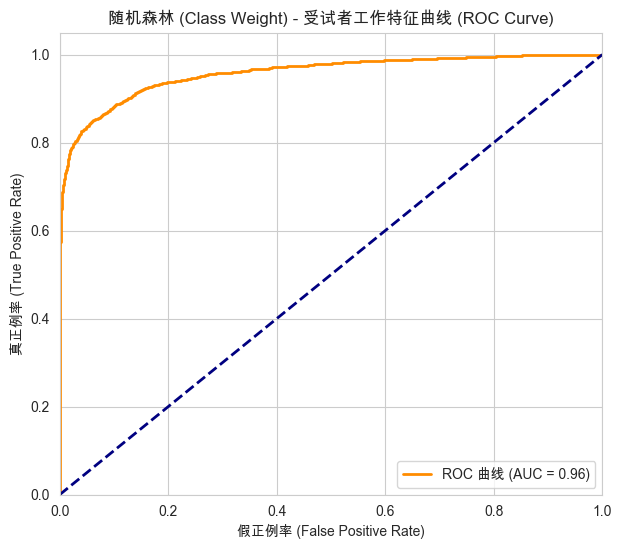


随机森林建模与评估完成。


In [25]:
##模型五：随机森林（集成学习中bagging方法的代表）

from sklearn.ensemble import RandomForestClassifier

# --- 仅使用 class_weight='balanced' 的随机森林 ---
print("\n--- 随机森林 (带 StandardScaler, class_weight='balanced') ---")
pipeline_rf = Pipeline([
    ('scaler', StandardScaler()), # 对RF非必需，但保持管道一致性，且不影响性能
    ('classifier', RandomForestClassifier(n_estimators=200, # 树的数量，可根据需要调整
                                        max_depth=10, # 每棵树的最大深度，防止过拟合
                                        random_state=42,
                                        class_weight='balanced', # **核心：通过权重平衡类别**
                                        n_jobs=-1 # 使用所有CPU核心加速
                                       )) 
])

pipeline_rf.fit(X_train, y_train) 

y_pred_rf = pipeline_rf.predict(X_test)
y_pred_proba_rf = pipeline_rf.predict_proba(X_test)[:, 1]
evaluate_and_plot("随机森林 (Class Weight)", y_test, y_pred_rf, y_pred_proba_rf)


print("\n随机森林建模与评估完成。")


模型五：随机森林评估结果概述

模型在测试集上的总体表现良好，获得了 0.9169 的准确率。

模型取得了令人满意的 ROC AUC 分数：0.9581，表明其在区分正负样本方面具有较强的能力。

对多数类 (0) 的表现：模型对多数类 (0) 的识别能力非常强，精确率和召回率均达到了 0.90 以上（精确率 0.92，召回率 0.97）。

对少数类 (1) 的表现：精确率为 0.92，意味着当模型预测为类别 1 时，有 92% 是正确的。召回率为 0.81，表示模型成功识别出了 81% 的真实类别 1 样本。F1-Score 达到 0.86，说明在精确率和召回率之间取得了较好的平衡。

总体而言随机森林相比单棵决策树并没有想象中的明显提升。可能的原因有：单棵决策树的基线性能已相当不错；数据集内在复杂性或许未达到极限；默认参数可能未充分发挥潜力（树的数量（n_estimators）、每棵树在训练时使用的特征子集比例（max_features 或 colsample_bytree）、树的深度（max_depth）等）。

尽管随机森林在本研究中未能带来飞跃性的提升，但其作为集成学习中的 Bagging 方法代表，通过并行构建多棵树并减少方差，依然展现了其作为强大集成模型的价值。

然而，在集成学习的另一大类——Boosting 方法中，模型通过顺序构建弱学习器，并让后续学习器重点关注并修正前面学习器犯的错误，从而实现更强大的性能。这种迭代式的错误修正机制往往能构建出偏差和方差都更低、准确率更高的模型。

接下来，使用XGBoost方法进行建模，并观察模型的效果如何。


计算得到的 scale_pos_weight: 2.15

--- XGBoost (带 StandardScaler, scale_pos_weight) ---


/opt/anaconda3/envs/my_ml_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:21:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



--- XGBoost (Scale Pos Weight) 模型评估报告 ---
准确率 (Accuracy): 0.9549

分类报告 (Classification Report):
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      4449
           1       0.95      0.91      0.93      2065

    accuracy                           0.95      6514
   macro avg       0.95      0.94      0.95      6514
weighted avg       0.95      0.95      0.95      6514


混淆矩阵 (Confusion Matrix):
 [[4347  102]
 [ 192 1873]]

ROC AUC 分数: 0.9858


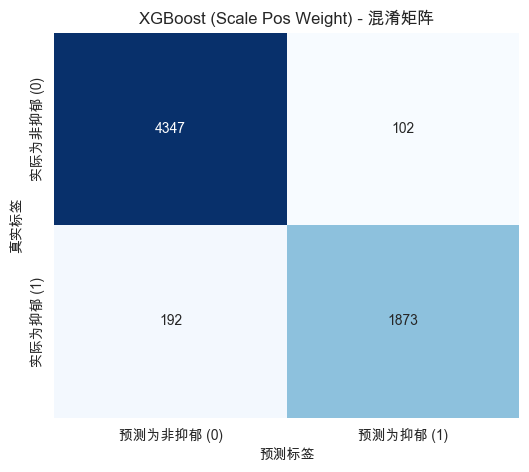

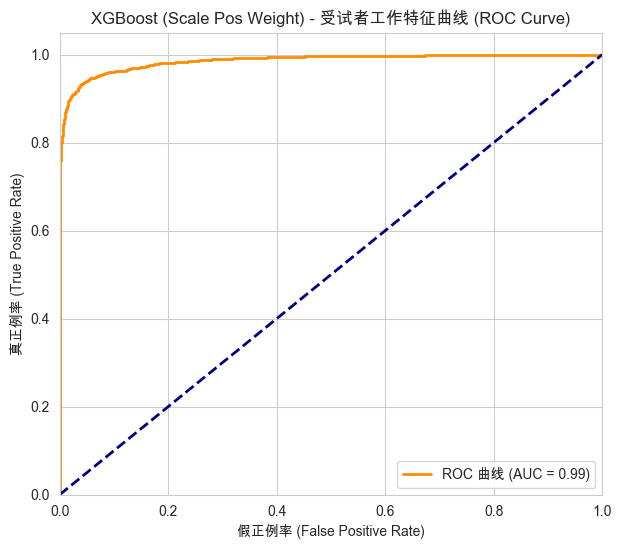


XGBoost 建模与评估完成。


In [31]:
##模型六：XGBoost（集成学习中的boosting方法代表）

import xgboost as xgb

# --- 计算 scale_pos_weight 参数以处理类别不平衡 ---
# 少数类 (1) 的样本数量
count_positive = y_train.sum()
# 多数类 (0) 的样本数量
count_negative = len(y_train) - count_positive
# scale_pos_weight = 负样本数量 / 正样本数量
scale_pos_weight_value = count_negative / count_positive
print(f"计算得到的 scale_pos_weight: {scale_pos_weight_value:.2f}")

# --- XGBoost 模型 (使用 scale_pos_weight 处理不平衡) ---
print("\n--- XGBoost (带 scale_pos_weight) ---")
pipeline_xgb = Pipeline([
    ('scaler', StandardScaler()), 
    ('classifier', xgb.XGBClassifier(objective='binary:logistic', # 二分类逻辑回归，输出概率
                                     n_estimators=200, # 树的数量，可根据需要调整
                                     learning_rate=0.1, # 学习率
                                     max_depth=5, # 每棵树的最大深度
                                     subsample=0.8, # 训练每棵树时，随机采样的样本比例
                                     colsample_bytree=0.8, # 训练每棵树时，随机采样的特征比例
                                     gamma=0.1, # 最小损失下降值，用于控制树的剪枝
                                     random_state=42,
                                     n_jobs=-1, # 使用所有CPU核心加速
                                     scale_pos_weight=scale_pos_weight_value, # 核心：通过权重平衡类别
                                     enable_categorical=True, 
                                     use_label_encoder=False 
                                    )) 
])

pipeline_xgb.fit(X_train, y_train) 

y_pred_xgb = pipeline_xgb.predict(X_test)
y_pred_proba_xgb = pipeline_xgb.predict_proba(X_test)[:, 1]
evaluate_and_plot("XGBoost (Scale Pos Weight)", y_test, y_pred_xgb, y_pred_proba_xgb)

print("\nXGBoost 建模与评估完成。")


模型六：XGBoost评估结果概述

模型在测试集上的总体表现良好，获得了 0.9549 的准确率。

模型取得了令人满意的 ROC AUC 分数：0.9858，表明其在区分正负样本方面具有较强的能力。

对多数类 (0) 的表现：模型对多数类 (0) 的识别能力非常强，精确率和召回率均达到了 0.90 以上（精确率 0.96，召回率 0.98）。

对少数类 (1) 的表现：精确率为 0.95，意味着当模型预测为类别 1 时，有 95% 是正确的。召回率为 0.91，表示模型成功识别出了 91% 的真实类别 1 样本。（这是XGBoost相比之前所有模型的明显优势），F1-Score 达到 0.95，说明在精确率和召回率之间取得了较好的平衡。

XGBoost 凭借其独特的迭代错误修正机制、强大的内置正则化能力，以及对类别不平衡问题的直接处理方式，成功克服了之前模型（如 Logistic 回归、支持向量机、甚至随机森林）在处理复杂非线性关系、防止过拟合和尤其是在识别少数类样本方面的局限。它不仅能够深入挖掘数据中潜在的抑郁指标模式，还能够在高精度地捕获多数类的同时，显著提升对关键少数类（抑郁用户）的召回率和 F1 分数，这使得它成为本次任务中迄今为止表现最佳、最具实际应用价值的模型。



为探究深度学习方法是否会有优于传统机器学习模型的表现，构建当下最流行的模型之一——transformer模型，用于该分类任务中


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 profile_input (InputLayer)     [(None,)]            0           []                               
                                                                                                  
 tweets_input (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 text_vectorization_6 (TextVect  (None, 128)         0           ['profile_input[0][0]']          
 orization)                                                                                       
                                                                                                  
 text_vectorization_7 (TextVect  (None, 256)         0           ['tweets_input[0][0]']     

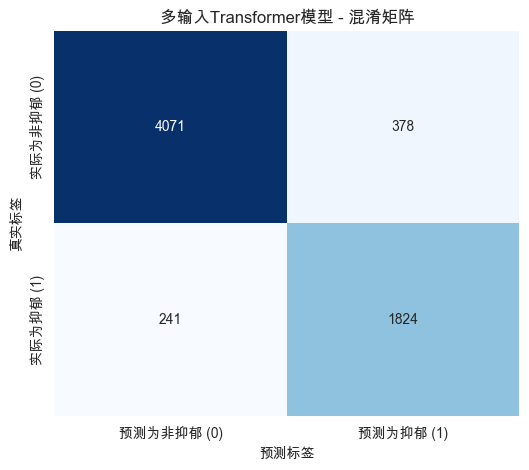

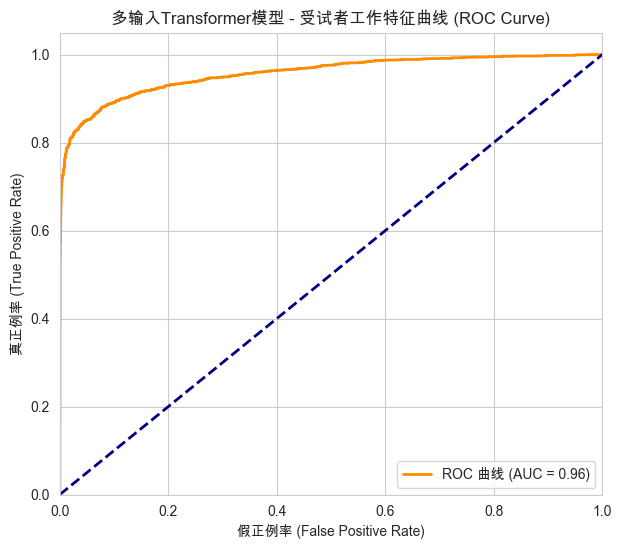

In [121]:
### 第三部分：深度学习分类效果评估——transformer模型

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D, Concatenate

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight

## 原始transformer模型

# --- 1. 数据加载与准备 ---

# 定义特征列和目标列
text_cols = ['profile', 'all_tweets_content']
numerical_cols = [
    'gender_女', 'gender_男', 'num_of_follower_log', 
    'num_of_following_log', 'all_tweet_count_log', 
    'original_tweet_count_log', 'repost_tweet_count_log'
]
target_col = 'label'

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(
    data[text_cols + numerical_cols], data[target_col], 
    test_size=0.2, random_state=42, stratify=data[target_col]
)

# 数值特征标准化
scaler = StandardScaler()
X_train_numerical_scaled = scaler.fit_transform(X_train[numerical_cols])
X_test_numerical_scaled = scaler.transform(X_test[numerical_cols])

# 转换为 Keras 友好格式 (NumPy arrays)
X_train_profile = X_train['profile'].to_numpy()
X_test_profile = X_test['profile'].to_numpy()
X_train_tweets = X_train['all_tweets_content'].to_numpy()
X_test_tweets = X_test['all_tweets_content'].to_numpy()
X_train_numerical_np = X_train_numerical_scaled.astype('float32')
X_test_numerical_np = X_test_numerical_scaled.astype('float32')
y_train_np = y_train.astype('float32').to_numpy()
y_test_np = y_test.astype('float32').to_numpy()

# 计算类别权重
class_weights_array = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_np), y=y_train_np)
class_weight_dict = dict(enumerate(class_weights_array))


# --- 2. Transformer 编码器块定义 ---
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    x = LayerNormalization(epsilon=1e-6)(x + inputs) # Add & Norm
    ffn_output = Dense(ff_dim, activation="relu")(x)
    ffn_output = Dense(inputs.shape[-1])(ffn_output) # Match input dim for residual
    return LayerNormalization(epsilon=1e-6)(ffn_output + x) # Add & Norm


# --- 3. Keras 多输入模型构建 ---
VOCAB_SIZE = 20000 
EMBEDDING_DIM = 128 

# Profile 文本输入分支
profile_input = Input(shape=(), dtype=tf.string, name='profile_input')
profile_vectorize_layer = layers.TextVectorization(
    max_tokens=VOCAB_SIZE, output_mode='int', output_sequence_length=128 # 序列长度
)
profile_vectorize_layer.adapt(X_train_profile)
profile_vectors = profile_vectorize_layer(profile_input)
profile_embedding = layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM, name='profile_embedding')(profile_vectors)
profile_transformer_output = transformer_encoder(profile_embedding, head_size=EMBEDDING_DIM, num_heads=4, ff_dim=EMBEDDING_DIM*2, dropout=0.1)
profile_pooled = GlobalAveragePooling1D(name='profile_pooled')(profile_transformer_output)


# All Tweets Content 文本输入分支
tweets_input = Input(shape=(), dtype=tf.string, name='tweets_input')
tweets_vectorize_layer = layers.TextVectorization(
    max_tokens=VOCAB_SIZE, output_mode='int', output_sequence_length=256 # 序列长度
)
tweets_vectorize_layer.adapt(X_train_tweets)
tweets_vectors = tweets_vectorize_layer(tweets_input)
tweets_embedding = layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM, name='tweets_embedding')(tweets_vectors)
tweets_transformer_output = transformer_encoder(tweets_embedding, head_size=EMBEDDING_DIM, num_heads=4, ff_dim=EMBEDDING_DIM*2, dropout=0.1)
tweets_pooled = GlobalAveragePooling1D(name='tweets_pooled')(tweets_transformer_output)


# 数值/二分变量输入分支
numerical_input = Input(shape=(len(numerical_cols),), name='numerical_input')


# 合并所有特征
combined_features = Concatenate(name='combined_features')([
    profile_pooled, 
    tweets_pooled, 
    numerical_input
])

# 分类头
x = Dense(128, activation='relu')(combined_features)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
output_layer = Dense(1, activation='sigmoid', name='output_prediction')(x)

# 构建完整模型
model = Model(inputs=[profile_input, tweets_input, numerical_input], outputs=output_layer)

model.summary()


# --- 4. 编译模型 ---
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', 
                        tf.keras.metrics.Precision(name='precision'),
                        tf.keras.metrics.Recall(name='recall'),
                        tf.keras.metrics.AUC(name='auc')])

# --- 5. 训练模型 ---
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_auc', patience=10, mode='max', restore_best_weights=True, verbose=1
)

# 准备训练数据字典
train_data_dict = {
    'profile_input': X_train_profile,
    'tweets_input': X_train_tweets,
    'numerical_input': X_train_numerical_np
}

history = model.fit(train_data_dict, y_train_np,
                    epochs=50, 
                    batch_size=32, 
                    validation_split=0.2, 
                    class_weight=class_weight_dict, 
                    callbacks=[early_stopping], 
                    verbose=1)


# --- 6. 评估模型 ---
# 准备测试数据字典
test_data_dict = {
    'profile_input': X_test_profile,
    'tweets_input': X_test_tweets,
    'numerical_input': X_test_numerical_np
}

loss, accuracy, precision, recall, auc_score = model.evaluate(test_data_dict, y_test_np, verbose=0)

print(f"\n测试集损失 (Loss): {loss:.4f}")
print(f"测试集准确率 (Accuracy): {accuracy:.4f}")
print(f"测试集精确率 (Precision): {precision:.4f}")
print(f"测试集召回率 (Recall): {recall:.4f}")
print(f"测试集AUC分数 (AUC): {auc_score:.4f}")

# 预测结果
y_pred_proba_dl = model.predict(test_data_dict).flatten()
y_pred_dl = (y_pred_proba_dl > 0.5).astype(int)

evaluate_and_plot("多输入Transformer模型", y_test_np, y_pred_dl, y_pred_proba_dl)


为了充分利用文本数据的复杂语义信息，构建了一个基于 Transformer 编码器块的多输入深度学习模型。该模型结合了深度学习在特征学习方面的强大能力和 Transformer 架构在处理序列数据上的优势。由于transformer模型可以处理纯文本数据（事实上，模型本身就会对文本进行词嵌入，另外还有别的处理，例如截断+填充保证文本长度一致），所以这里不采用之前经过词嵌入处理的文本数据，而是采用原文本进行训练。

1. 模型结构的简要解读：

   模型的关键组件包括：

    文本输入分支 (Profile 和 All Tweets Content)：
    
    文本向量化层 (TextVectorization)：首先，原始文本字符串被转换为固定长度的整数序列，其中每个整数代表词汇表中一个词的索引。这一步将非结构化的文本数据转换为模型可以处理的数值形式。
    max_tokens: 限制词汇表的大小，这里设置为 20000，意味着模型将重点关注训练数据中最常见的 20000 个词。
    output_sequence_length: 定义了每个文本序列的固定长度，profile 为 128，tweets 为 256。过长的序列会被截断，过短的会被填充，以确保输入维度一致。
    嵌入层 (Embedding)：整数序列随后通过嵌入层转换为稠密的实数向量。每个词索引被映射到一个 EMBEDDING_DIM (128) 维的向量空间中。这些嵌入向量能够捕捉词语的语义信息和上下文关系，语义相似的词语会有相近的向量表示。
    Transformer 编码器块 (transformer_encoder)：这是文本处理的核心。嵌入后的序列被送入 Transformer 编码器。Transformer 凭借其自注意力机制 (Multi-Head Attention)，能够捕捉序列中任意两个词之间的依赖关系，无论它们在文本中的距离多远，从而比传统的 RNN 或 CNN 更好地理解长距离上下文。
    全局平均池化层 (GlobalAveragePooling1D)：Transformer 编码器输出的是一个序列，为了将其转化为固定维度的向量以便与其它特征合并，使用了全局平均池化，对序列维度进行平均，得到一个代表整个文本内容的单一向量。
   
    数值/二分变量输入分支 (numerical_input)：
    
    这部分数据直接作为模型的输入，通常会经过标准化等预处理步骤（尽管在 Keras 模型内部没有显式显示，但在实际数据准备中通常会进行），以确保数值范围的一致性，防止某些特征的数值过大影响模型训练。
   
    特征合并层 (Concatenate)：
    
    来自 Profile 文本的池化向量、All Tweets Content 文本的池化向量以及数值/二分变量的输入，在这一层被拼接起来，形成一个包含所有模态信息的综合特征向量。
   
    分类头 (Dense 和 Dropout 层)：
    
    合并后的特征向量被送入一个由全连接（Dense）层和 Dropout 层组成的神经网络。这些层负责学习最终的非线性映射，将综合特征向量转化为预测概率。
    Dropout 层在训练过程中随机关闭一部分神经元，以减少模型对训练数据的依赖，从而防止过拟合。
    最终的输出层是一个单一神经元，使用 sigmoid 激活函数，输出介于 0 到 1 之间的概率值，表示用户是抑郁的概率。
   
3. 重要参数的意义解读：

   在模型构建和训练过程中，多个参数的选择对模型的性能和行为至关重要：

    VOCAB_SIZE (20000)：
    
    意义：指定了文本向量化层将考虑的最大词汇量。这意味着模型只会学习训练数据中出现频率最高的 20000 个词的嵌入。
    影响：较小的 VOCAB_SIZE 会丢失罕见词的信息，但能减少模型复杂度和内存消耗；较大的 VOCAB_SIZE 能包含更多词汇，但可能引入噪声或增加训练难度。
   
    EMBEDDING_DIM (128)：
    
    意义：定义了词嵌入向量的维度。每个词在模型内部都由一个 128 维的向量表示。
    影响：更高的维度能捕捉更丰富的词义信息，但需要更多数据进行训练，且可能增加过拟合风险；较低维度则相反。128是一个在平衡表达能力和模型复杂度之间常用的选择。
   
    output_sequence_length (Profile: 128, Tweets: 256)：
    
    意义：规定了经过 TextVectorization 后输出文本序列的固定长度。
    影响：所有文本输入都将被裁剪或填充到这个长度。如果设置过短，可能会截断重要信息；如果过长，则会增加计算成本和填充的冗余信息。考虑到推文通常比个人资料描述更长，为 tweets 设置更大的序列长度（256）是合理的。
   
    transformer_encoder 参数：
    
    head_size (EMBEDDING_DIM = 128)：自注意力机制中每个注意力头的输出维度。
    num_heads (4)：指定了多头注意力机制中的注意力头数量。多头注意力允许模型在不同的“表示子空间”中学习信息，即同时关注输入序列的不同方面或不同模式，然后将这些信息拼接起来，从而捕捉更丰富的依赖关系。
    ff_dim (EMBEDDING_DIM * 2 = 256)：Transformer 编码器内部前馈神经网络的隐藏层维度。这个网络在每个位置独立处理注意力层的输出，增强了模型的非线性建模能力。
    dropout (0.1)：在 Transformer 编码器块中应用的 dropout 比率。这是一种正则化技术，在训练过程中随机丢弃神经元的输出，以防止过拟合，提高模型的泛化能力。
   
    分类头中的 Dense 和 Dropout 层参数：
    
    Dense(128, activation='relu') 和 Dense(64, activation='relu')：这些是隐藏层，用于学习合并特征的复杂非线性组合。relu 激活函数有助于引入非线性并缓解梯度消失问题。
    Dropout(0.3)：在分类头中引入的 dropout 比率。0.3 意味着在训练的每个步骤中，随机有 30% 的神经元会被临时“关闭”，迫使网络学习更稳健的特征表示。
   
    模型编译参数：
    
    optimizer='adam'：Adam 是一种高效的优化算法，它结合了 RMSprop 和 AdaGrad 的优点，能够自适应地调整学习率，在深度学习模型训练中表现出色。
    loss='binary_crossentropy'：对于二分类问题，二元交叉熵是标准且最常用的损失函数。它衡量了模型预测概率与真实标签之间的差异。
    metrics=['accuracy', 'precision', 'recall', 'auc']：在训练和评估过程中，除了损失函数，还要监控准确率、精确率、召回率和 AUC (Area Under the ROC Curve) 等指标。这些指标能更全面地反映模型在分类任务上的性能，特别是对于类别不平衡问题，单纯的准确率可能具有误导性，而精确率、召回率和 AUC 则更为关键。
   
    模型训练参数：
    
    epochs=50：最大训练轮次。模型将迭代 50 次遍历整个训练数据集。
    batch_size=32：每次权重更新时使用的样本数量。较小的批量大小通常能带来更稳定的训练，但计算成本更高。
    validation_split=0.2：从训练数据中划出 20% 作为验证集。模型会在每个 epoch 结束后，在这个验证集上评估性能，而不会使用这些数据更新权重。
    class_weight=class_weight_dict：这是处理类别不平衡的关键策略。通过为少数类（抑郁用户）设置更高的权重，模型在训练时会更重视对少数类样本的正确分类，从而缓解了多数类对模型训练的支配效应，显著提升对少数类的召回率和 F1 分数。这与 XGBoost 的 scale_pos_weight 异曲同工，都是通过在损失函数中增加少数类的惩罚来改善不平衡学习。
    callbacks=[early_stopping]：早停机制 (EarlyStopping) 是一种重要的正则化技术。它监控验证集上的特定指标（这里是 val_auc），如果该指标在设定的 patience（10个 epochs）内没有改善，训练就会提前停止，并恢复到最佳性能时的模型权重。这能有效防止模型在训练集上过拟合。


综合在测试集的准确率、精确度、召回率、AUC分数等各方面指标来看，该transformer模型只比传统机器学习模型（除XGBoost）有微弱的优势，而相比XGBoost又有明显劣势。

模型的结构和参数会对模型效果产生重要影响，因此接下来分别进行了调参版transformer模型和调参+简化版transformer模型的训练。


In [99]:
# 定义一个函数来封装深度学习模型训练结果的可视化
def plot_dl_training_history(history_object, model_name="深度学习模型"):
    """
    可视化深度学习模型的训练和验证指标（损失和AUC）。

    参数:
    history_object (keras.callbacks.History.history): Keras 模型 fit 方法返回的 history 对象的 .history 属性。
    model_name (str): 模型的名称，用于图表标题。
    """
    print(f"\n--- {model_name} 训练结果可视化 ---")

    # 从 history 对象中获取数据
    hist = history_object
    epochs = range(1, len(hist['loss']) + 1)

    # 定义要绘制的指标及其在图例中的名称
    metrics_to_plot = {
        'loss': '损失 (Loss)',
        'auc': 'AUC (Area Under Curve)'
    }

    # 设置图形风格
    sns.set_style("whitegrid")
    plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS'] # 支持中文显示
    plt.rcParams['axes.unicode_minus'] = False # 解决负号显示问题

    # 循环绘制每个指标的训练和验证曲线
    for metric_name, plot_title in metrics_to_plot.items():
        plt.figure(figsize=(10, 6))
        plt.plot(epochs, hist[metric_name], 'o-', label=f'训练 {plot_title}', linewidth=2, markersize=5)
        plt.plot(epochs, hist[f'val_{metric_name}'], 's-', label=f'验证 {plot_title}', linewidth=2, markersize=5)

        # 标注最佳验证AUC点 (仅当当前指标为 'auc' 时才执行)
        if metric_name == 'auc':
            # 确保 val_auc 存在
            if 'val_auc' in hist and len(hist['val_auc']) > 0:
                best_val_auc_epoch = np.argmax(hist['val_auc']) + 1
                best_val_auc_value = np.max(hist['val_auc'])
                plt.axvline(x=best_val_auc_epoch, color='r', linestyle='--', label=f'最佳验证AUC (Epoch {best_val_auc_epoch})')
                plt.text(best_val_auc_epoch + 0.5, best_val_auc_value,
                         f'AUC: {best_val_auc_value:.4f}', color='r', va='center')
            else:
                print(f"Warning: 'val_auc' not found in history for {model_name}. Skipping best AUC annotation.")


        plt.title(f'{model_name} 训练和验证 {plot_title} 变化', fontsize=16)
        plt.xlabel('Epoch', fontsize=12)
        plt.ylabel(plot_title, fontsize=12)
        plt.legend(fontsize=10)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

    print(f"\n{model_name} 训练结果可视化完成。")


--- 原始深度学习模型 训练结果可视化 ---


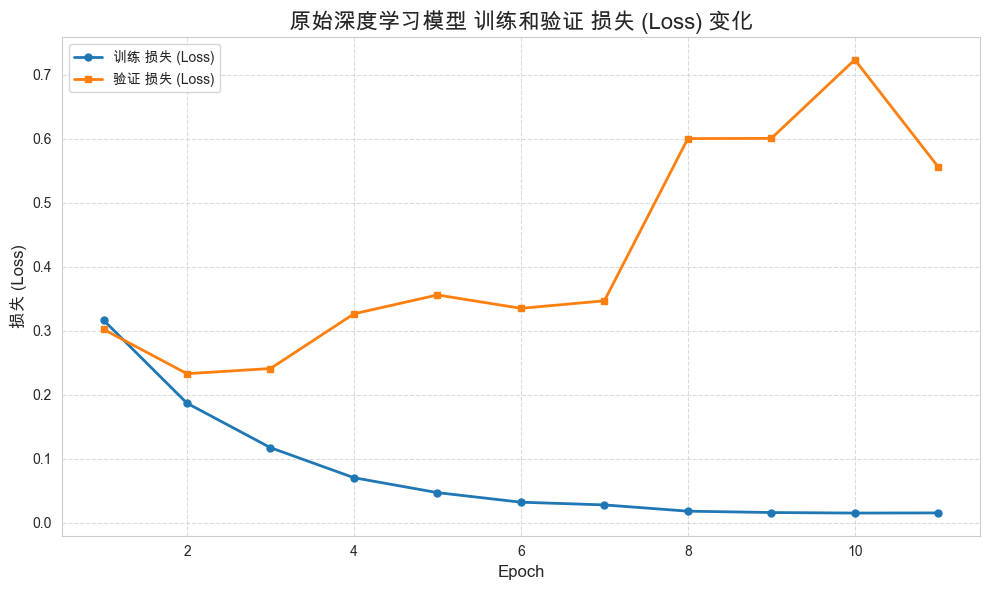

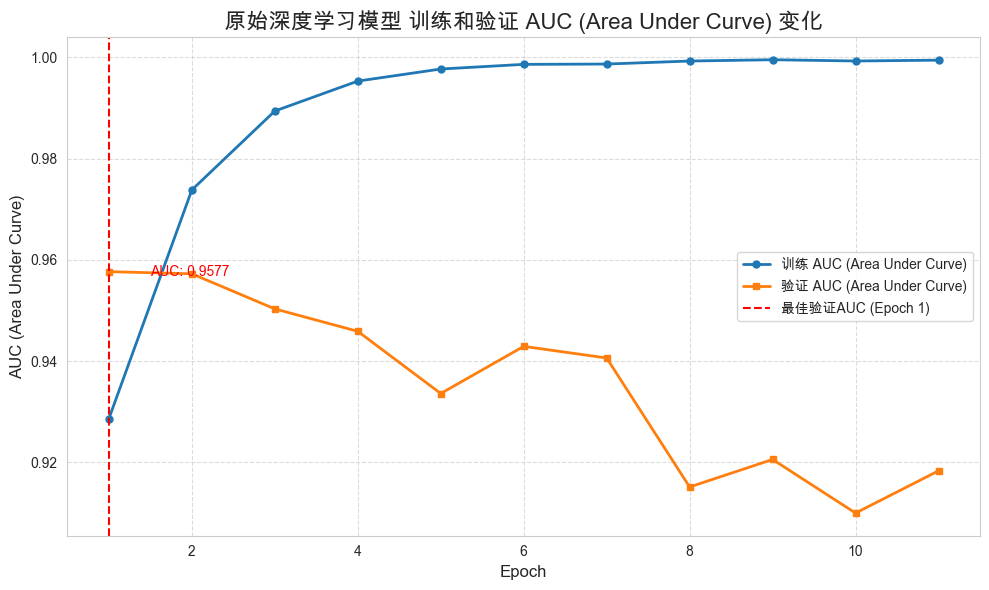


原始深度学习模型 训练结果可视化完成。


In [123]:
plot_dl_training_history(history.history, model_name="原始深度学习模型")


对原始深度学习模型的训练结果进行可视化发现：

1. 训练集损失一直下降，但是测试集损失忽上忽下，epoch7之后明显上升，可能是模型出现过拟合的迹象
2. 以AUC衡量的最佳模型参数在epoch1就已经训练好了，后面一直在下降。说明对于当前参数、结构的模型，后面的训练过程确实是导致了过拟合。

因此，尝试对学习率、正则化策略（增加 Dropout 强度或 L1/L2 正则化）以及 early_stopping 的 patience 进行更细致的调优，查看调参后的结果


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 profile_input (InputLayer)     [(None,)]            0           []                               
                                                                                                  
 tweets_input (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 text_vectorization_2 (TextVect  (None, 128)         0           ['profile_input[0][0]']          
 orization)                                                                                       
                                                                                                  
 text_vectorization_3 (TextVect  (None, 256)         0           ['tweets_input[0][0]']     

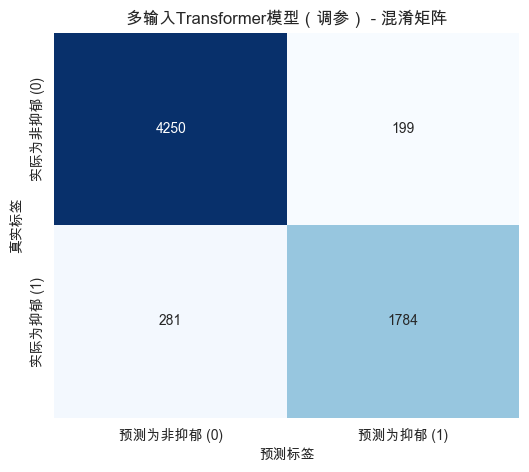

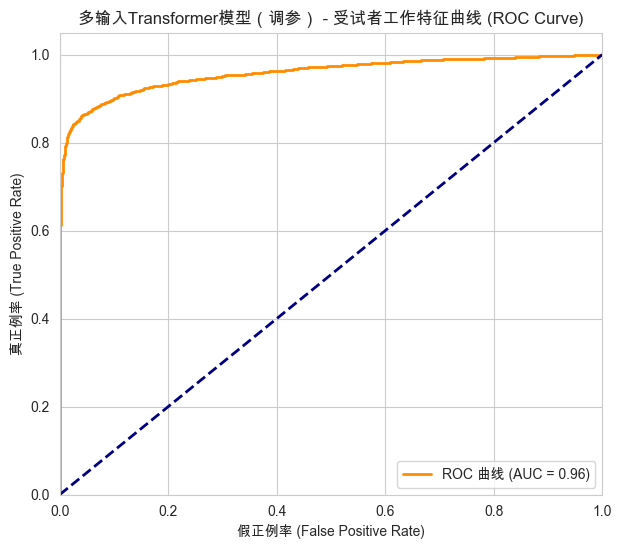


调参的的多输入深度学习模型 (model_deepl) 建模与评估完成。


In [103]:
## 调参的transformer模型

# --- 2. Transformer 编码器块定义 ---
# 增加了 dropout 参数的默认值，并在内部应用 dropout
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.2): # 提高默认 dropout
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    x = LayerNormalization(epsilon=1e-6)(x + inputs) # Add & Norm
    ffn_output = Dense(ff_dim, activation="relu")(x)
    ffn_output = Dense(inputs.shape[-1])(ffn_output) # Match input dim for residual
    return LayerNormalization(epsilon=1e-6)(ffn_output + x) # Add & Norm

# --- 3. Keras 多输入模型构建 ---
VOCAB_SIZE = 20000
EMBEDDING_DIM = 128

# Profile 文本输入分支
profile_input = Input(shape=(), dtype=tf.string, name='profile_input')
profile_vectorize_layer = layers.TextVectorization(
    max_tokens=VOCAB_SIZE, output_mode='int', output_sequence_length=128
)
profile_vectorize_layer.adapt(X_train_profile)
profile_vectors = profile_vectorize_layer(profile_input)
profile_embedding = layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM, name='profile_embedding')(profile_vectors)
# 在 transformer_encoder 调用时传入新的 dropout 值
profile_transformer_output = transformer_encoder(profile_embedding, head_size=EMBEDDING_DIM, num_heads=4, ff_dim=EMBEDDING_DIM*2, dropout=0.2) # 调整 dropout
profile_pooled = GlobalAveragePooling1D(name='profile_pooled')(profile_transformer_output)


# All Tweets Content 文本输入分支
tweets_input = Input(shape=(), dtype=tf.string, name='tweets_input')
tweets_vectorize_layer = layers.TextVectorization(
    max_tokens=VOCAB_SIZE, output_mode='int', output_sequence_length=256
)
tweets_vectorize_layer.adapt(X_train_tweets)
tweets_vectors = tweets_vectorize_layer(tweets_input)
tweets_embedding = layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM, name='tweets_embedding')(tweets_vectors)
# 在 transformer_encoder 调用时传入新的 dropout 值
tweets_transformer_output = transformer_encoder(tweets_embedding, head_size=EMBEDDING_DIM, num_heads=4, ff_dim=EMBEDDING_DIM*2, dropout=0.2) # 调整 dropout
tweets_pooled = GlobalAveragePooling1D(name='tweets_pooled')(tweets_transformer_output)


# 数值/二分变量输入分支
numerical_input = Input(shape=(len(numerical_cols),), name='numerical_input')


# 合并所有特征
combined_features = Concatenate(name='combined_features')([
    profile_pooled,
    tweets_pooled,
    numerical_input
])

# 分类头 - 调整 Dropout 率
x = Dense(128, activation='relu')(combined_features)
x = Dropout(0.4)(x) # 增加 Dropout 率
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x) # 保持或根据需要调整
output_layer = Dense(1, activation='sigmoid', name='output_prediction')(x)

# 构建新的模型，命名为 model_deepl
model_deepl = Model(inputs=[profile_input, tweets_input, numerical_input], outputs=output_layer)

model_deepl.summary()


# --- 4. 编译模型 ---
model_deepl.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy',
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall'),
                       tf.keras.metrics.AUC(name='auc')])

# --- 5. 训练模型 ---
# 调小 EarlyStopping 的 patience 值
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_auc', patience=5, mode='max', restore_best_weights=True, verbose=1 # patience 调整为 5
)

# 准备训练数据字典
train_data_dict = {
    'profile_input': X_train_profile,
    'tweets_input': X_train_tweets,
    'numerical_input': X_train_numerical_np
}

history_deepl = model_deepl.fit(train_data_dict, y_train_np,
                                epochs=50,
                                batch_size=32,
                                validation_split=0.2,
                                class_weight=class_weight_dict,
                                callbacks=[early_stopping],
                                verbose=1)

# --- 6. 评估模型 ---
# 准备测试数据字典
test_data_dict = {
    'profile_input': X_test_profile,
    'tweets_input': X_test_tweets,
    'numerical_input': X_test_numerical_np
}

loss_deepl, accuracy_deepl, precision_deepl, recall_deepl, auc_score_deepl = model_deepl.evaluate(test_data_dict, y_test_np, verbose=0)

print(f"\n测试集损失 (Loss) for model_deepl: {loss_deepl:.4f}")
print(f"测试集准确率 (Accuracy) for model_deepl: {accuracy_deepl:.4f}")
print(f"测试集精确率 (Precision) for model_deepl: {precision_deepl:.4f}")
print(f"测试集召回率 (Recall) for model_deepl: {recall_deepl:.4f}")
print(f"测试集AUC分数 (AUC) for model_deepl: {auc_score_deepl:.4f}")

# 预测结果
y_pred_proba_dl_new = model_deepl.predict(test_data_dict).flatten()
y_pred_dl_new = (y_pred_proba_dl_new > 0.5).astype(int)

evaluate_and_plot("多输入Transformer模型（调参）", y_test_np, y_pred_dl_new, y_pred_proba_dl_new)

print("\n调参的的多输入深度学习模型 (model_deepl) 建模与评估完成。")


--- 调参的深度学习模型 训练结果可视化 ---


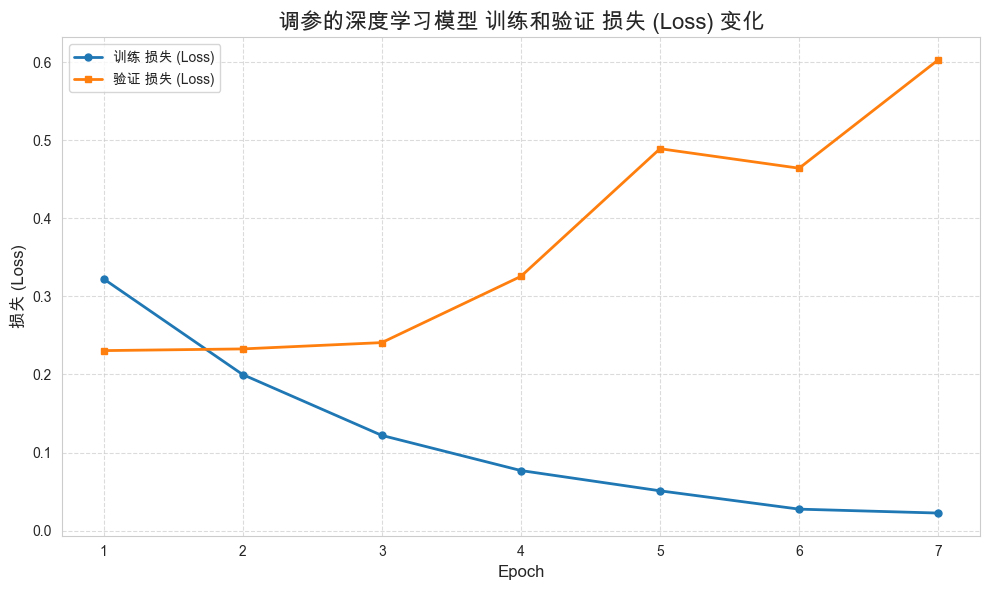

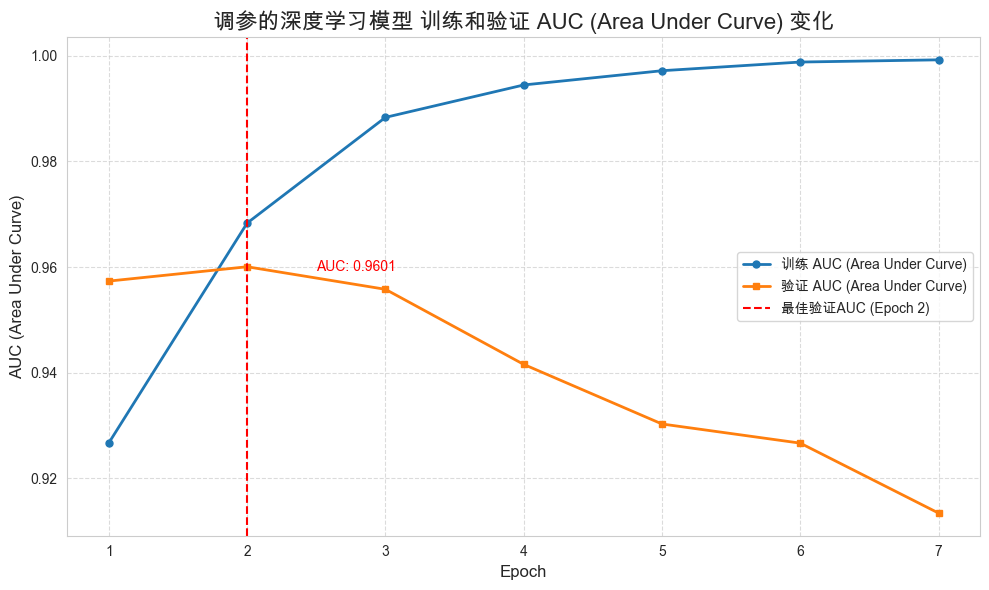


调参的深度学习模型 训练结果可视化完成。


In [105]:
plot_dl_training_history(history_deepl.history, model_name="调参的深度学习模型")


调整参数后的模型只有一点很微弱的进步。但是从训练结果可视化来看相比于第一次在epoch1就达到最优效果而之后一直出现过拟合现象，该模型在epoch2才达到最优效果AUC = 0.9601，这也算一点小小的进步。接下来，对模型结构也进行调整，从而减少模型的参数复杂度（因为对于三万多条的小样本数据，可能不需要这么复杂的模型就能达到更好的效果），再次进行试验。


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 profile_input (InputLayer)     [(None,)]            0           []                               
                                                                                                  
 tweets_input (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 text_vectorization_4 (TextVect  (None, 128)         0           ['profile_input[0][0]']          
 orization)                                                                                       
                                                                                                  
 text_vectorization_5 (TextVect  (None, 256)         0           ['tweets_input[0][0]']     

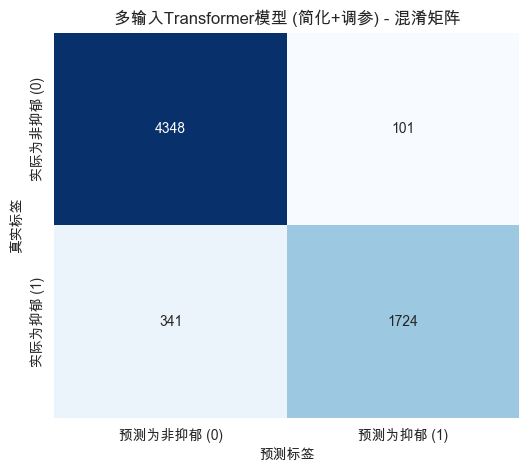

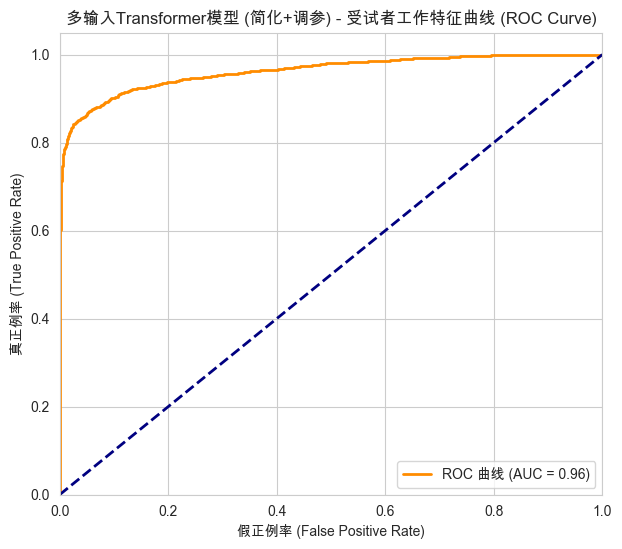


简化+调参的多输入深度学习模型 (model_deepl_simplified) 建模与评估完成。


In [107]:
# --- 2. Transformer 编码器块定义 ---
# 保留 dropout 参数
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.2):
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    x = LayerNormalization(epsilon=1e-6)(x + inputs)
    ffn_output = Dense(ff_dim, activation="relu")(x)
    ffn_output = Dense(inputs.shape[-1])(ffn_output)
    return LayerNormalization(epsilon=1e-6)(ffn_output + x)

# --- 3. Keras 多输入模型构建 ---
# 降低 EMBEDDING_DIM
VOCAB_SIZE = 20000
EMBEDDING_DIM_NEW = 96 # 从 128 降到 96

# Profile 文本输入分支
profile_input = Input(shape=(), dtype=tf.string, name='profile_input')
profile_vectorize_layer = layers.TextVectorization(
    max_tokens=VOCAB_SIZE, output_mode='int', output_sequence_length=128
)
profile_vectorize_layer.adapt(X_train_profile)
profile_vectors = profile_vectorize_layer(profile_input)
# 使用新的 EMBEDDING_DIM_NEW
profile_embedding = layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM_NEW, name='profile_embedding')(profile_vectors)
# 调整 head_size 和 ff_dim 以匹配新的 EMBEDDING_DIM_NEW，并调整 num_heads
profile_transformer_output = transformer_encoder(profile_embedding, head_size=EMBEDDING_DIM_NEW, num_heads=3, ff_dim=EMBEDDING_DIM_NEW*2, dropout=0.2) # num_heads 从 4 降到 3
profile_pooled = GlobalAveragePooling1D(name='profile_pooled')(profile_transformer_output)


# All Tweets Content 文本输入分支
tweets_input = Input(shape=(), dtype=tf.string, name='tweets_input')
tweets_vectorize_layer = layers.TextVectorization(
    max_tokens=VOCAB_SIZE, output_mode='int', output_sequence_length=256
)
tweets_vectorize_layer.adapt(X_train_tweets)
tweets_vectors = tweets_vectorize_layer(tweets_input)
# 使用新的 EMBEDDING_DIM_NEW
tweets_embedding = layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM_NEW, name='tweets_embedding')(tweets_vectors)
# 调整 head_size 和 ff_dim 以匹配新的 EMBEDDING_DIM_NEW，并调整 num_heads
tweets_transformer_output = transformer_encoder(tweets_embedding, head_size=EMBEDDING_DIM_NEW, num_heads=3, ff_dim=EMBEDDING_DIM_NEW*2, dropout=0.2) # num_heads 从 4 降到 3
tweets_pooled = GlobalAveragePooling1D(name='tweets_pooled')(tweets_transformer_output)


# 数值/二分变量输入分支
numerical_input = Input(shape=(len(numerical_cols),), name='numerical_input')


# 合并所有特征
combined_features = Concatenate(name='combined_features')([
    profile_pooled,
    tweets_pooled,
    numerical_input
])

# 分类头 - 减少神经元数量
x = Dense(64, activation='relu')(combined_features) # 从 128 降到 64
x = Dropout(0.4)(x)
x = Dense(32, activation='relu')(x) # 从 64 降到 32
x = Dropout(0.3)(x)
output_layer = Dense(1, activation='sigmoid', name='output_prediction')(x)

# 构建新的模型，命名为 model_deepl_simplified
model_deepl_simplified = Model(inputs=[profile_input, tweets_input, numerical_input], outputs=output_layer)

model_deepl_simplified.summary()


# --- 4. 编译模型 ---
model_deepl_simplified.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy',
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall'),
                       tf.keras.metrics.AUC(name='auc')])

# --- 5. 训练模型 ---
# EarlyStopping patience 仍保持调整后的值
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_auc', patience=5, mode='max', restore_best_weights=True, verbose=1
)

# 准备训练数据字典
train_data_dict = {
    'profile_input': X_train_profile,
    'tweets_input': X_train_tweets,
    'numerical_input': X_train_numerical_np
}

history_deepl_simplified = model_deepl_simplified.fit(train_data_dict, y_train_np,
                                epochs=50,
                                batch_size=32,
                                validation_split=0.2,
                                class_weight=class_weight_dict,
                                callbacks=[early_stopping],
                                verbose=1)

# --- 6. 评估模型 ---
# 准备测试数据字典
test_data_dict = {
    'profile_input': X_test_profile,
    'tweets_input': X_test_tweets,
    'numerical_input': X_test_numerical_np
}

loss_simplified, accuracy_simplified, precision_simplified, recall_simplified, auc_score_simplified = model_deepl_simplified.evaluate(test_data_dict, y_test_np, verbose=0)

print(f"\n测试集损失 (Loss) for model_deepl_simplified: {loss_simplified:.4f}")
print(f"测试集准确率 (Accuracy) for model_deepl_simplified: {accuracy_simplified:.4f}")
print(f"测试集精确率 (Precision) for model_deepl_simplified: {precision_simplified:.4f}")
print(f"测试集召回率 (Recall) for model_deepl_simplified: {recall_simplified:.4f}")
print(f"测试集AUC分数 (AUC) for model_deepl_simplified: {auc_score_simplified:.4f}")

# 预测结果
y_pred_proba_dl_simplified = model_deepl_simplified.predict(test_data_dict).flatten()
y_pred_dl_simplified = (y_pred_proba_dl_simplified > 0.5).astype(int)

evaluate_and_plot("多输入Transformer模型 (简化+调参)", y_test_np, y_pred_dl_simplified, y_pred_proba_dl_simplified)

print("\n简化+调参的多输入深度学习模型 (model_deepl_simplified) 建模与评估完成。")


--- 简化+调参的深度学习模型 训练结果可视化 ---


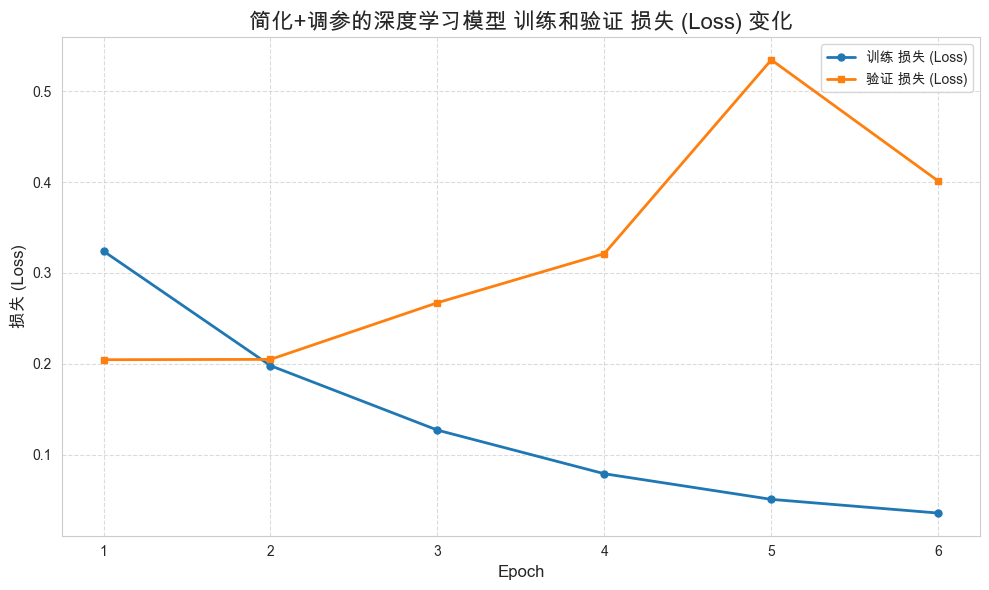

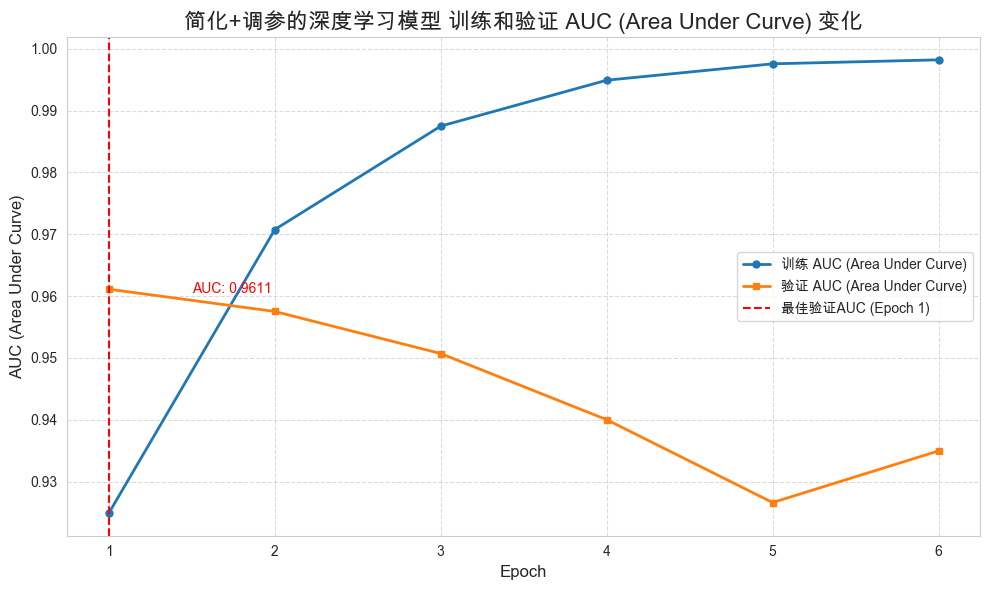


简化+调参的深度学习模型 训练结果可视化完成。


In [109]:
plot_dl_training_history(history_deepl_simplified.history, model_name="简化+调参的深度学习模型")


可以看到简化结构后的模型又有了一点微弱的进步，但也是在epoch1之后又出现了过拟合。

总结以上建模步骤：由于这里的参数都是人工修改的，只是作为观察“调整参数能否对模型效果产生显著影响”的一种尝试，所选取的参数并没有明确的科学依据。事实上，对于超参数的调优可以通过贝叶斯优化、遗传算法和随机搜索算法实现；同理，对于架构设计，也有专门的NAS方法自动化神经网络架构的设计过程。

经简化+调参的深度学习比XGBoost逊色，而又比其他模型表现都要好。并不是说深度学习在分类任务方面不如XGBoost，而是可能对于当前的数据量（三万多条，算是小数据集，使深度学习处理大型数据的优势被限制了），以及未采用超参数调优算法和NAS自动化神经网络架构算法的情况下出现了现在的结果。这也可以作为进一步的研究方向。

此外，深度学习模型通常对计算资源和训练时间有着更高的要求（使用CPU运行时有的模型甚至要运行半个小时）。在实际应用中，这也可能影响我们对模型选择的权衡，尤其是在资源受限的情况下，XGBoost 能够在保证高性能的同时，提供更高的训练效率。



--- 提取 Logistic 回归模型的变量重要性（系数）并可视化 ---

--- 模型: Original_LogisticRegression - 基于系数的重要性 ---
前10个最重要的特征及它们的系数：
                        特征        系数    系数绝对值
 all_tweets_content_emb_12 -3.285650 3.285650
 all_tweets_content_emb_13 -3.282101 3.282101
all_tweets_content_emb_217  3.264675 3.264675
all_tweets_content_emb_222  3.222604 3.222604
all_tweets_content_emb_253  3.166793 3.166793
all_tweets_content_emb_112 -3.059300 3.059300
all_tweets_content_emb_156 -3.037374 3.037374
 all_tweets_content_emb_98 -3.001520 3.001520
all_tweets_content_emb_147  2.959772 2.959772
 all_tweets_content_emb_67  2.942001 2.942001


/var/folders/t4/_y2wc33j1g188h2tcjbjh18m0000gn/T/ipykernel_31343/202059533.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='系数', y='特征', data=plot_df, palette='vlag')


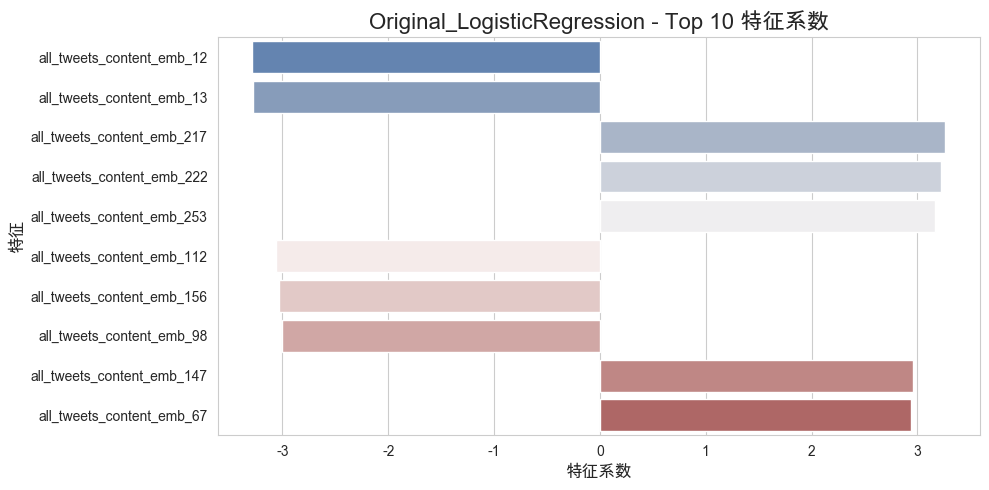


--- 模型: Oversample_LogisticRegression - 基于系数的重要性 ---
前10个最重要的特征及它们的系数：
                        特征        系数    系数绝对值
all_tweets_content_emb_217  4.066724 4.066724
all_tweets_content_emb_156 -3.627919 3.627919
all_tweets_content_emb_180  3.556684 3.556684
 all_tweets_content_emb_75 -3.414976 3.414976
 all_tweets_content_emb_67  3.411702 3.411702
all_tweets_content_emb_271  3.311907 3.311907
all_tweets_content_emb_147  3.282637 3.282637
 all_tweets_content_emb_27  3.277101 3.277101
all_tweets_content_emb_253  3.273714 3.273714
all_tweets_content_emb_287 -3.241991 3.241991


/var/folders/t4/_y2wc33j1g188h2tcjbjh18m0000gn/T/ipykernel_31343/202059533.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='系数', y='特征', data=plot_df, palette='vlag')


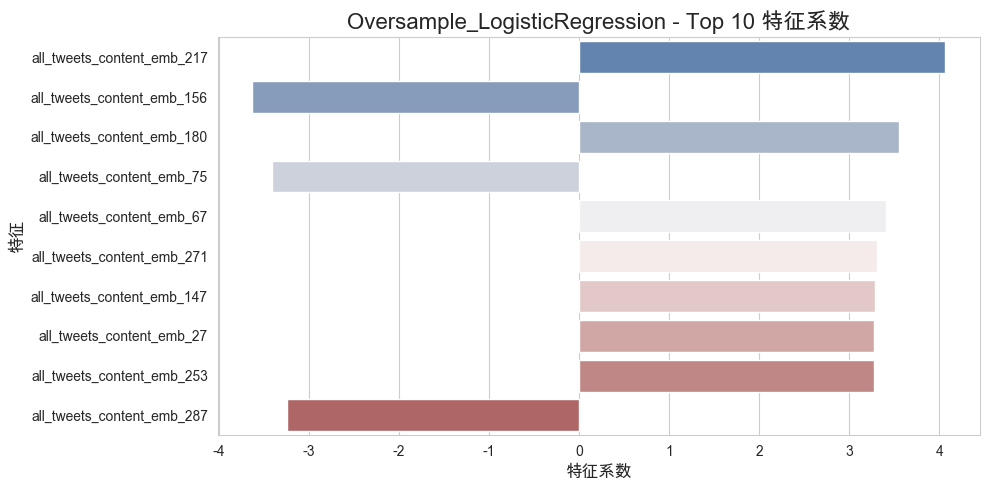


--- 模型: Undersample_LogisticRegression - 基于系数的重要性 ---
前10个最重要的特征及它们的系数：
                        特征        系数    系数绝对值
 all_tweets_content_emb_12 -3.261500 3.261500
all_tweets_content_emb_147  3.153502 3.153502
all_tweets_content_emb_253  2.882964 2.882964
all_tweets_content_emb_112 -2.702387 2.702387
all_tweets_content_emb_217  2.635718 2.635718
all_tweets_content_emb_180  2.628855 2.628855
all_tweets_content_emb_222  2.608115 2.608115
all_tweets_content_emb_156 -2.595834 2.595834
all_tweets_content_emb_108  2.588900 2.588900
 all_tweets_content_emb_13 -2.564176 2.564176


/var/folders/t4/_y2wc33j1g188h2tcjbjh18m0000gn/T/ipykernel_31343/202059533.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='系数', y='特征', data=plot_df, palette='vlag')


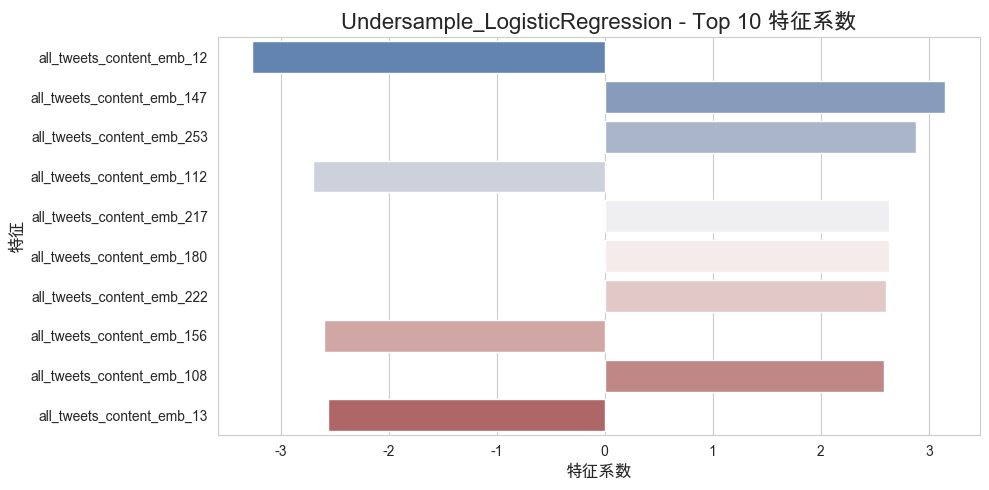


--- 模型: SMOTE_LogisticRegression - 基于系数的重要性 ---
前10个最重要的特征及它们的系数：
                        特征        系数    系数绝对值
all_tweets_content_emb_217  4.021717 4.021717
all_tweets_content_emb_191 -3.736307 3.736307
all_tweets_content_emb_253  3.719490 3.719490
all_tweets_content_emb_156 -3.652928 3.652928
 all_tweets_content_emb_67  3.611493 3.611493
 all_tweets_content_emb_13 -3.596218 3.596218
all_tweets_content_emb_112 -3.566775 3.566775
all_tweets_content_emb_147  3.546536 3.546536
 all_tweets_content_emb_98 -3.467835 3.467835
all_tweets_content_emb_271  3.445514 3.445514


/var/folders/t4/_y2wc33j1g188h2tcjbjh18m0000gn/T/ipykernel_31343/202059533.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='系数', y='特征', data=plot_df, palette='vlag')


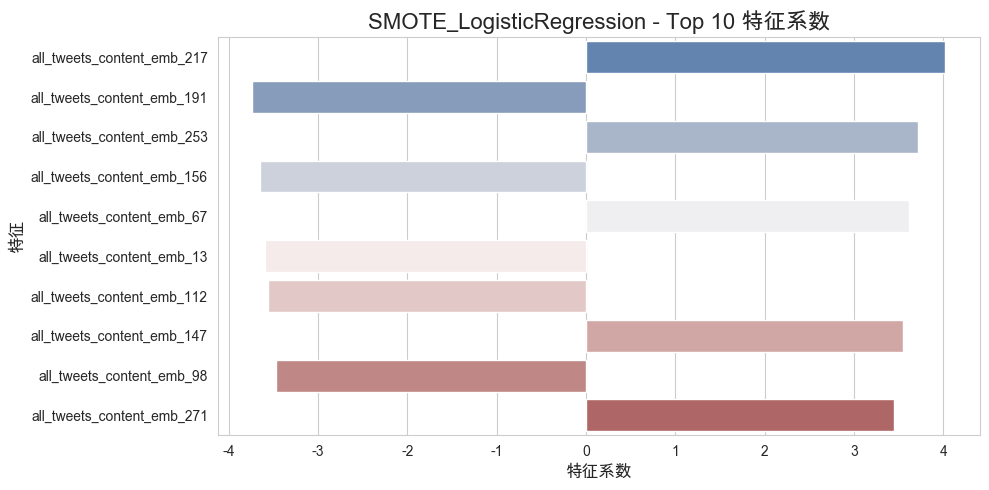


所有 Logistic 回归模型的变量重要性（基于系数）可视化完毕。


In [69]:
### 第四部分：特征重要性探索

## logistic模型的特征重要性（基于系数的可视化）

trained_models_logistic = {
    'Original_LogisticRegression': model_orig,
    'Oversample_LogisticRegression': pipeline_oversample,
    'Undersample_LogisticRegression': pipeline_undersample,
    'SMOTE_LogisticRegression': pipeline_smote,
}

print("\n--- 提取 Logistic 回归模型的变量重要性（系数）并可视化 ---")

# 获取特征名称
feature_names = X_train.columns.tolist()

for model_name, model_or_pipeline in trained_models_logistic.items():
    print(f"\n--- 模型: {model_name} - 基于系数的重要性 ---")

    classifier = None
    scaler = None
    if isinstance(model_or_pipeline, Pipeline):
        classifier = model_or_pipeline.named_steps['classifier']
        if 'scaler' in model_or_pipeline.named_steps:
            scaler = model_or_pipeline.named_steps['scaler']
    elif isinstance(model_or_pipeline, LogisticRegression):
        classifier = model_or_pipeline

    # Logistic 回归的系数 (coef_) 就是其变量重要性
    coefficients = classifier.coef_.flatten()

    importance_df = pd.DataFrame({
        '特征': feature_names,
        '系数': coefficients
    })
    importance_df['系数绝对值'] = np.abs(importance_df['系数'])
    importance_df = importance_df.sort_values(by='系数绝对值', ascending=False).reset_index(drop=True)

    print("前10个最重要的特征及它们的系数：")
    print(importance_df[['特征', '系数', '系数绝对值']].head(10).to_string(index=False))


    # --- 可视化变量重要性（基于系数）---
    # 选取前10个特征进行可视化
    top_n = 10 
    plot_df = importance_df.head(top_n)

    plt.figure(figsize=(10, 0.5 * top_n)) 
    sns.barplot(x='系数', y='特征', data=plot_df, palette='vlag') 
    plt.title(f'{model_name} - Top {top_n} 特征系数', fontsize=16)
    plt.xlabel('特征系数', fontsize=12)
    plt.ylabel('特征', fontsize=12)
    plt.tick_params(axis='y', labelsize=10)
    plt.tight_layout() # 自动调整布局，避免长变量标签重叠
    plt.show()

print("\n所有 Logistic 回归模型的变量重要性（基于系数）可视化完毕。")


为了探究最能影响分类结果的特征，对所有表现不错的模型进行特征重要性可视化。

对于logistic回归模型而言，变量的系数就可以用来衡量重要性。这里可以看到原始模型和三个重抽样模型系数结果有差距，但是该模型选择出的最重要变量都是推文文本的词嵌入向量的某几个维度。



--- 提取 决策树模型的变量重要性（基于平均基尼系数减少值）并可视化 ---

--- 模型: Oversample_DecisionTree - 基于平均基尼系数减少值的重要性 ---
前10个最重要的特征及它们的重要性：
                        特征      重要性
  original_tweet_count_log 0.427927
    repost_tweet_count_log 0.278702
 all_tweets_content_emb_12 0.053098
       all_tweet_count_log 0.039470
all_tweets_content_emb_166 0.025353
all_tweets_content_emb_288 0.020829
all_tweets_content_emb_280 0.009532
  all_tweets_content_emb_4 0.007415
all_tweets_content_emb_101 0.007122
all_tweets_content_emb_216 0.006465

说明：重要性得分越高，该特征对模型决策（节点基尼系数减少值）的贡献越大。


/var/folders/t4/_y2wc33j1g188h2tcjbjh18m0000gn/T/ipykernel_31343/1213453060.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='重要性', y='特征', data=plot_df, palette='viridis') # viridis 调色板适合单向重要性


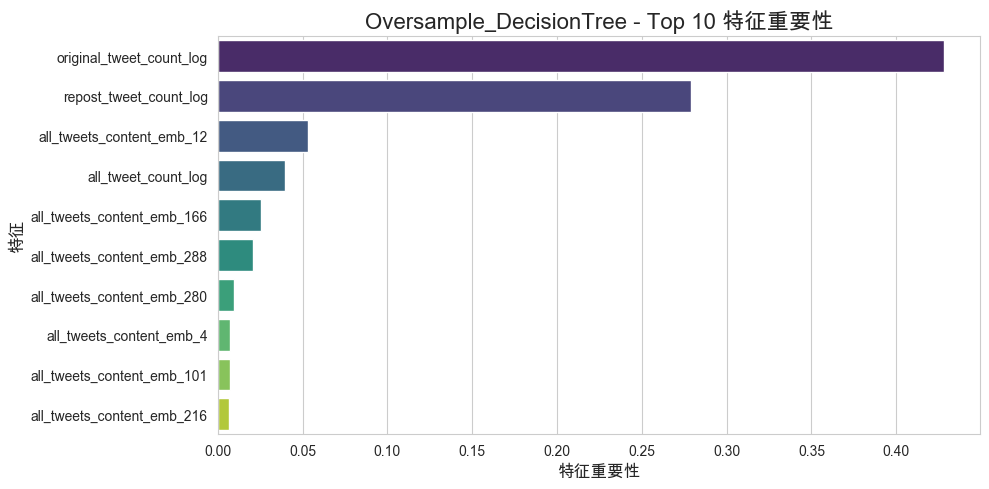


 决策树模型的变量重要性（基于平均基尼系数减少值）可视化完毕。


In [83]:
## 决策树模型（过采样）的特征重要性（基于平均基尼系数减少值的可视化）

trained_models_dt = {
    'Oversample_DecisionTree': pipeline_dt_oversample,
}
print("\n--- 提取 决策树模型的变量重要性（基于平均基尼系数减少值）并可视化 ---")

feature_names = X_train.columns.tolist()

for model_name, model_or_pipeline in trained_models_dt.items():
    print(f"\n--- 模型: {model_name} - 基于平均基尼系数减少值的重要性 ---")

    classifier = model_or_pipeline.named_steps['classifier']

    importances = classifier.feature_importances_

    importance_df = pd.DataFrame({
        '特征': feature_names,
        '重要性': importances
    })
    importance_df = importance_df.sort_values(by='重要性', ascending=False).reset_index(drop=True)

    print("前10个最重要的特征及它们的重要性：")
    print(importance_df[['特征', '重要性']].head(10).to_string(index=False))
    print("\n说明：重要性得分越高，该特征对模型决策（节点基尼系数减少值）的贡献越大。")

    # --- 可视化变量重要性（基于平均基尼系数减少值减少）---
    top_n = 10
    plot_df = importance_df.head(top_n)

    plt.figure(figsize=(10, 0.5 * top_n))
    sns.barplot(x='重要性', y='特征', data=plot_df, palette='viridis') # viridis 调色板适合单向重要性
    plt.title(f'{model_name} - Top {top_n} 特征重要性', fontsize=16)
    plt.xlabel('特征重要性', fontsize=12)
    plt.ylabel('特征', fontsize=12)
    plt.tick_params(axis='y', labelsize=10)
    plt.tight_layout()
    plt.show()

print("\n 决策树模型的变量重要性（基于平均基尼系数减少值）可视化完毕。")


对于决策树模型，采用平均基尼系数减少值作为变量重要性的依据。

可以看到，与logistic回归模型不同，决策树模型选择出的最重要变量是原创推文数（对数变换后）和转发推文数（对数变换后），以及一些推文的词嵌入维度。

二者的差异可能源于内在机制和对特征关系处理方式：logistic回归作为线性模型，主要衡量变量的线性贡献；而决策树可能更好地捕捉到了一些非线性影响因素。

Logistic 回归默认情况下不考虑特征之间的交互作用，而决策树模型天生就能捕捉特征间的复杂交互作用。

而事实上，结合用户行为数据（尤其是原创/转发推文数）和推文内容语义（词嵌入）可能对于预测抑郁倾向至关重要。

综上决策树模型的重要性排序结果可能更可靠，下面通过其他模型的变量重要性结果进一步说明这一点：



--- 提取 LinearSVC 模型的变量重要性（基于系数）并可视化 ---

--- 模型: Undersample_LinearSVC - 基于系数的重要性 ---
前10个最重要的特征及它们的系数：
                        特征        系数    系数绝对值
 all_tweets_content_emb_12 -0.190954 0.190954
all_tweets_content_emb_156 -0.154769 0.154769
 all_tweets_content_emb_21  0.150390 0.150390
 all_tweets_content_emb_18  0.147908 0.147908
all_tweets_content_emb_180  0.147490 0.147490
 all_tweets_content_emb_13 -0.147025 0.147025
 all_tweets_content_emb_63 -0.144692 0.144692
 all_tweets_content_emb_79 -0.136242 0.136242
all_tweets_content_emb_268  0.136236 0.136236
 all_tweets_content_emb_82  0.135164 0.135164


/var/folders/t4/_y2wc33j1g188h2tcjbjh18m0000gn/T/ipykernel_31343/580812084.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='系数', y='特征', data=plot_df, palette='vlag') # vlag 调色板可区分正负


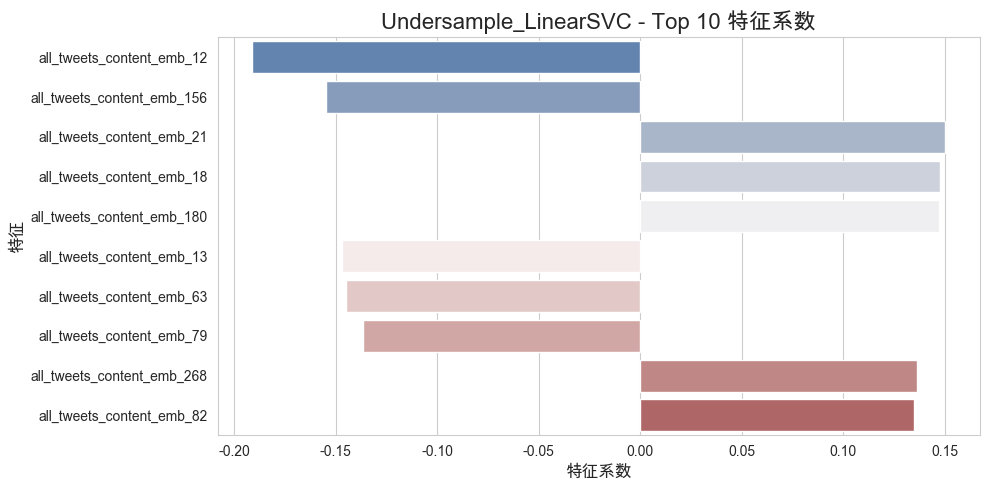


 LinearSVC 模型的变量重要性（基于系数）可视化完毕。


In [91]:
## LinearSVC（欠采样） 模型的特征重要性（基于系数的可视化）

trained_models_LinearSVC = {
    'Undersample_LinearSVC': pipeline_svm_undersample,
}

print("\n--- 提取 LinearSVC 模型的变量重要性（基于系数）并可视化 ---")

feature_names = X_train.columns.tolist()

for model_name, model_or_pipeline in trained_models_LinearSVC.items():
    print(f"\n--- 模型: {model_name} - 基于系数的重要性 ---")

    classifier = model_or_pipeline.named_steps['classifier']

    # LinearSVC 的系数 (coef_) 就是其变量重要性
    # 对于二分类，coef_通常是一个2D数组，需要flatten
    coefficients = classifier.coef_.flatten()

    importance_df = pd.DataFrame({
        '特征': feature_names,
        '系数': coefficients
    })
    importance_df['系数绝对值'] = np.abs(importance_df['系数'])
    importance_df = importance_df.sort_values(by='系数绝对值', ascending=False).reset_index(drop=True)

    print("前10个最重要的特征及它们的系数：")
    print(importance_df[['特征', '系数', '系数绝对值']].head(10).to_string(index=False))


    # --- 可视化变量重要性（基于系数）---
    top_n = 10
    plot_df = importance_df.head(top_n)

    plt.figure(figsize=(10, 0.5 * top_n))
    sns.barplot(x='系数', y='特征', data=plot_df, palette='vlag') # vlag 调色板可区分正负
    plt.title(f'{model_name} - Top {top_n} 特征系数', fontsize=16)
    plt.xlabel('特征系数', fontsize=12)
    plt.ylabel('特征', fontsize=12)
    plt.tick_params(axis='y', labelsize=10)
    plt.tight_layout()
    plt.show()

print("\n LinearSVC 模型的变量重要性（基于系数）可视化完毕。")


支持向量机的变量重要性也能通过系数直接输出：从图中看出，该模型给出的最重要变量和logistic回归相似，这种相似性主要源于它们共同的线性决策边界特性。

这表明这些变量可能在数据中展现出较强的线性可分性，或者至少在这些模型的线性假设下，它们对分类决策起到了最直接、最显著的线性影响。这也再次印证了文本词嵌入的某些维度可能具有较好的线性区分能力。



--- 提取随机森林模型的变量重要性（基于 feature_importances_）并可视化 ---

--- 模型: Original_RandomForest - 基于 feature_importances_ 的重要性 ---
前10个最重要的特征及它们的重要性：
                        特征      重要性
  original_tweet_count_log 0.079949
    repost_tweet_count_log 0.048428
 all_tweets_content_emb_12 0.034651
all_tweets_content_emb_280 0.033199
all_tweets_content_emb_192 0.023143
all_tweets_content_emb_166 0.020749
all_tweets_content_emb_288 0.020076
all_tweets_content_emb_298 0.019218
all_tweets_content_emb_222 0.018135
all_tweets_content_emb_167 0.017460

说明：重要性得分越高，该特征对模型决策（节点不纯度减少）的贡献越大。


/var/folders/t4/_y2wc33j1g188h2tcjbjh18m0000gn/T/ipykernel_31343/979002228.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='重要性', y='特征', data=plot_df, palette='viridis') # viridis 调色板适合单向重要性


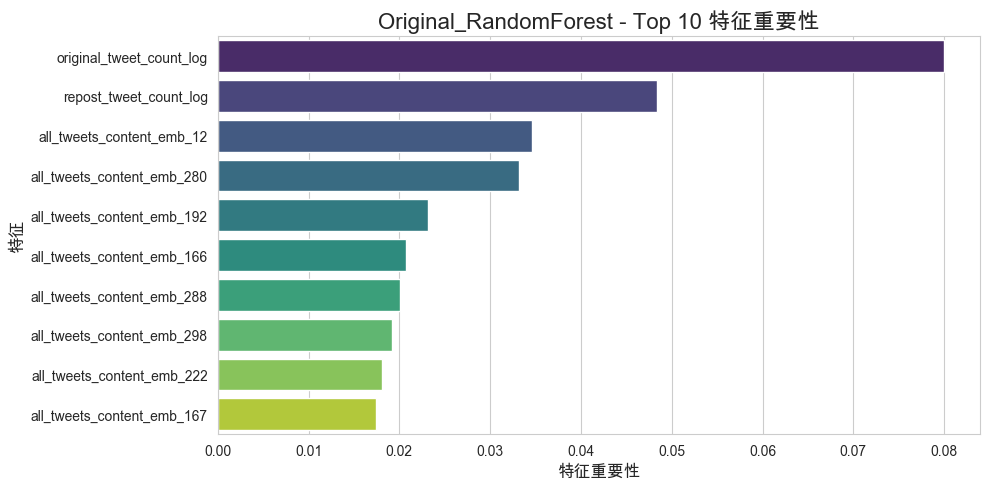


随机森林模型的变量重要性（基于 feature_importances_）可视化完毕。


In [93]:
## 随机森林模型的特征重要性（基于 feature_importances_ 的可视化）

trained_models_RandomForest = {
    'Original_RandomForest': pipeline_rf,
}

print("\n--- 提取随机森林模型的变量重要性（基于 feature_importances_）并可视化 ---")

# 获取特征名称
feature_names = X_train.columns.tolist()

for model_name, model_or_pipeline in trained_models_RandomForest.items():
    print(f"\n--- 模型: {model_name} - 基于 feature_importances_ 的重要性 ---")

    classifier = model_or_pipeline.named_steps['classifier']

    importances = classifier.feature_importances_

    # 将特征名称和重要性值关联起来
    importance_df = pd.DataFrame({
        '特征': feature_names,
        '重要性': importances
    })

    # 按重要性降序排序
    importance_df = importance_df.sort_values(by='重要性', ascending=False).reset_index(drop=True)

    print("前10个最重要的特征及它们的重要性：")
    print(importance_df.head(10).to_string(index=False))
    print("\n说明：重要性得分越高，该特征对模型决策（节点不纯度减少）的贡献越大。")


    # --- 可视化变量重要性（基于 feature_importances_）---
    top_n = 10
    plot_df = importance_df.head(top_n)

    plt.figure(figsize=(10, 0.5 * top_n))
    sns.barplot(x='重要性', y='特征', data=plot_df, palette='viridis') # viridis 调色板适合单向重要性
    plt.title(f'{model_name} - Top {top_n} 特征重要性', fontsize=16)
    plt.xlabel('特征重要性', fontsize=12)
    plt.ylabel('特征', fontsize=12)
    plt.tick_params(axis='y', labelsize=10)
    plt.tight_layout()
    plt.show()

print("\n随机森林模型的变量重要性（基于 feature_importances_）可视化完毕。")


随机森林和XGBoost的变量重要性都可以通过内置的feature_importances进行可视化。

相比logistic回归和支持向量机表现更好的随机森林模型也将原创推文数（对数处理后）和转发推文数（对数处理后），作为最重要的两个变量。此外，一些词嵌入维度也是至关重要的。



--- 提取 XGBoost 模型的变量重要性（基于 feature_importances_）并可视化 ---

--- 模型: Original_XGBoost - 基于 feature_importances_ 的重要性 ---
前10个最重要的特征及它们的重要性：
                        特征      重要性
 all_tweets_content_emb_12 0.055281
all_tweets_content_emb_280 0.052807
all_tweets_content_emb_192 0.041686
  original_tweet_count_log 0.024531
    repost_tweet_count_log 0.019502
all_tweets_content_emb_166 0.014978
all_tweets_content_emb_298 0.014905
all_tweets_content_emb_288 0.011062
all_tweets_content_emb_216 0.010963
all_tweets_content_emb_222 0.009378

说明：重要性得分通常基于特征在树分裂中带来的增益（gain）或权重（weight）。得分越高，特征越重要。


/var/folders/t4/_y2wc33j1g188h2tcjbjh18m0000gn/T/ipykernel_31343/3679278554.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='重要性', y='特征', data=plot_df, palette='viridis') # viridis 调色板适合单向重要性


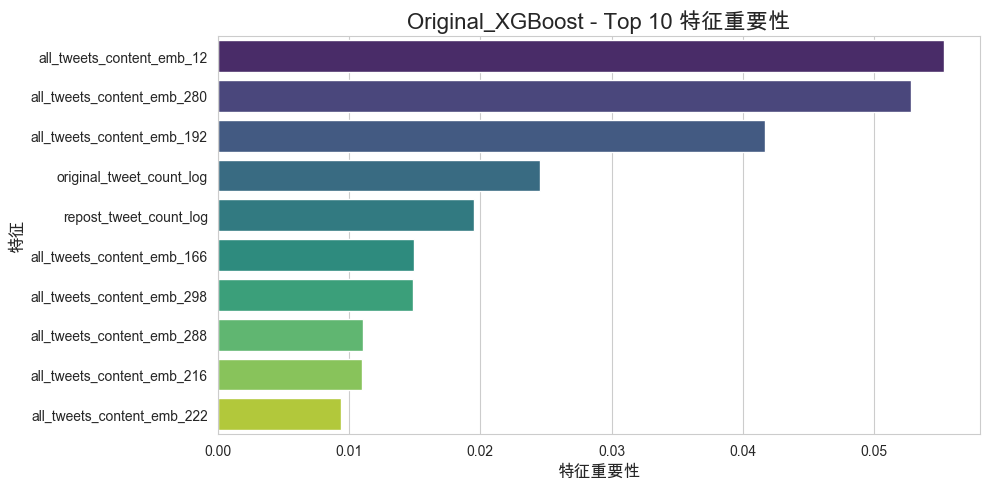


XGBoost 模型的变量重要性（基于 feature_importances_）可视化完毕。


In [95]:
## XGBoost 模型的特征重要性（基于 feature_importances_ 的可视化）

trained_models_XGBoost = {
    'Original_XGBoost': pipeline_xgb,
}

print("\n--- 提取 XGBoost 模型的变量重要性（基于 feature_importances_）并可视化 ---")

# 获取特征名称
feature_names = X_train.columns.tolist()

for model_name, model_or_pipeline in trained_models_XGBoost.items():
    print(f"\n--- 模型: {model_name} - 基于 feature_importances_ 的重要性 ---")

    classifier = model_or_pipeline.named_steps['classifier']

    # 检查是否有 feature_importances_ 属性
    if hasattr(classifier, 'feature_importances_'):
        importances = classifier.feature_importances_

        # 将特征名称和重要性值关联起来
        importance_df = pd.DataFrame({
            '特征': feature_names,
            '重要性': importances
        })

        # 按重要性降序排序
        importance_df = importance_df.sort_values(by='重要性', ascending=False).reset_index(drop=True)

        print("前10个最重要的特征及它们的重要性：")
        print(importance_df.head(10).to_string(index=False))
        print("\n说明：重要性得分通常基于特征在树分裂中带来的增益（gain）或权重（weight）。得分越高，特征越重要。")

        # --- 可视化变量重要性（基于 feature_importances_）---
        top_n = 10
        plot_df = importance_df.head(top_n)

        plt.figure(figsize=(10, 0.5 * top_n))
        sns.barplot(x='重要性', y='特征', data=plot_df, palette='viridis') # viridis 调色板适合单向重要性
        plt.title(f'{model_name} - Top {top_n} 特征重要性', fontsize=16)
        plt.xlabel('特征重要性', fontsize=12)
        plt.ylabel('特征', fontsize=12)
        plt.tick_params(axis='y', labelsize=10)
        plt.tight_layout()
        plt.show()
    else:
        print("该模型（或其内部分类器）不包含 'feature_importances_' 属性，无法进行此可视化。")

print("\nXGBoost 模型的变量重要性（基于 feature_importances_）可视化完毕。")

In [ ]:

表现最好的XGBoost模型中，虽然原创推文数（对数处理后）和转发推文数（对数处理后）不是最重要的，但也和其他一些词嵌入维度一起，作为重要的变量被筛选出来。

接下来，从另外一个角度——shap值分析特征的重要性。



--- 提取 XGBoost 模型的变量重要性（基于 SHAP 值）并可视化 ---

--- 模型: Original_XGBoost - 基于 SHAP 值的重要性 ---


 98%|===================| 6370/6514 [00:23<00:00]        


--- Original_XGBoost - SHAP 概要图 ---


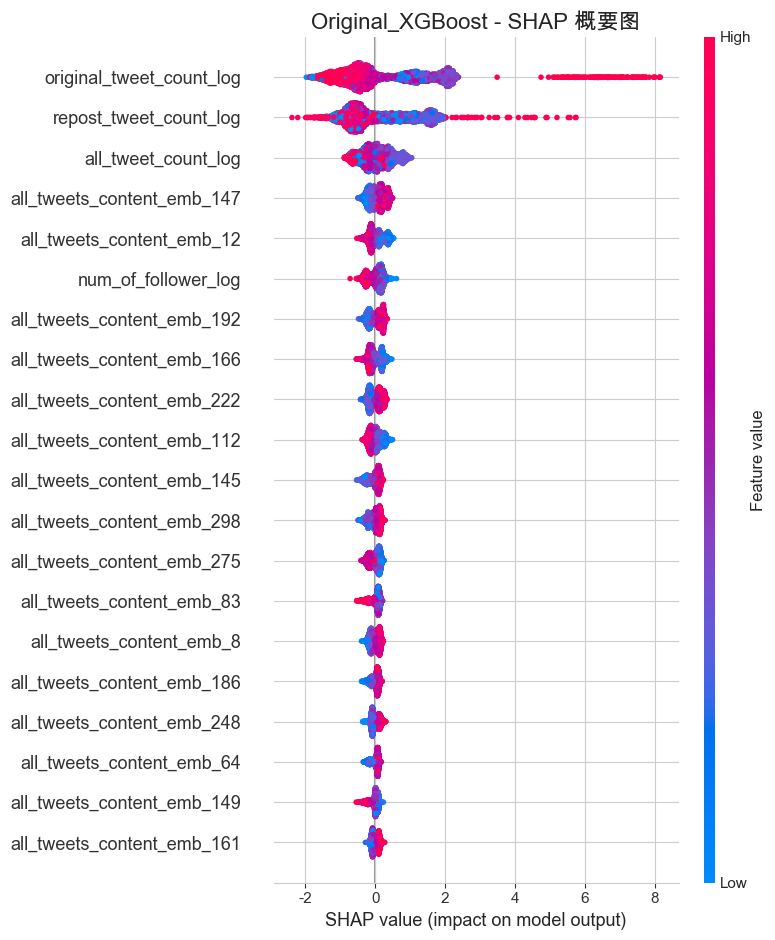


--- Original_XGBoost - SHAP 依赖图 (Top 3 特征) ---


<Figure size 800x600 with 0 Axes>

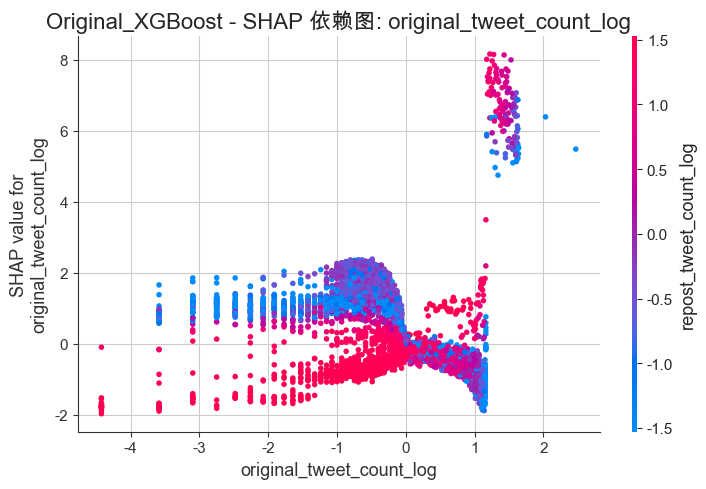

<Figure size 800x600 with 0 Axes>

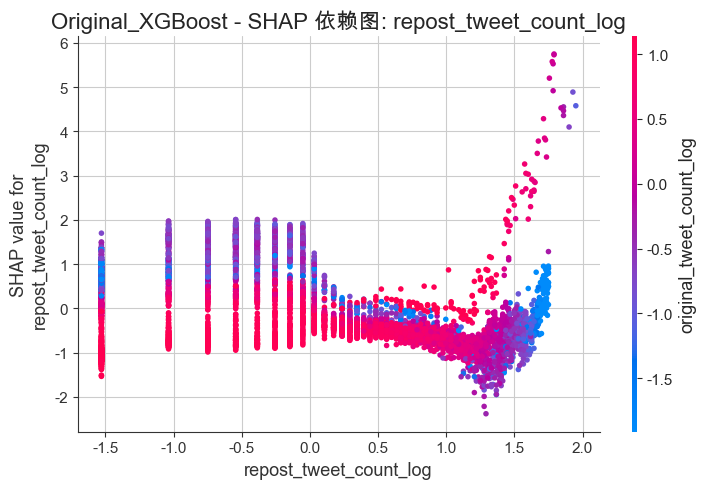

<Figure size 800x600 with 0 Axes>

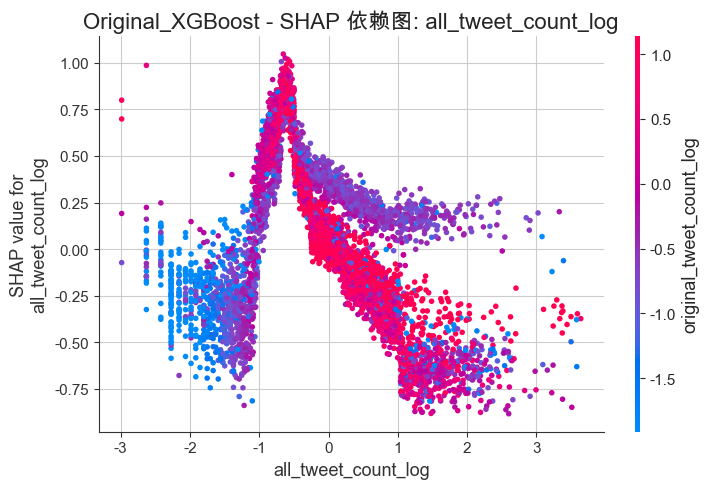


--- Original_XGBoost - SHAP 力图 (解释第一个测试样本) ---


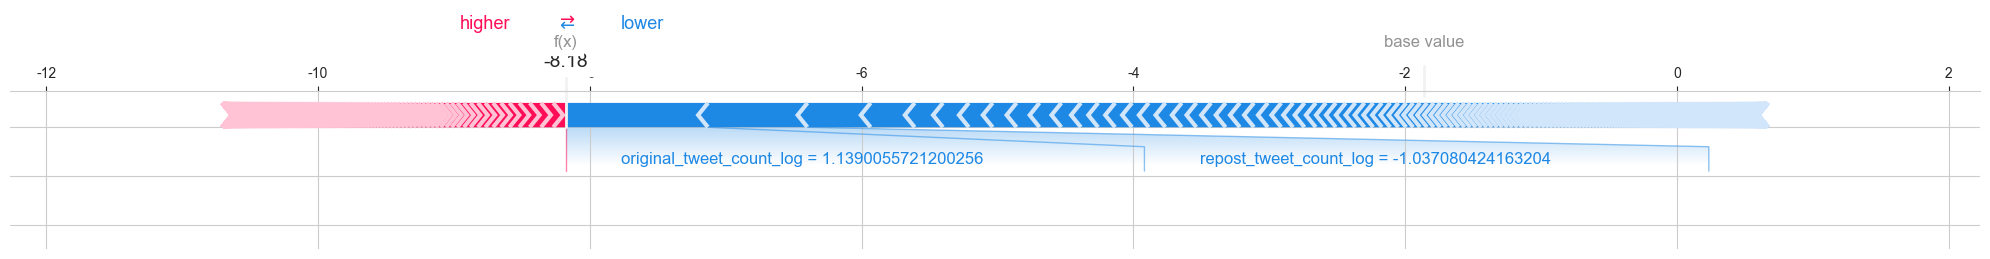


XGBoost 模型的变量重要性（基于 SHAP 值）可视化完毕。


In [97]:
## XGBoost 模型的特征重要性（基于 SHAP 值）

import shap

print("\n--- 提取 XGBoost 模型的变量重要性（基于 SHAP 值）并可视化 ---")

for model_name, model_or_pipeline in trained_models_XGBoost.items():
    print(f"\n--- 模型: {model_name} - 基于 SHAP 值的重要性 ---")

    classifier = model_or_pipeline.named_steps['classifier']

    # 提取所有预处理步骤，除了最后一个分类器
    preprocessor_steps = []
    for step_name, step_transformer in model_or_pipeline.named_steps.items():
        if step_name != 'classifier':
            preprocessor_steps.append((step_name, step_transformer))

    preprocessor_pipeline = Pipeline(preprocessor_steps)
    
    # 对训练数据和测试数据进行预处理，以匹配分类器实际接收的输入
    X_explainer_data = preprocessor_pipeline.transform(X_train.sample(min(100, len(X_train)), random_state=42))
    X_test_for_shap = preprocessor_pipeline.transform(X_test)
    X_test_for_shap = pd.DataFrame(X_test_for_shap, columns=feature_names) # SHAP plots prefer DataFrame with names

    # 创建 SHAP 解释器 (对于 XGBoost 使用 TreeExplainer)
    explainer = shap.TreeExplainer(classifier, X_explainer_data, feature_names=feature_names)
    shap_values = explainer.shap_values(X_test_for_shap)

    # 对于二分类，shap_values 是一个列表，取出正类（类别 1）的 SHAP 值
    if isinstance(shap_values, list):
        shap_values = shap_values[1]


    # --- SHAP 概要图 ---
    print(f"\n--- {model_name} - SHAP 概要图 ---")
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values, features=X_test_for_shap, feature_names=feature_names, show=False)
    plt.title(f'{model_name} - SHAP 概要图', fontsize=16)
    plt.tight_layout()
    plt.show()

    # --- SHAP 依赖图 ---
    sorted_features_indices = np.argsort(np.sum(np.abs(shap_values), axis=0))[::-1]
    top_shap_features = [feature_names[i] for i in sorted_features_indices[:3]]

    print(f"\n--- {model_name} - SHAP 依赖图 (Top 3 特征) ---")
    for feature in top_shap_features:
        plt.figure(figsize=(8, 6))
        shap.dependence_plot(feature, shap_values, features=X_test_for_shap, feature_names=feature_names, show=False)
        plt.title(f'{model_name} - SHAP 依赖图: {feature}', fontsize=16)
        plt.tight_layout()
        plt.show()

    # --- SHAP 力图 ---
    print(f"\n--- {model_name} - SHAP 力图 (解释第一个测试样本) ---")
    shap.force_plot(explainer.expected_value, shap_values[0,:], X_test_for_shap.iloc[0,:], feature_names=feature_names, matplotlib=True, show=False)
    plt.tight_layout()
    plt.show()

print("\nXGBoost 模型的变量重要性（基于 SHAP 值）可视化完毕。")


（注：这里all_tweet_count并不是original_tweet_count和repost_tweet的加和，还包括其他类型的推文。）

1. 从SHAP概要图来看，original_tweet_count_log、repost_tweet_count_log 和 all_tweet_count_log 是最重要的三个变量（说明发原创内容和转发内容的数量对模型预测起主导作用），此外一些词嵌入维度、粉丝数也有一定的影响。从图中我们可以看出，相比正常人（蓝色点，大多集中在中部），抑郁症患者的原创微博和转发微博呈现两极分化：一部分患者发/转帖子很少，而另外一部分患者发/转帖子相当多。（可能要么沉默寡言，要么不停宣泄负面情绪。）此外，一些词嵌入维度可以很好地区分正常人和抑郁症患者（几乎红色点都在0点的一边，蓝色点在另一边），这些维度可能表示的是一些积极/消极的情绪。

2. 从original_tweet_count_log和repost_tweet_count_lo的SHAP依赖图可以印证上面关于“两极分化”的论述；当 original_tweet_count_log 增大到一定值时，SHAP 值急剧上升，说明该变量有明显的非线性影响（这也印证了为什么logistic回归和支持向量机模型输出的重要变量中没有原创推文数和转发推文数）；此外，在 SHAP 值高的区域中，repost_tweet_count_log（颜色偏红）通常也偏高，说明：原创和转发推文数量之间存在正交互作用，双高时模型输出最大（存在“活跃门槛”，突破后影响力迅速增强），也就是该样本越有可能是抑郁症患者。而相比之下，所有推文数对模型预测的影响模式就不是很好解释（处于特定区间：-1到0时模型倾向于将样本预测为抑郁症患者）。

3. 从SHAP力图（以第一个测试样本为例）的结果来看，原始推文数量的对数值为1.139，这个值高于该特征的平均值(因为箭头向右)，使最终预测值增加了约2个单位(从基准值向右推)；转发推文数量的对数值为-1.037，这个值低于该特征的平均值(因为箭头向左)，使最终预测值减少了约1个单位(从基准值向左拉)。这进一步验证了上面的分析。

总结：从比较可靠的几个非线性模型输出结果来看，original_tweet_count_log、repost_tweet_count_log在对博主是否抑郁进行分类的任务中是很重要的——相比正常人（蓝色点，大多集中在中部），抑郁症患者的原创微博和转发微博呈现两极分化：一部分患者发/转帖子很少，而另外一部分患者发/转帖子相当多。此外，一些词嵌入维度可以很好地区分正常人和抑郁症患者（几乎红色点都在0点的一边，蓝色点在另一边），这些维度可能表示的是一些积极/消极的情绪。



计算得到的 scale_pos_weight: 2.15

--- 开始 XGBoost 消融实验 ---

--- 训练 XGBoost (仅数值/性别) ---

--- XGBoost (仅数值/性别) 模型评估报告 ---
准确率 (Accuracy): 0.9073

分类报告 (Classification Report):
              precision    recall  f1-score   support

           0       0.95      0.92      0.93      4449
           1       0.83      0.89      0.86      2065

    accuracy                           0.91      6514
   macro avg       0.89      0.90      0.89      6514
weighted avg       0.91      0.91      0.91      6514


混淆矩阵 (Confusion Matrix):
 [[4072  377]
 [ 227 1838]]

ROC AUC 分数: 0.9721


/opt/anaconda3/envs/my_ml_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [18:01:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


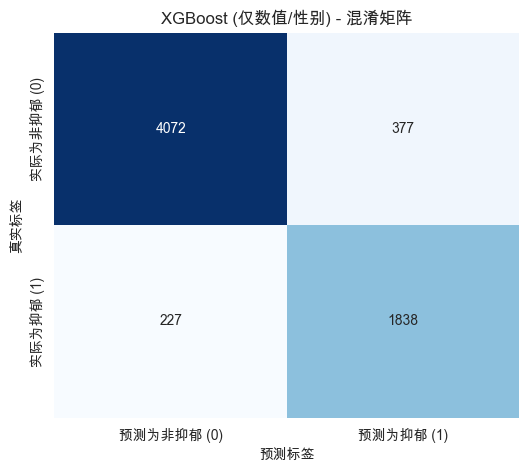

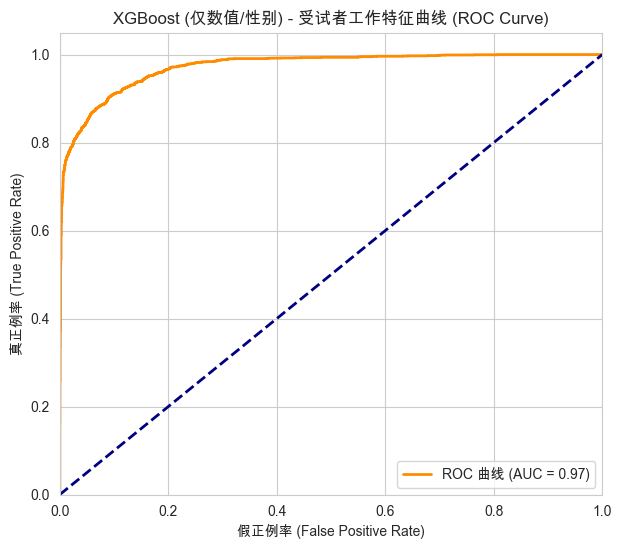


--- 训练 XGBoost (仅 Profile 嵌入) ---


/opt/anaconda3/envs/my_ml_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [18:02:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



--- XGBoost (仅 Profile 嵌入) 模型评估报告 ---
准确率 (Accuracy): 0.5385

分类报告 (Classification Report):
              precision    recall  f1-score   support

           0       0.75      0.48      0.59      4449
           1       0.37      0.66      0.47      2065

    accuracy                           0.54      6514
   macro avg       0.56      0.57      0.53      6514
weighted avg       0.63      0.54      0.55      6514


混淆矩阵 (Confusion Matrix):
 [[2153 2296]
 [ 710 1355]]

ROC AUC 分数: 0.5990


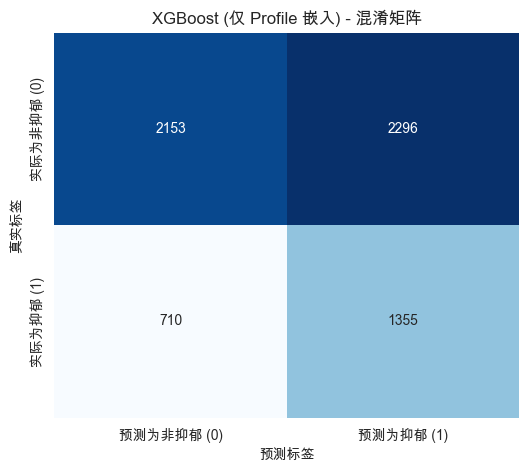

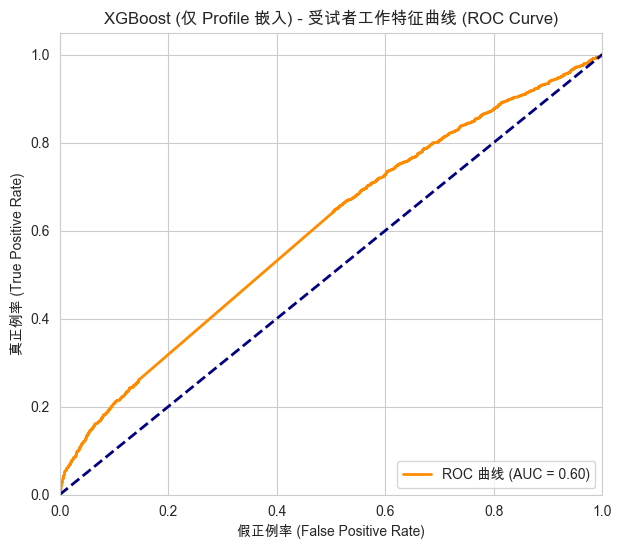


--- 训练 XGBoost (仅所有推文内容嵌入) ---


/opt/anaconda3/envs/my_ml_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [18:02:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



--- XGBoost (仅所有推文内容嵌入) 模型评估报告 ---
准确率 (Accuracy): 0.9051

分类报告 (Classification Report):
              precision    recall  f1-score   support

           0       0.92      0.94      0.93      4449
           1       0.87      0.83      0.85      2065

    accuracy                           0.91      6514
   macro avg       0.89      0.88      0.89      6514
weighted avg       0.90      0.91      0.90      6514


混淆矩阵 (Confusion Matrix):
 [[4188  261]
 [ 357 1708]]

ROC AUC 分数: 0.9397


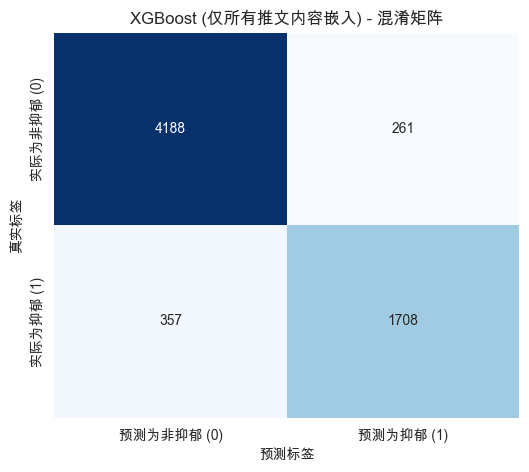

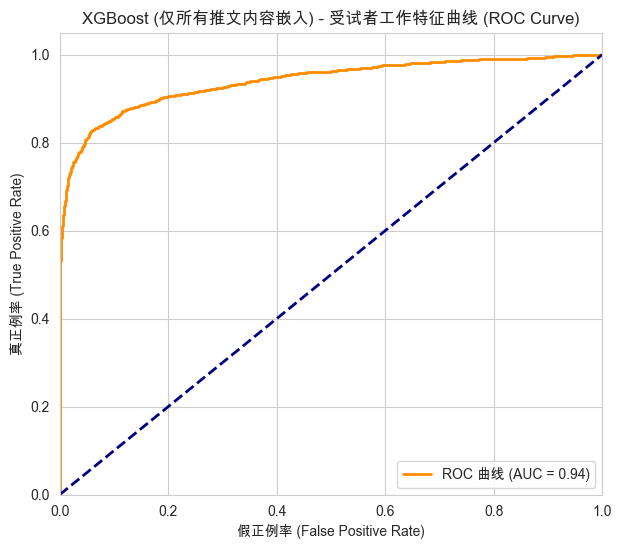


--- 训练 XGBoost (数值/性别 + Profile 嵌入) ---


/opt/anaconda3/envs/my_ml_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [18:02:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



--- XGBoost (数值/性别 + Profile 嵌入) 模型评估报告 ---
准确率 (Accuracy): 0.9139

分类报告 (Classification Report):
              precision    recall  f1-score   support

           0       0.94      0.93      0.94      4449
           1       0.85      0.88      0.87      2065

    accuracy                           0.91      6514
   macro avg       0.90      0.90      0.90      6514
weighted avg       0.91      0.91      0.91      6514


混淆矩阵 (Confusion Matrix):
 [[4137  312]
 [ 249 1816]]

ROC AUC 分数: 0.9721


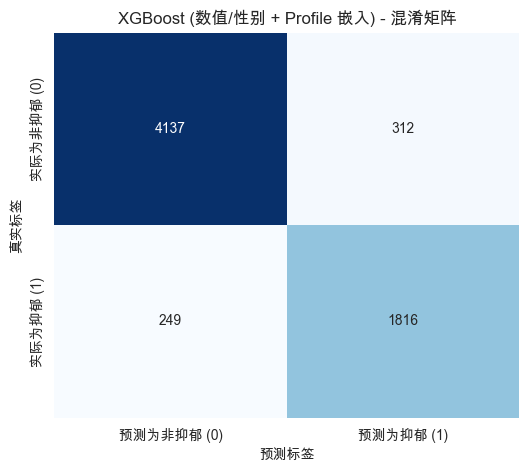

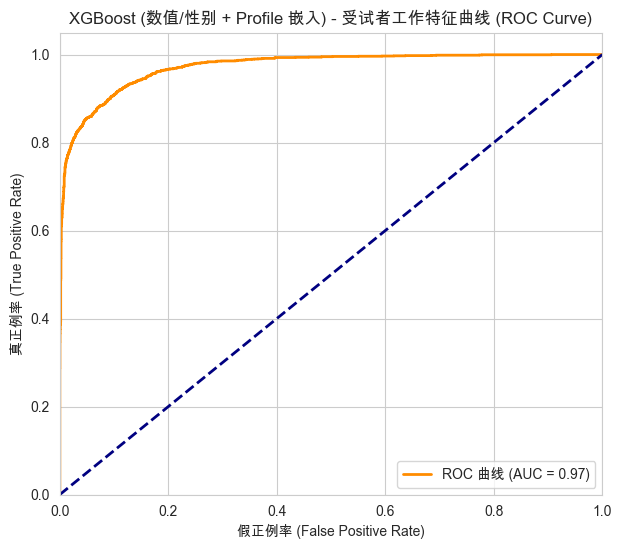


--- 训练 XGBoost (数值/性别 + 所有推文内容嵌入) ---


/opt/anaconda3/envs/my_ml_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [18:02:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



--- XGBoost (数值/性别 + 所有推文内容嵌入) 模型评估报告 ---
准确率 (Accuracy): 0.9544

分类报告 (Classification Report):
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      4449
           1       0.95      0.91      0.93      2065

    accuracy                           0.95      6514
   macro avg       0.95      0.94      0.95      6514
weighted avg       0.95      0.95      0.95      6514


混淆矩阵 (Confusion Matrix):
 [[4342  107]
 [ 190 1875]]

ROC AUC 分数: 0.9854


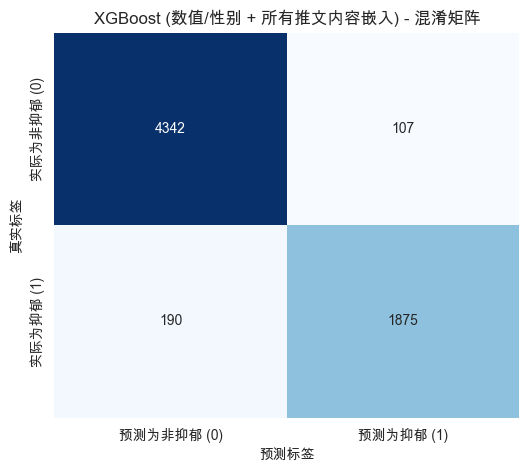

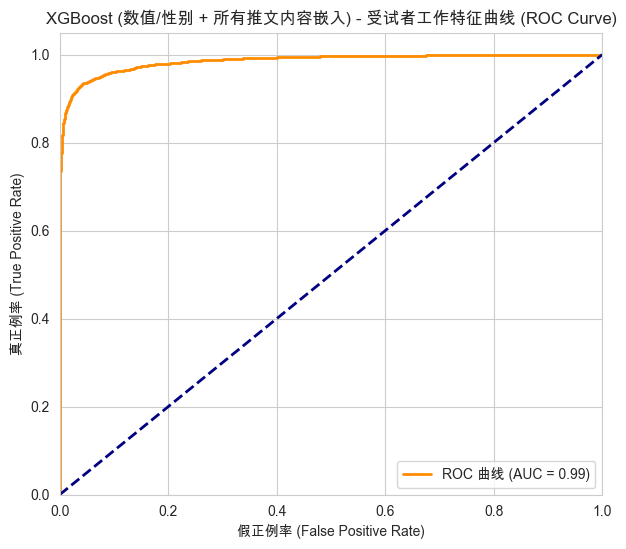


--- 训练 XGBoost (Profile 嵌入 + 所有推文内容嵌入) ---


/opt/anaconda3/envs/my_ml_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [18:02:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



--- XGBoost (Profile 嵌入 + 所有推文内容嵌入) 模型评估报告 ---
准确率 (Accuracy): 0.9028

分类报告 (Classification Report):
              precision    recall  f1-score   support

           0       0.92      0.94      0.93      4449
           1       0.86      0.82      0.84      2065

    accuracy                           0.90      6514
   macro avg       0.89      0.88      0.89      6514
weighted avg       0.90      0.90      0.90      6514


混淆矩阵 (Confusion Matrix):
 [[4184  265]
 [ 368 1697]]

ROC AUC 分数: 0.9412


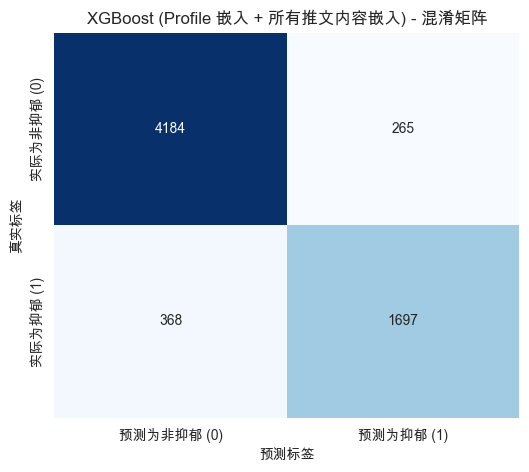

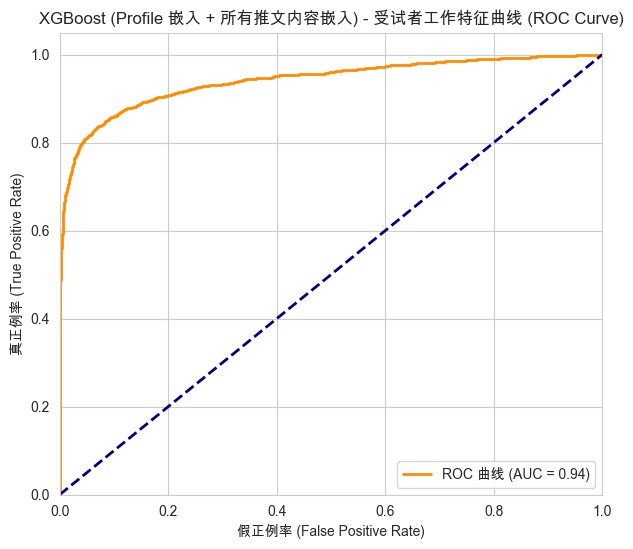


--- 训练 XGBoost (所有特征) ---


/opt/anaconda3/envs/my_ml_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [18:02:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



--- XGBoost (所有特征) 模型评估报告 ---
准确率 (Accuracy): 0.9549

分类报告 (Classification Report):
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      4449
           1       0.95      0.91      0.93      2065

    accuracy                           0.95      6514
   macro avg       0.95      0.94      0.95      6514
weighted avg       0.95      0.95      0.95      6514


混淆矩阵 (Confusion Matrix):
 [[4347  102]
 [ 192 1873]]

ROC AUC 分数: 0.9858


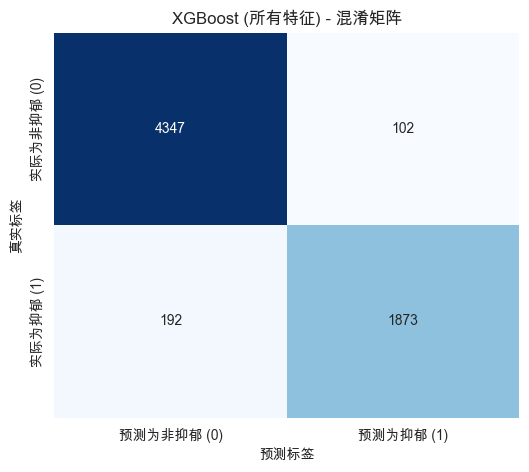

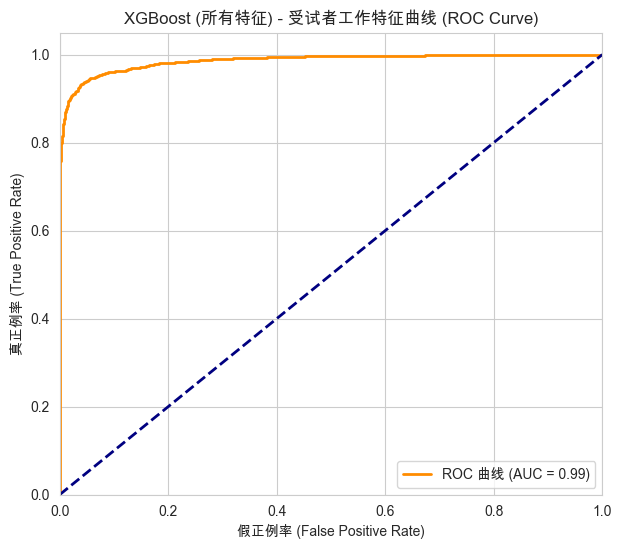


--- XGBoost 消融实验完成。---

--- XGBoost 消融实验结果摘要 ---
                          Model Accuracy Minority F1-Score ROC AUC
               XGBoost (仅数值/性别)   0.9073            0.8589  0.9721
         XGBoost (仅 Profile 嵌入)   0.5385            0.4741  0.5990
            XGBoost (仅所有推文内容嵌入)   0.9051            0.8468  0.9397
   XGBoost (数值/性别 + Profile 嵌入)   0.9139            0.8662  0.9721
     XGBoost (数值/性别 + 所有推文内容嵌入)   0.9544            0.9266  0.9854
XGBoost (Profile 嵌入 + 所有推文内容嵌入)   0.9028            0.8428  0.9412
                 XGBoost (所有特征)   0.9549            0.9272  0.9858


In [137]:
### 第五部分：消融实验（以表现最好的模型——XGBoost为例）

## 特征分类

num_samples = 32570
num_profile_embedding_features = 300
num_tweets_embedding_features = 300
np.random.seed(42)

num_gender_cols = [
    'gender_女', 'gender_男', 'num_of_follower_log',
    'num_of_following_log', 'all_tweet_count_log',
    'original_tweet_count_log', 'repost_tweet_count_log'
]
profile_embedding_cols = [f'profile_emb_{i}' for i in range(num_profile_embedding_features)]
all_tweets_content_embedding_cols = [f'all_tweets_content_emb_{i}' for i in range(num_tweets_embedding_features)]

## 参数设置

# 计算 scale_pos_weight 参数以处理类别不平衡
count_positive = y_train.sum()
count_negative = len(y_train) - count_positive
scale_pos_weight_value = count_negative / count_positive
print(f"\n计算得到的 scale_pos_weight: {scale_pos_weight_value:.2f}")

xgb_common_params = {
    'objective': 'binary:logistic',
    'n_estimators': 200,
    'learning_rate': 0.1,
    'max_depth': 5,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'gamma': 0.1,
    'random_state': 42,
    'n_jobs': -1,
    'scale_pos_weight': scale_pos_weight_value,
    'enable_categorical': True,
    'use_label_encoder': False
}

## 对不同的特征组合进行建模

# --- 定义不同的特征组合及其对应的列名列表 ---
feature_combinations = [
    # 单一板块模型
    {'name': 'XGBoost (仅数值/性别)', 'cols': num_gender_cols},
    {'name': 'XGBoost (仅 Profile 嵌入)', 'cols': profile_embedding_cols},
    {'name': 'XGBoost (仅所有推文内容嵌入)', 'cols': all_tweets_content_embedding_cols},

    # 两板块组合模型
    {'name': 'XGBoost (数值/性别 + Profile 嵌入)', 'cols': num_gender_cols + profile_embedding_cols},
    {'name': 'XGBoost (数值/性别 + 所有推文内容嵌入)', 'cols': num_gender_cols + all_tweets_content_embedding_cols},
    {'name': 'XGBoost (Profile 嵌入 + 所有推文内容嵌入)', 'cols': profile_embedding_cols + all_tweets_content_embedding_cols},

    # 三板块完整模型
    {'name': 'XGBoost (所有特征)', 'cols': num_gender_cols + profile_embedding_cols + all_tweets_content_embedding_cols}
]

# 用于存储所有模型评估结果的列表
ablation_results = []

# --- 循环训练和评估每个特征组合 ---
print("\n--- 开始 XGBoost 消融实验 ---")
for combo in feature_combinations:
    model_name = combo['name']
    current_cols = combo['cols']

    # 确保当前组合的特征列在X_train和X_test中存在
    X_train_current = X_train[current_cols]
    X_test_current = X_test[current_cols]

    print(f"\n--- 训练 {model_name} ---")
    pipeline_xgb_current = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', xgb.XGBClassifier(**xgb_common_params))
    ])

    pipeline_xgb_current.fit(X_train_current, y_train)

    y_pred_current = pipeline_xgb_current.predict(X_test_current)
    y_pred_proba_current = pipeline_xgb_current.predict_proba(X_test_current)[:, 1]
    
    accuracy = accuracy_score(y_test, y_pred_current)
    # 获取分类报告的字典形式，以便提取F1分数
    report_dict = classification_report(y_test, y_pred_current, output_dict=True)
    f1_minority = report_dict['1']['f1-score'] # 提取少数类（类别1）的F1分数
    roc_auc = roc_auc_score(y_test, y_pred_proba_current)

    ablation_results.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'Minority F1-Score': f1_minority,
        'ROC AUC': roc_auc
    })

    # 评估模型并保存结果
    evaluate_and_plot(model_name, y_test, y_pred_current, y_pred_proba_current)

print("\n--- XGBoost 消融实验完成。---")

# --- 打印最终消融结果摘要表 ---
print("\n--- XGBoost 消融实验结果摘要 ---")
results_df = pd.DataFrame(ablation_results)
# 格式化输出，方便阅读
results_df['Accuracy'] = results_df['Accuracy'].map('{:.4f}'.format)
results_df['Minority F1-Score'] = results_df['Minority F1-Score'].map('{:.4f}'.format)
results_df['ROC AUC'] = results_df['ROC AUC'].map('{:.4f}'.format)
print(results_df.to_string(index=False))


从消融实验结果来看，数值/性别变量（主要是原创推文和转发推文数量）是最重要的变量（单数值/性别变量的AUC分数达到0.9721）；其次是推文词嵌入向量，（单推文词嵌入向量的AUC分数达到0.9397）；而简介部分几乎对模型没有什么影响，准确度和AUC值都接近0.5，说明仅用简介几乎无法识别一个人是否抑郁。此外，数值+推文的组合效果几乎和全变量可以媲美。这和上一部分对特征重要性的探讨是一致的。



计算得到的 scale_pos_weight: 2.15

--- 开始 XGBoost 超参数调优 (RandomizedSearchCV) ---
Fitting 3 folds for each of 50 candidates, totalling 150 fits

--- XGBoost 超参数调优完成 ---
最佳 AUC 分数: 0.9865
最佳参数组合:
  colsample_bytree: 0.8724797657899961
  gamma: 0.11978094533348621
  learning_rate: 0.05201951290645469
  max_depth: 6
  n_estimators: 829
  reg_alpha: 0.009856648036564901
  reg_lambda: 0.0024281321623998895
  subsample: 0.8016406642217635

--- 使用最佳参数训练最终 XGBoost 模型 ---

--- XGBoost (Random Search 调优后) 模型评估报告 ---
准确率 (Accuracy): 0.9590

分类报告 (Classification Report):
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      4449
           1       0.96      0.91      0.93      2065

    accuracy                           0.96      6514
   macro avg       0.96      0.94      0.95      6514
weighted avg       0.96      0.96      0.96      6514


混淆矩阵 (Confusion Matrix):
 [[4376   73]
 [ 194 1871]]

ROC AUC 分数: 0.9882


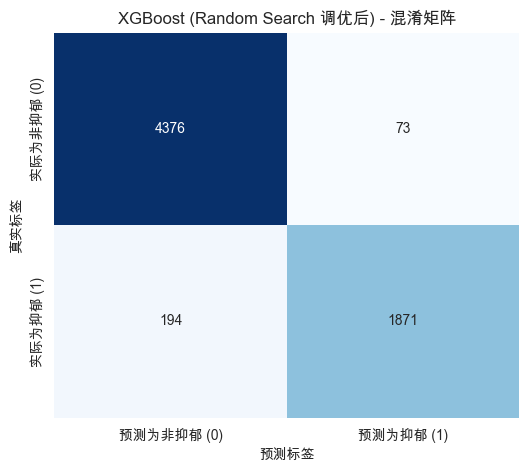

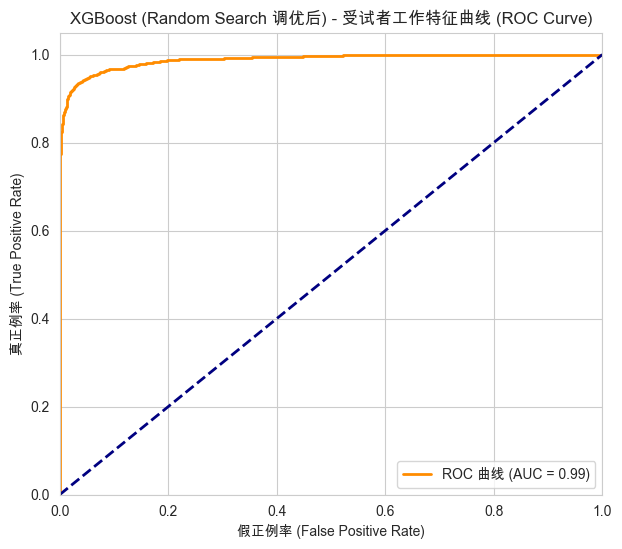


--- RandomizedSearchCV 结果分析 (前5个最佳组合) ---
                                               params  mean_test_score  \
21  {'colsample_bytree': 0.8724797657899961, 'gamm...         0.986546   
25  {'colsample_bytree': 0.6412562832437979, 'gamm...         0.986492   
37  {'colsample_bytree': 0.8091047222985803, 'gamm...         0.986404   
5   {'colsample_bytree': 0.7156249507619747, 'gamm...         0.986364   
31  {'colsample_bytree': 0.7103147409178301, 'gamm...         0.986312   

    std_test_score  
21        0.000998  
25        0.000631  
37        0.000664  
5         0.001089  
31        0.000500  


In [25]:
### 第六部分：超参数调优尝试

import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import uniform, randint # 用于定义随机分布

# 确保图中可以正确显示中文
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

# 计算 scale_pos_weight 
count_positive = y_train.sum()
count_negative = len(y_train) - count_positive
scale_pos_weight_value = count_negative / count_positive
print(f"\n计算得到的 scale_pos_weight: {scale_pos_weight_value:.2f}")

# --- 数据标准化/缩放 ---
# RandomizedSearchCV 内部会处理交叉验证，所以我们在这里对整个训练集进行拟合和转换。
# 假设 X_train 和 X_test 的所有特征都是数值类型，可以进行缩放。
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- 定义 XGBoost 模型的基础参数 ---
xgb_base_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'seed': 42,
    'n_jobs': -1,
    'scale_pos_weight': scale_pos_weight_value,
    'enable_categorical': True, # 如果您的XGBoost版本支持，可以处理分类特征
}

# --- 定义超参数的搜索空间 ---
param_distributions = {
    'n_estimators': randint(100, 1000), # 100 到 1000 之间的整数
    'learning_rate': uniform(0.01, 0.29), # 0.01 到 0.3 之间的浮点数 (0.01 + 0.29 = 0.3)
    'max_depth': randint(3, 10), # 3 到 9 之间的整数 (randint(low, high) 是 [low, high-1])
    'subsample': uniform(0.6, 0.3), # 0.6 到 0.9 之间的浮点数 (0.6 + 0.3 = 0.9)
    'colsample_bytree': uniform(0.6, 0.3), # 0.6 到 0.9 之间的浮点数
    'gamma': uniform(0.0, 0.5), # 0.0 到 0.5 之间的浮点数
    'reg_alpha': uniform(1e-5, 1e-2 - 1e-5), # L1 正则化项，小范围浮点数
    'reg_lambda': uniform(1e-5, 1e-2 - 1e-5), # L2 正则化项，小范围浮点数
}

# --- 初始化 XGBoost 分类器 ---
xgb_model = xgb.XGBClassifier(**xgb_base_params)

# --- 定义交叉验证策略 ---
cv_strategy = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# --- 初始化 RandomizedSearchCV ---
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_distributions,
    n_iter=50, # 随机尝试 50 种不同的参数组合
    scoring='roc_auc', # 我们希望最大化 AUC
    cv=cv_strategy,
    verbose=2, # 打印详细程度 (2 表示每次试验都会打印)
    random_state=42,
    n_jobs=-1, # 利用所有可用核心
    return_train_score=True
)

print("\n--- 开始 XGBoost 超参数调优 (RandomizedSearchCV) ---")
# 执行随机搜索
# 直接传入已经缩放好的训练数据
random_search.fit(X_train_scaled, y_train)

print("\n--- XGBoost 超参数调优完成 ---")
print(f"最佳 AUC 分数: {random_search.best_score_:.4f}")
print("最佳参数组合:")
for key, value in random_search.best_params_.items():
    print(f"  {key}: {value}")

# --- 使用最佳参数的最终 XGBoost 模型 ---
print("\n--- 使用最佳参数训练最终 XGBoost 模型 ---")
# random_search.best_estimator_ 会返回一个已经用最佳参数训练好的模型
final_tuned_xgb_model = random_search.best_estimator_

# --- 评估并绘制调优后的模型 ---
y_pred_tuned = final_tuned_xgb_model.predict(X_test_scaled)
y_pred_proba_tuned = final_tuned_xgb_model.predict_proba(X_test_scaled)[:, 1]

evaluate_and_plot("XGBoost (Random Search 调优后)", y_test, y_pred_tuned, y_pred_proba_tuned)

# --- 可选：分析 RandomizedSearchCV 结果 ---
print("\n--- RandomizedSearchCV 结果分析 (前5个最佳组合) ---")
results = pd.DataFrame(random_search.cv_results_)
results_sorted = results.sort_values(by='mean_test_score', ascending=False)
print(results_sorted[['params', 'mean_test_score', 'std_test_score']].head())


这里使用随机搜索方法进行超参数调优部分的尝试，旨在观察经调优后的XGBoost模型还能不能有更惊艳的表现。

XGBoost的参数有：

决策树（n_estimators）的数量，控制模型整体复杂度；学习率（learning_rate），控制模型的学习速度；最大树深度（max_depth），限制单棵树的复杂度；训练样本的子采样比例（subsample）和构造每棵树的子采样比例（colsample_bytree）；进一步划分需要的最小损失减少值（gamma），控制树的剪枝；L1正则化项（reg_alpha）和L2正则化项（reg_lambda），用来防止过拟合。

可以看到，最终获得的最佳参数组合。这些优化后的参数值，是随机搜索算法在给定的搜索空间和交叉验证策略下，认为能够使模型在验证集上达到最佳 ROC AUC 分数的组合。

确实经过超参数调优之后，模型的性能又提升了————AUC值从0.9858提升到了0.9882.

这里指定了参数的变动范围，未来还可以适当扩大范围得到更好的模型。此外，尝试其他搜索算法也是一个值得尝试的选择。
